# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    # 划分X_train和y_train的前49000为训练集，后1000为验证集
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    #划分测试集为测试集
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    #从训练集中随机选出500个开发集
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image，归一化处理
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    # X_train.shape[0]是样本数量，下面操作是在X中加一个属性列。
    # 这样计算出的W的最后一行为原b
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [3]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.322705
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** 
因为w随机初始化，所以每个类计算的得分都是相同的，经过softmax之后的概率都是一样的，而这是一个10分类的问题，所以每个类的概率都是0.1，经过交叉熵得到的loss就是 -log(0.1)


In [4]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 1.038047 analytic: 1.038047, relative error: 1.407083e-08
numerical: -1.867389 analytic: -1.867389, relative error: 7.417963e-09
numerical: -2.250730 analytic: -2.250730, relative error: 5.787295e-09
numerical: -0.434548 analytic: -0.434548, relative error: 9.520231e-08
numerical: -0.891657 analytic: -0.891657, relative error: 2.836509e-08
numerical: 1.519043 analytic: 1.519043, relative error: 1.810337e-09
numerical: 2.529987 analytic: 2.529987, relative error: 1.428054e-08
numerical: 1.394520 analytic: 1.394520, relative error: 2.772707e-09
numerical: 3.712769 analytic: 3.712769, relative error: 1.511565e-08
numerical: 2.048870 analytic: 2.048870, relative error: 5.567687e-09
numerical: 0.627324 analytic: 0.627324, relative error: 5.474656e-09
numerical: 2.301190 analytic: 2.301190, relative error: 3.639313e-08
numerical: -0.791387 analytic: -0.791387, relative error: 8.864126e-09
numerical: -2.168796 analytic: -2.168796, relative error: 1.101861e-08
numerical: -0.445343 a

In [22]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-2.32245328e+00  1.63726126e-01 -1.98631225e-01 ... -5.24402568e-01
  -2.44741085e+00 -4.76059953e+00]
 [-3.32447802e+00  8.76129768e-01  1.35538843e-01 ... -2.59981022e-01
  -3.80256553e+00 -5.56666394e+00]
 [-5.31914320e+00  7.81640761e-01  1.32445110e+00 ... -2.90365684e-01
  -5.65466330e+00 -7.13770209e+00]
 ...
 [-5.36725337e-01  6.78233007e-01  1.16266422e-01 ... -8.77303927e-01
  -1.80790268e-01 -2.14674708e+00]
 [-1.79592922e+00 -2.59597985e-01  8.49977614e-01 ...  5.26018325e-01
  -2.00015399e+00 -2.92543162e+00]
 [ 1.67235367e-02 -1.68338920e-02  1.50131645e-02 ... -1.10980850e-02
   1.25938281e-02  3.14130794e-03]]
naive loss: 2.322705e+00 computed in 0.345787s
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-2.32245328e+00  1.63726126e-01 -1.98631225e-01 ... -5.24402568e-01
  -2.44741085e+00 -4.76059953e+00]
 [-3.32447802e+00  8.76129768e-01  1.35538843e-01 ... -2.59981022e-0

In [30]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
from copy import deepcopy
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7, 5e-7]
regularization_strengths = [2.5e3, 5e3, 7e3]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
# 先调用__init__.py,再调用linear_classifier.py
from cs231n.classifiers import softmax

for i in np.arange(len(learning_rates)):
    lr=learning_rates[i]
    for j in np.arange(len(regularization_strengths)):
        reg=regularization_strengths[j]
        softmax = Softmax()
        softmax.train(X_train, y_train, lr, reg, 1500, 128)
        train_pred = softmax.predict(X_train)
        train_acc = np.mean(train_pred == y_train)
        
        # 利用验证集选择最好的超参数
        val_pred = softmax.predict(X_val)
        val_acc = np.mean(val_pred == y_val)
        results[(lr, reg)] = [train_acc, val_acc]
        if val_acc > best_val:
            best_val = val_acc
            best_softmax = deepcopy(softmax)



################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[  74.75945155   22.48534756  -71.46652287 ...  -36.50384444
   -41.846492     22.25756534]
 [  70.08364083   -1.66752519   14.38878969 ...  -44.93327773
    13.16291529   22.24910083]
 [ -21.16973759   27.81993856   24.3670988  ...    1.35556633
    55.32428766  -77.22027584]
 ...
 [  -3.52364655  -20.25507428  -16.28285442 ...  -48.75929631
    49.79375124   20.2988323 ]
 [  54.51025171   -4.612291     55.25794364 ...  -68.88475095
   102.02749202 -107.63681559]
 [  -9.25347562  -85.08688545   38.23049435 ...    0.28772455
    44.05661511  137.70605567]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[  78.37452842   21.30692794  -71.18061409 ...  -39.22180797
   -42.51257362   22.53933096]
 [  75.17392802   -2.70517152   12.78831182 ...  -49.35298698
    11.52409254   21.87702806]
 [ -14.9620767    27.66494267   20.31756041 ...   -6.65125041
    52.45046943  -76.87795221]
 ...
 [  -2.0

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[  76.01496434   13.80220658  -64.89761355 ...  -37.20014428
   -36.38865223   24.51603005]
 [  71.53510494   -8.89643622   14.0572115  ...  -44.93447037
    15.81536751   22.57018505]
 [ -13.22968596   19.49906418   22.883001   ...   -2.48545343
    56.189925    -70.79786833]
 ...
 [  -0.47090183  -20.2401831   -15.54754016 ...  -44.93327035
    48.92625178   16.08350021]
 [  54.6757521    -6.11937413   51.76754366 ...  -63.64690597
    98.39741136 -104.12850888]
 [  -8.71725165  -79.71323095   35.8337175  ...    0.27643818
    41.307383    129.03732952]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[  69.92225143   18.31146201  -69.5390634  ...  -34.60744017
   -29.41339277   22.93450816]
 [  66.11826694   -4.12072297    8.48861749 ...  -42.64228654
    21.71174746   21.14449062]
 [ -17.03296126   24.17279012   15.50251155 ...   -1.14236147
    60.63908926  -71.26864207]
 ...
 [  -4.3

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 69.00232028  18.44431256 -59.45783468 ... -34.42688766 -31.54014095
   22.3368881 ]
 [ 63.08880903  -2.03075656  13.81406309 ... -41.30308275  15.8679277
   22.25788817]
 [-18.14559968  24.94392214  22.16207926 ...  -2.27310976  53.45388479
  -63.58780631]
 ...
 [ -1.80038057 -16.17273911 -12.64774314 ... -44.86829797  45.38791834
   14.49867558]
 [ 47.23874809  -2.3842463   49.9303114  ... -62.81974429  92.47597394
  -96.85724901]
 [ -8.101139   -73.93464092  33.21417186 ...   0.29583597  38.33830867
  119.75546059]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 68.02353106  15.80388901 -61.40840217 ... -32.83543767 -32.3856714
   21.31908168]
 [ 63.66783811  -4.65787742  12.49261702 ... -39.21284637  14.15788611
   18.95428189]
 [-16.08665613  21.84480154  21.52670224 ...   0.95341727  49.2919778
  -66.46666425]
 ...
 [ -1.66293089 -21.14014897 -15.6244532  ... -41.3798039   45.976

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 69.29328428  13.00638514 -59.15108089 ... -27.70475795 -34.00046698
   16.80878865]
 [ 67.1718032   -6.12137446   6.73899093 ... -34.99749353  10.98974152
   17.14332227]
 [ -3.94380724  17.56479075  13.95915119 ...  -0.43747488  46.65811452
  -60.07899151]
 ...
 [  1.59450096 -19.58671629 -14.45845529 ... -39.52405501  43.0268794
   11.79134825]
 [ 49.68026867  -6.38977126  42.8995474  ... -57.79892811  86.28638238
  -90.18255245]
 [ -7.36143495 -67.89018092  30.52792582 ...   0.28330407  35.16795145
  109.85492098]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 63.07528644  14.15869474 -55.77224391 ... -30.16631273 -31.44165743
   22.86568021]
 [ 60.16361434  -5.55700748   9.88635781 ... -37.23017146  12.27883982
   21.48684   ]
 [-13.87775249  19.37274439  16.37117585 ...  -2.63923217  46.91505501
  -56.18202196]
 ...
 [ -1.42180455 -20.12022883 -10.33540087 ... -42.01737974  42.8

  100.8917627 ]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 54.59898485  15.40144045 -56.16820516 ... -25.05099383 -30.5135477
   20.52751125]
 [ 51.43558272  -2.3405536    6.31371049 ... -30.47004004   8.89661581
   20.35285999]
 [-13.86879837  20.25974286  12.40850197 ...   3.00949027  38.72407212
  -51.03172978]
 ...
 [ -3.7147513  -16.95608047 -11.90082059 ... -32.07038816  38.12136361
   16.08669246]
 [ 39.79709213  -5.15876869  38.97609482 ... -48.34437725  75.52265627
  -76.89067547]
 [ -6.75414111 -62.04287918  27.94190305 ...   0.24236166  32.07358239
  100.44081937]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 54.80010554  15.78550579 -54.94476188 ... -27.52650012 -28.87409251
   17.47068538]
 [ 51.20005482  -2.31986604   6.63351846 ... -33.70063761  10.47791672
   16.46392882]
 [-14.48708526  19.45417087  12.58410102 ...  -0.8106591   40.87654361
  -54.95294758]
 ...
 [ -6.19028107 -13.92352882 -11.53875249 ... -

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 48.07526033  16.36709229 -46.56196969 ... -25.13874048 -25.5150896
   17.28180166]
 [ 46.14513571   0.91418045   9.6266732  ... -30.83382587  10.45429659
   17.11581987]
 [-13.08789545  20.82813079  15.81390297 ...  -0.48209478  37.12243083
  -48.38713824]
 ...
 [ -6.88893875 -15.53546686 -11.12105366 ... -31.95161659  34.29664081
   14.89332214]
 [ 33.89592491  -5.65654793  38.05449086 ... -45.63472086  68.38974058
  -70.84093492]
 [ -6.28579634 -57.53014144  25.90264726 ...   0.2336982   29.83183241
   93.14484397]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 54.76401255  10.80736075 -49.29946619 ... -25.70411861 -26.83538733
   22.73826323]
 [ 51.76785129  -6.31517767   8.17289799 ... -31.35986397  10.25249131
   22.59686581]
 [ -9.64494424  14.91323688  14.80113764 ...  -0.32416624  39.4925875
  -43.77307858]
 ...
 [ -4.06591996 -17.36209856  -9.52407543 ... -30.78698185  34.87

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 46.36560358  12.38116928 -48.26254463 ... -23.28628557 -20.89770233
   18.72262061]
 [ 43.16231176  -2.7301728    4.86715589 ... -29.06937016  14.06823223
   19.15933394]
 [-13.81695491  17.0673043    9.61707423 ...  -0.69913972  40.70771241
  -41.3498369 ]
 ...
 [ -7.05025584 -16.63316351 -11.24861927 ... -27.31350426  32.93639443
   12.93501242]
 [ 29.683398    -6.2393208   32.13716729 ... -41.05582252  66.08418331
  -67.22500368]
 [ -5.89380069 -53.35625701  23.98696127 ...   0.18814128  27.6698842
   86.42016517]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 50.8451765    8.67697126 -43.11503426 ... -21.83816731 -21.90340802
   16.61980665]
 [ 48.24605884  -6.50589337   8.83417224 ... -26.31376091  11.80079765
   16.27612471]
 [ -7.41420236  12.41825673  13.18563537 ...   1.23751614  37.83833479
  -44.17336986]
 ...
 [  2.35469077 -16.00158707 -12.91423177 ... -29.99877976  32.1

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 4.44897962e+01  7.05366536e+00 -4.31590067e+01 ... -2.26166444e+01
  -2.46581121e+01  1.80186066e+01]
 [ 4.04966481e+01 -7.29291413e+00  5.98370587e+00 ... -2.73244389e+01
   7.54557239e+00  1.89527258e+01]
 [-1.30741402e+01  9.20789193e+00  9.27780144e+00 ... -4.75466536e-02
   3.35537837e+01 -3.66903411e+01]
 ...
 [-3.48919171e+00 -1.75719156e+01 -1.07430026e+01 ... -2.65193473e+01
   3.00997459e+01  1.24177082e+01]
 [ 2.98746140e+01 -9.62085917e+00  2.98540377e+01 ... -3.86805833e+01
   6.12754065e+01 -6.10438211e+01]
 [-5.41227358e+00 -4.95499377e+01  2.23145422e+01 ...  1.97902327e-01
   2.56377929e+01  8.01571608e+01]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 46.14461177  11.89379176 -42.32378639 ... -22.09262867 -22.94612116
   18.30966672]
 [ 43.85228183  -2.55901055   5.48527273 ... -26.26170939   9.0660983
   18.93997555]
 [ -9.25088812  14.47918697   9.6169877  ...  -

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 42.57133359   6.38746674 -35.50631161 ... -16.38536525 -22.6057344
   18.62293284]
 [ 41.1051302   -6.37307278   9.47119263 ... -21.3021797    6.68597262
   19.00265395]
 [ -6.88451679  10.23732137  14.05525806 ...   3.0806881   29.03113223
  -32.0839612 ]
 ...
 [ -3.47349667 -15.11329543  -9.25313613 ... -25.56957902  31.13117945
   11.90990301]
 [ 28.99158279  -5.76348377  29.85336059 ... -37.68880147  59.96471863
  -57.73866164]
 [ -5.01558421 -46.11236815  20.75729839 ...   0.17930627  23.87893005
   74.72562517]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 4.35226112e+01  5.95103379e+00 -4.27749966e+01 ... -2.10915712e+01
  -2.46223074e+01  1.95479525e+01]
 [ 4.16820937e+01 -7.14840274e+00  3.40132434e+00 ... -2.76705263e+01
   5.27467110e+00  1.99762833e+01]
 [-6.22590384e+00  8.90401262e+00  5.86108333e+00 ... -5.00434343e+00
   2.88370723e+01 -3.16955642e+01]
 ...
 [-5.9031

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 39.08603609   9.97969891 -34.59763599 ... -20.21116948 -20.42334043
   15.14969577]
 [ 37.24786064  -2.14523955   6.94866029 ... -24.1080606    7.12771784
   14.69970492]
 [ -8.81506498  12.7723618   10.50733383 ...  -0.40339435  27.07758473
  -34.64594183]
 ...
 [ -2.21806304 -15.70795758  -9.99302024 ... -25.37418631  27.63653933
   11.03009891]
 [ 26.8242906   -6.24994632  26.0237333  ... -35.94107677  54.31757287
  -54.10285737]
 [ -4.66066276 -42.82570261  19.23470853 ...   0.18116324  22.13902426
   69.32002662]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 39.67837549   9.83600656 -35.03015854 ... -17.04487403 -20.78771853
   14.1496401 ]
 [ 38.57457437  -2.08496303   7.34144093 ... -20.77287828   6.02807956
   14.27919512]
 [ -5.54900306  12.84534669  10.32260823 ...   1.58795397  27.00130245
  -33.77522076]
 ...
 [ -1.34759122 -13.42278442  -9.96837397 ... -22.40733348  26.

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 37.31074025   8.66733185 -34.55115923 ... -17.12170908 -18.76135218
   13.66702387]
 [ 36.40676512  -2.56630851   4.67085679 ... -20.93731708   6.04803281
   14.47196842]
 [ -4.24254289  11.31540057   7.41107923 ...  -1.21344256  24.90669297
  -28.15666265]
 ...
 [ -1.33638024 -10.6725223   -8.51614603 ... -20.39069115  22.16333029
    7.76964043]
 [ 26.53490842  -2.62153604  23.63898605 ... -31.75429313  47.62203373
  -50.11350436]
 [ -4.25161257 -39.38047702  17.68386303 ...   0.15405013  20.36778534
   63.69180835]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 35.81898479   5.44489356 -34.17072211 ... -12.18805152 -16.22049723
   12.35029164]
 [ 34.50012968  -5.33621823   5.6006347  ... -16.83768435   7.38817552
   13.01338344]
 [ -6.62883596   8.77896535   9.0296429  ...   3.05338435  25.38568805
  -30.77206099]
 ...
 [ -2.30033789 -13.11107977  -8.09029319 ... -20.8941228   25.

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 34.49292361   4.31171751 -32.99737944 ... -12.11211784 -21.10064196
   15.86211395]
 [ 32.14830831  -5.88956055   3.75219215 ... -16.99980822   3.67507535
   15.67648219]
 [ -7.64446969   7.40387927   7.89823815 ...   2.32585713  23.09751164
  -25.68983875]
 ...
 [  0.35329833  -8.25602994  -9.70033512 ... -18.95028891  22.2054055
    7.92793215]
 [ 24.04350876  -1.532614    21.05751735 ... -27.44743494  45.40069075
  -46.09663926]
 [ -4.01104068 -36.46212617  16.35799796 ...   0.13796901  18.86402278
   59.092135  ]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 34.18818274   6.03753867 -26.99208813 ... -16.1476258  -20.64544483
   11.66382606]
 [ 32.9199714   -4.26270651   8.09646883 ... -19.85483716   3.71848122
   12.2721137 ]
 [ -6.39637363   8.35104789  12.71571778 ...  -1.33371926  22.1554772
  -28.3684827 ]
 ...
 [ -4.17380457 -10.97111146  -6.44260799 ... -20.36700865  22.61

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 30.8007099    5.81687268 -28.04081218 ... -10.28707139 -15.12135174
    9.22099621]
 [ 29.49710886  -3.69853902   3.95632589 ... -13.93436705   6.42652332
    9.26103589]
 [ -4.21388256   8.56824796   7.94735231 ...   4.29983137  22.22845917
  -28.6720447 ]
 ...
 [ -2.04629921 -10.66205301  -7.16259349 ... -17.65407946  18.80993105
    9.34991203]
 [ 21.89396268  -4.36194716  21.21143838 ... -25.92958712  39.29231999
  -40.22177038]
 [ -3.53364696 -32.84949789  14.72576772 ...   0.12833381  17.01363578
   53.14054758]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 31.15918689   3.99216496 -26.03621684 ... -12.10126754 -15.22372392
   11.7384676 ]
 [ 28.98001227  -4.6399483    7.06844692 ... -15.20205149   5.87776722
   12.42220505]
 [ -6.10085808   6.13535902   9.71843897 ...   2.16708728  22.3748542
  -24.23872079]
 ...
 [ -4.06949739 -10.18965992  -3.67824546 ... -15.08079428  20.5

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 26.50877426   7.00155388 -26.0641959  ...  -8.07569458 -19.20442653
   10.6793863 ]
 [ 26.25536008  -1.15639655   3.73674912 ... -12.58657331   0.82374636
   10.6429389 ]
 [ -4.659214     9.75825992   7.61143341 ...   2.06275222  15.91572966
  -23.43811832]
 ...
 [ -2.84663009 -11.96771579  -4.5860763  ... -17.86704497  18.40938738
    6.17723862]
 [ 18.01281418  -6.32964719  20.5446587  ... -25.89275342  36.74799607
  -38.38605581]
 [ -3.28113389 -30.16552824  13.55908765 ...   0.08870663  15.56182401
   48.84138773]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 26.99853001   8.1360296  -22.73829597 ... -14.90572949 -13.23612522
    5.63337696]
 [ 25.46219843   0.71455716   7.05409952 ... -18.49345944   6.68615745
    5.79892905]
 [ -5.86348087  11.96507329   9.00358718 ...  -3.65475722  22.7027823
  -28.58034056]
 ...
 [ -3.52621872  -5.97844763  -6.39304799 ... -14.60705341  20.1

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 2.31660817e+01  6.89318871e+00 -2.38434711e+01 ... -8.94241045e+00
  -1.34810810e+01  1.19178379e+01]
 [ 2.25304286e+01 -7.01322163e-04  3.95294418e+00 ... -1.15471600e+01
   4.21705707e+00  1.14625803e+01]
 [-6.42887508e+00  1.06004903e+01  6.35231719e+00 ...  2.34837763e+00
   1.84454804e+01 -1.97325205e+01]
 ...
 [-3.64149283e+00 -6.57009390e+00 -4.58887211e+00 ... -1.58443320e+01
   1.93770829e+01  3.24293260e+00]
 [ 1.50012252e+01 -1.49807207e+00  1.84599496e+01 ... -2.40066547e+01
   3.73388406e+01 -3.66694256e+01]
 [-3.03448457e+00 -2.74168303e+01  1.23499913e+01 ...  1.22127382e-01
   1.41877258e+01  4.43572765e+01]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 2.60861526e+01  6.91071004e+00 -2.49994795e+01 ... -9.76346415e+00
  -1.29738561e+01  9.96964717e+00]
 [ 2.45189130e+01 -5.32800045e-02  2.20598766e+00 ... -1.21369602e+01
   5.01134864e+00  9.72085909e+00]
 [-4.20865

[[ 25.24385397   8.25018986 -23.12067176 ...  -4.9744233  -11.8617732
    8.69876037]
 [ 24.06676558   0.82578136   2.27856808 ...  -8.70792374   4.93564444
    8.5320228 ]
 [ -2.99992475   9.59563793   3.89779409 ...   3.66089645  18.32148793
  -20.20502533]
 ...
 [ -1.37173089  -8.79593166  -4.99931695 ... -13.50080239  16.53120665
    5.56334012]
 [ 17.35724033  -4.63677619  15.25928921 ... -20.48578228  32.62656749
  -32.2214461 ]
 [ -2.72105714 -25.35608724  11.43497386 ...   0.05266546  13.10725177
   40.85737546]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 22.90932208   4.36334844 -18.84639475 ... -12.77368692 -14.7541318
    9.45266117]
 [ 23.13204205  -3.2687325    5.83088107 ... -15.22310606   2.2860438
    9.72355111]
 [ -2.91655366   5.91377204   8.43545274 ...  -1.6821165   15.92093222
  -18.62002707]
 ...
 [ -0.19288095  -8.95345926  -4.93355903 ... -12.96408866  13.78003736
    4.64800598]
 [ 17.80812831  -4.16543641  16.56323185 ... -19.4

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 1.68650015e+01  4.25101188e+00 -2.11734871e+01 ... -6.40976266e+00
  -1.04746892e+01  7.12238846e+00]
 [ 1.62458721e+01 -1.65667237e+00  9.79810592e-01 ... -9.46700556e+00
   4.37790202e+00  7.90857935e+00]
 [-6.01584917e+00  6.40397989e+00  2.50549011e+00 ...  1.71389006e+00
   1.58979813e+01 -1.68766353e+01]
 ...
 [-2.41755202e+00 -3.76121332e+00 -6.11963714e+00 ... -1.20518626e+01
   1.36132848e+01  3.52665802e+00]
 [ 1.30825153e+01  3.46648195e-02  1.25795383e+01 ... -1.85987843e+01
   2.87217573e+01 -2.95651294e+01]
 [-2.48818980e+00 -2.26660397e+01  1.02335288e+01 ...  5.32023082e-02
   1.17530934e+01  3.66717788e+01]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 18.73621305   3.76455922 -17.85721346 ...  -7.352713   -11.16367569
    8.04270381]
 [ 17.89882339  -3.75121347   3.19611865 ...  -9.98751827   4.88526911
    8.53849164]
 [ -6.15887724   3.29209572   4.50409861 ...  

[[ 17.59386346   9.54523917 -17.43468616 ...  -9.17703279 -12.23294924
   10.18523558]
 [ 17.51927886   4.30817648   2.94433814 ... -11.5929145    1.36114107
    9.9889515 ]
 [ -4.13765186  11.83192061   4.6597714  ...  -1.87558402  11.98994168
  -12.96144048]
 ...
 [ -2.02666118  -3.30085555  -3.34072701 ... -11.51509618   9.60872208
    6.06304221]
 [ 12.09814611   1.50260912  13.19298749 ... -16.97573476  22.97981767
  -24.71003866]
 [ -2.20594128 -20.42650242   9.18665335 ...   0.05500728  10.56423543
   33.01151952]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 21.29338167   2.85554118 -17.10522112 ...  -8.24056683  -9.19020536
    8.0894108 ]
 [ 19.7320152   -1.25601373   3.22339456 ... -10.83101082   4.19976604
    7.99429979]
 [ -1.50892945   6.05550986   3.34691626 ...  -1.1994723   15.24853162
  -15.0022701 ]
 ...
 [ -1.55144726  -6.72260177  -6.50846964 ... -11.61661602  12.84469324
    5.67275094]
 [ 13.6036546   -2.92739646   9.20623145 ... -1

   9.44527922e+00  2.94188032e+01]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 16.15255688  -1.18251157 -11.46118744 ...  -5.69493764  -8.33005629
    6.88124448]
 [ 16.12524677  -6.53774847   5.88618409 ...  -8.60206537   3.20145587
    7.85928913]
 [ -2.33229721  -0.90172914   7.29031701 ...   1.54527159  13.08367275
  -12.47198993]
 ...
 [ -0.12486897  -8.5352564   -3.11381583 ... -10.79035939  10.24053879
    4.66171518]
 [ 12.90007232  -5.75544041  12.20520688 ... -15.14139077  21.80662
  -22.43032468]
 [ -1.95585256 -18.04403241   8.11931975 ...   0.05755737   9.38268239
   29.23997845]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 17.42396526   2.91244712 -14.61039214 ...  -5.5877058   -8.86094588
    1.04909951]
 [ 16.78182318  -2.23208301   2.81729251 ...  -7.76602106   3.03438437
    2.01596757]
 [ -2.13005338   3.89117592   4.10531741 ...   1.89924935  12.28288549
  -17.56202386]
 ...
 [ -3.28486986  -4.62143342  

   27.25797301]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 1.76184973e+01  5.16466699e+00 -1.42370565e+01 ... -7.19975023e+00
  -5.91282426e+00  3.93254360e+00]
 [ 1.70562575e+01 -2.38032081e-02  2.56044108e+00 ... -9.42288602e+00
   4.73639011e+00  3.54296610e+00]
 [-1.06833794e+00  5.62652081e+00  4.69124077e+00 ... -1.32982872e+00
   1.37375997e+01 -1.58046084e+01]
 ...
 [ 1.18498452e+00 -3.84634216e+00 -3.00659609e+00 ... -1.26457818e+01
   1.09796904e+01  1.40820748e+00]
 [ 1.41664332e+01 -1.71245474e+00  1.06363698e+01 ... -1.78443125e+01
   2.08864927e+01 -2.28999109e+01]
 [-1.84285656e+00 -1.67812655e+01  7.55458275e+00 ...  1.65016745e-02
   8.67136021e+00  2.71552336e+01]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 14.25531223   2.43616405 -13.0602033  ...  -6.66654654  -8.49858866
    8.12586888]
 [ 14.3137004   -2.37694268   2.96718205 ...  -8.56171019   2.83517232
    7.07305058]
 [ -1.69863077   3.11072445  

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 18.36472214   2.72294506 -12.6455341  ...  -7.79033248 -10.45114695
    5.16672586]
 [ 16.35862095  -1.2648815    2.84886372 ...  -9.88627408   0.04100989
    6.80613814]
 [ -1.40380388   4.38916046   4.51876005 ...  -1.38613661   7.66288586
   -9.85530956]
 ...
 [ -1.35910593  -3.67452464  -5.23820229 ...  -8.97069157   9.52057429
    1.64691024]
 [ 10.86711779  -0.88084996   6.65209524 ... -12.65097881  18.86647745
  -20.77993867]
 [ -1.69374069 -15.5370972    7.01347212 ...   0.09516407   8.0071071
   25.17866551]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 17.27539605   3.77840815 -13.55100493 ...  -2.84855752 -10.94487601
    5.22194798]
 [ 15.96843013  -0.39770071   1.92227681 ...  -5.95809257   0.04801124
    5.49628008]
 [ -0.25906501   5.22798342   3.32105809 ...   0.58189591   8.03117632
  -11.13593945]
 ...
 [  2.11135835  -5.08235907  -4.85354486 ...  -7.95582032   6.4

   23.0597945 ]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 1.18804325e+01  2.41760437e+00 -1.10779228e+01 ... -2.83499034e+00
  -7.45428037e+00  4.97575292e+00]
 [ 1.12206909e+01 -1.58177972e+00  2.42265759e+00 ... -4.30174669e+00
   2.28906945e+00  5.18701659e+00]
 [-3.66882140e+00  3.37171471e+00  3.30122655e+00 ...  2.68911420e+00
   1.03877119e+01 -1.07583570e+01]
 ...
 [-5.96749621e-01 -2.80057723e+00 -2.56395448e+00 ... -5.36734378e+00
   8.96174162e+00 -4.71881136e-01]
 [ 8.95218859e+00 -1.35224632e+00  9.25032689e+00 ... -7.77485790e+00
   1.75650746e+01 -2.00551605e+01]
 [-1.52862098e+00 -1.41982979e+01  6.39299096e+00 ...  7.73029084e-03
   7.36015036e+00  2.30214683e+01]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 12.50378254   5.20720396 -13.31470631 ...  -3.74778664  -8.09311484
    7.69610428]
 [ 12.26013884   1.27729231   1.13373266 ...  -5.42726459   1.0602671
    7.89591895]
 [ -2.44950585   6.02347733   

   21.42977442]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 12.77578338   2.62351704 -12.40228965 ...  -6.08178388  -4.08983046
    3.72981095]
 [ 12.53491161  -0.86945394   1.13115173 ...  -7.41760317   3.74549526
    3.15512258]
 [ -0.47038371   4.43252597   1.34451332 ...  -0.98862059   9.9633108
  -11.78427105]
 ...
 [ -1.66217588  -2.80645059  -1.40764146 ...  -6.95624834   9.18646499
    2.00184955]
 [  8.31033396  -0.13671012   9.92772193 ... -10.345716    17.96691519
  -18.03893056]
 [ -1.402827   -13.15800672   5.93996063 ...   0.07171124   6.84329305
   21.30031674]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 1.04889133e+01  2.91392623e+00 -9.07088946e+00 ...  3.98202054e-01
  -7.22808654e+00  4.37572632e+00]
 [ 9.75159170e+00 -7.89063238e-01  4.67782969e+00 ... -1.85496723e+00
   2.53840141e+00  5.51671026e+00]
 [-4.10395533e+00  4.52619994e+00  4.45006797e+00 ...  3.94004945e+00
   9.61326669e+00 -9.22593627e+0

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 11.64571156   4.05117468 -11.62718942 ...  -6.58549297  -5.73280212
    0.92209715]
 [ 11.00076234   0.34172414   0.04981952 ...  -7.5351974    3.17308128
    1.69667996]
 [ -1.8593257    4.47838914  -0.82448146 ...  -1.16682601  11.02569289
  -11.39852541]
 ...
 [ -1.14652032  -3.16321523  -3.41816986 ...  -8.26481761   7.95875088
    4.00636915]
 [  6.70961586  -0.58864155   6.18885132 ... -12.17196065  16.91317187
  -13.37525516]
 [ -1.31525162 -12.28633046   5.57079032 ...   0.04127843   6.40803129
   19.97648199]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 1.24343929e+01  6.21894493e+00 -1.22051089e+01 ... -1.95382496e+00
  -7.10734562e+00  3.51257585e+00]
 [ 1.29975122e+01  1.63619432e+00 -4.16190874e-01 ... -3.10274225e+00
   1.51615177e-02  4.32586847e+00]
 [ 2.60099118e+00  5.83606496e+00 -9.57950436e-01 ...  3.32451672e+00
   5.55268470e+00 -9.36519556e+00]
 ...
 [-4.729

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 1.04638634e+01  1.39674470e+00 -6.96417805e+00 ... -2.99075242e+00
  -5.26585469e+00  4.67808854e+00]
 [ 8.95880190e+00 -1.03590726e+00  4.19981646e+00 ... -5.16615764e+00
   3.12077929e+00  4.76587105e+00]
 [-3.68305072e+00  3.39891412e+00  4.77180089e+00 ...  3.49115392e-01
   9.58917079e+00 -8.36756859e+00]
 ...
 [-8.47273640e-01 -1.85771057e+00 -6.08739653e-01 ... -6.26633502e+00
   6.27346236e+00  3.23534798e+00]
 [ 5.71412438e+00  2.08408111e-02  8.00295096e+00 ... -6.86844248e+00
   1.48095409e+01 -1.35226155e+01]
 [-1.27682704e+00 -1.14740500e+01  5.17055161e+00 ... -8.53752029e-03
   5.98885273e+00  1.85178356e+01]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 8.96277150e+00  3.62428426e+00 -9.41884708e+00 ... -2.58546217e+00
  -8.04173376e+00  2.29562137e+00]
 [ 7.23694196e+00  1.64344590e+00  1.95012504e+00 ... -4.55002841e+00
   5.04211078e-01  2.25294704e+00]
 [-6.29434

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[  8.38859144   3.3619623   -7.27709986 ...  -3.43742534  -7.25820368
    4.60536257]
 [  9.78466738  -0.14583747   3.17796206 ...  -4.73888755   0.59591125
    3.66404247]
 [  0.40013548   3.30783109   4.87313617 ...  -0.8223905    7.32849309
   -8.60678261]
 ...
 [  1.52648561  -3.5522923   -1.04014962 ...  -5.11821995   5.61917209
    2.47663229]
 [ 10.4489841   -2.53085611   9.08465424 ...  -8.18321144  12.90864891
  -13.20680357]
 [ -1.15805517 -10.69082056   4.8024721  ...   0.04689461   5.56643344
   17.25072215]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 9.50532081e+00  1.46274729e+00 -1.00246384e+01 ... -4.19130477e+00
  -8.31019773e+00  6.43443661e+00]
 [ 1.05698482e+01 -1.78567963e+00  1.52224129e+00 ... -5.57115629e+00
  -1.16941979e+00  5.81385851e+00]
 [ 5.48947970e-01  1.27749081e+00  1.96004116e+00 ... -6.76640922e-01
   5.24443413e+00 -6.88284981e+00]
 ...
 [-1.798

   15.66358505]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 11.31376125   2.94208399  -5.53171737 ...  -6.43852705  -6.04014822
    4.51659893]
 [ 11.19377408  -0.09184586   3.22330509 ...  -8.3758242    0.64130234
    4.9524407 ]
 [  1.09261616   3.42223674   3.85204274 ...  -3.45377286   5.84683857
   -5.85539853]
 ...
 [  0.14240657  -3.62302442   1.3309348  ...  -5.30648632   7.2494304
   -0.14833309]
 [  7.47135504  -1.33467563   8.57188235 ...  -7.90583209  13.27974932
  -14.24600815]
 [ -1.04851289  -9.59245211   4.3127497  ...   0.05646113   4.96531461
   15.56820286]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 1.00179728e+01  1.91724185e+00 -6.85876993e+00 ... -6.94974606e+00
  -5.44909026e+00  6.14414084e+00]
 [ 1.00253993e+01 -1.04643992e+00  2.93592542e+00 ... -8.04463940e+00
   1.38749662e-01  6.63880846e+00]
 [ 2.16499151e-01  2.63709785e+00  3.90014242e+00 ... -3.69379639e+00
   4.36282076e+00 -3.47164582e+0

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 7.89896888  3.32921459 -7.84346448 ... -3.50346857 -6.6561897
   0.3756641 ]
 [ 7.72605493  0.49084775  0.36203369 ... -4.37743799  0.04879032
   0.70722062]
 [-1.71994855  3.4132743   1.23432342 ...  0.19793213  4.81374786
  -9.50110214]
 ...
 [-0.91388862 -2.11359428 -2.33555594 ... -5.661645    2.94975213
   4.25289916]
 [ 5.25145313 -0.2422984   4.42335203 ... -7.98670638  9.63286216
  -9.38352242]
 [-0.98807597 -8.82965366  4.04685137 ...  0.03202042  4.58951061
  14.30941989]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 8.31091133e+00  2.46319331e-01 -4.71421599e+00 ... -4.11587589e+00
  -5.38744128e+00  1.88461563e+00]
 [ 8.96922287e+00 -2.27192527e+00  4.77297395e+00 ... -5.06394810e+00
   2.25412066e-01  1.92666561e+00]
 [ 7.60728106e-01  2.97439236e-01  6.09958338e+00 ...  5.37091532e-01
   4.31469399e+00 -7.12524577e+00]
 ...
 [-1.30805530e+00 -1.03492977e+00 -1.71951309

   4.23159206e+00  1.33069629e+01]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[  7.10531818  -1.24536404  -9.84349228 ...  -2.43525823  -5.068218
    5.06875801]
 [  8.13122188  -3.73964401  -1.39988575 ...  -3.88722543   0.22866434
    5.02245456]
 [  1.76147     -1.12314885  -0.84341073 ...  -0.58698363   4.52769934
   -3.75519745]
 ...
 [  0.90320962  -3.48946709  -3.10353802 ...  -3.51585919   3.42888232
    0.64769574]
 [  7.81591315  -1.86769774   4.25598212 ...  -7.53663364   8.59969924
  -11.33254144]
 [ -0.88617172  -8.164373     3.65816424 ...   0.02416424   4.23367469
   13.30008757]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[  8.45767405   1.64343819  -8.50408168 ...   1.47482911  -4.72596358
    3.99152976]
 [  7.13886717  -0.90787113  -0.5651611  ...   0.2167032    1.88720867
    3.78514869]
 [ -1.71650937   2.11347824   0.93674149 ...   3.02345058   7.48218061
   -6.05433906]
 ...
 [  2.18361134  -2.12649378 

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[  6.32249394   2.4754308   -8.46202516 ...  -4.5652395   -2.60797241
    2.52675693]
 [  6.01105559   1.03823778  -1.0114025  ...  -4.88212697   1.42904969
    2.88689348]
 [ -1.733992     3.71116638  -0.01690852 ...  -2.04849657   5.78571286
   -6.18272971]
 ...
 [ -2.77616969  -0.76166437  -3.77914251 ...  -3.34754698   6.61755631
    0.8117899 ]
 [  2.36451598   0.26800625   1.90624169 ...  -6.95020756  10.84721399
  -10.39156529]
 [ -0.80222431  -7.39514745   3.35209523 ...   0.06441886   3.79489324
   11.97045203]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[  6.31672432   0.900433    -3.98290907 ...  -3.63550078  -5.01831082
    2.57947809]
 [  5.68151627  -1.2791229    3.21389796 ...  -4.22058654   0.41935535
    2.85398087]
 [ -3.57433658   1.26836064   3.3069636  ...  -0.2604794    5.60565848
   -4.79296015]
 ...
 [ -1.14570011  -2.77007826  -1.25528544 ...  -3.73214723   2.

   11.31278922]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 8.39488884e+00  3.04195668e+00 -6.53770406e+00 ... -4.54572593e+00
  -3.46360820e+00  3.44286121e+00]
 [ 6.75975302e+00  1.21892954e+00  3.76833365e-01 ... -5.90767052e+00
   1.73533414e+00  3.46733385e+00]
 [-1.73869821e+00  4.00330186e+00  7.45722675e-01 ... -3.47215417e+00
   6.86780965e+00 -4.19243839e+00]
 ...
 [-1.38030038e+00 -1.85923888e+00  1.35813438e-01 ... -4.74105032e+00
   3.03941598e+00  2.54738908e+00]
 [ 3.34488943e+00 -4.71361787e-01  5.86605798e+00 ... -6.08922080e+00
   8.29067781e+00 -8.58112249e+00]
 [-7.61276684e-01 -6.90636909e+00  3.08796842e+00 ...  9.07328014e-03
   3.62866454e+00  1.12766003e+01]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 3.95327027  3.36260967 -5.15272803 ... -3.44319704 -3.40809305
   3.03558873]
 [ 6.12572442  1.90112645  1.41557971 ... -4.29382159  0.31137391
   2.92042375]
 [ 0.80295549  4.89595223  0.13256135 ...

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 7.301632    2.79058979 -5.43369921 ... -3.67619839 -1.6007487
  -2.20421312]
 [ 5.9977674   1.84578603  0.6321452  ... -4.25965983  1.89708085
  -2.51273749]
 [-1.37317857  4.86142701  1.37776318 ... -0.78813077  4.7653296
  -9.60263392]
 ...
 [ 2.04646881 -1.5992536  -0.712673   ... -3.14736035  2.52406877
  -0.61086918]
 [ 6.88374213  0.50883661  2.89133599 ... -4.14513157  6.5020055
  -9.75285311]
 [-0.65472877 -6.07721492  2.73427292 ...  0.04000849  3.15672018
   9.88396256]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 7.75998204e+00  8.00760788e-01 -4.07592520e+00 ... -1.76680609e+00
  -5.80424135e+00  3.38735578e+00]
 [ 6.66924521e+00 -1.61761546e+00  2.42609036e+00 ... -2.09773370e+00
  -4.80401822e-01  3.28522113e+00]
 [ 1.40881916e+00  1.19994636e+00  1.83712287e+00 ... -6.14556795e-01
   3.13391780e+00 -3.28477344e+00]
 ...
 [-1.55993566e+00 -2.27786213e+00 -1.52841370e+

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 3.42090583  4.22680252 -6.76384602 ... -4.37379738  1.30599199
   3.38223977]
 [ 3.33043245  2.74139219 -1.25459488 ... -4.97812024  5.15658483
   3.51798286]
 [-1.76388509  5.16564484 -0.92914504 ... -2.88293598  8.03033942
  -2.0039888 ]
 ...
 [-2.61169555  0.84644525 -2.2399235  ... -4.70022437  1.90011216
   3.36666306]
 [ 2.1300015   2.09060918  2.8109191  ... -6.95427818  6.11045864
  -4.55954032]
 [-0.5981655  -5.56845565  2.4788628  ...  0.0375756   2.85635456
   8.95553007]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 5.99324713 -0.61359271 -3.43666888 ... -1.80090977 -5.69469118
   2.70382551]
 [ 6.10772075 -2.85055772  1.08724921 ... -2.27717436 -1.02342534
   2.41219884]
 [ 0.2687782  -1.63056764  1.64540738 ...  0.1160952   3.20109516
  -3.02793251]
 ...
 [-0.65239713 -2.64369409  1.01465468 ... -0.22359655  1.55413229
   2.63604359]
 [ 3.36358041 -1.05650807  5.364105

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 8.19783906e+00  3.97649331e+00 -5.73475334e+00 ... -7.31883738e-01
  -3.30632404e+00  2.18538054e+00]
 [ 8.37247789e+00  2.21562794e+00 -4.55501921e-01 ... -1.23980551e+00
  -4.34646039e-01  2.41816841e+00]
 [ 3.82076295e+00  3.72948887e+00  7.40795912e-01 ...  1.14394931e+00
   1.25244137e+00 -2.96119246e+00]
 ...
 [-8.41506137e-02 -6.24375709e-01  8.84740021e-02 ... -1.47507496e+00
   3.70736993e+00  6.36745561e-01]
 [ 3.19942513e+00  1.35880178e+00  4.42283183e+00 ... -1.71590974e+00
   6.98423587e+00 -6.46468700e+00]
 [-5.29827124e-01 -5.11958704e+00  2.28140328e+00 ...  4.25964493e-03
   2.60508199e+00  8.24340915e+00]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 1.97264343  3.28208295 -5.67284424 ... -1.18273462 -4.37836038
  -2.86748417]
 [ 3.22122965  1.93558994 -0.71862293 ... -1.8373059  -1.60288196
  -2.61271008]
 [-2.66295998  4.15200443 -0.61166857 ...  2.36424959  0.6

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 3.61663853e+00  3.18022715e+00 -5.99529674e+00 ... -4.78497778e+00
  -8.78961039e-01  2.19088702e-01]
 [ 3.79993900e+00  1.88067317e+00 -1.62626588e+00 ... -5.20079516e+00
   3.29810438e+00  2.06995613e-01]
 [-1.99025650e+00  2.85931917e+00 -1.16235414e+00 ... -3.67166314e+00
   6.78236270e+00 -4.78384764e+00]
 ...
 [ 1.29051159e+00 -2.89860784e+00 -7.62197833e-01 ... -1.22934723e+00
   2.39779755e+00  4.87395070e-01]
 [ 4.03507458e+00 -1.93347353e+00  2.96697727e+00 ... -2.54111756e+00
   5.85036519e+00 -6.50605275e+00]
 [-5.28269138e-01 -4.71071926e+00  2.13299206e+00 ...  4.26230647e-03
   2.48766788e+00  7.62440724e+00]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 3.68055157 -3.61494758  2.33291401 ... -1.97402395 -4.05551916
   2.61129574]
 [ 3.09480703 -4.04904722  7.62689365 ... -2.78538668 -0.74927792
   2.74511399]
 [-1.98691786 -2.87178978  7.37124941 ...  0.28649926  2.0

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 6.39117168  2.25775116 -4.40193376 ...  0.48684872 -1.16107085
  -1.97130402]
 [ 5.979382    2.16291261  0.15666081 ... -1.85173731  1.05999957
  -2.17025406]
 [ 1.23551639  4.55832073  0.16589567 ... -1.55278874  3.48786533
  -7.18934707]
 ...
 [ 0.14755703  1.68809738 -1.0539908  ... -1.34060515  1.76016105
   0.25338212]
 [ 3.32132986  1.98122169  2.12795893 ... -2.08755832  4.36283488
  -6.25327039]
 [-0.44347228 -4.26100382  1.95397811 ...  0.01595832  2.21554944
   6.82734916]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 8.98961349  0.87520184 -5.51303698 ... -0.85894979 -4.97155678
   1.2238707 ]
 [ 7.46917839 -0.32872627 -1.51775029 ... -1.70288298 -1.81507896
   1.84929313]
 [ 3.23190756  0.6117813  -0.58644613 ... -0.85206368  0.25147611
  -2.65065968]
 ...
 [ 1.97392701  1.42925951 -1.45168039 ... -4.19689623 -0.01452422
   4.6106482 ]
 [ 6.03772692  1.70028722  1.286916

[[ 5.08021711  0.04612875 -2.35651564 ... -1.63581461 -3.33722305
   0.62215376]
 [ 4.40771109  0.14348176  1.20148996 ... -2.83941693 -0.21364253
   1.15272379]
 [-0.11611659  1.66806172  1.90005466 ... -0.44884905  2.2209835
  -3.35846916]
 ...
 [-0.85902883  0.6838875  -0.64470679 ... -2.94543193  0.94949695
   1.47550671]
 [ 1.83336963  1.12730358  1.86504305 ... -3.09974262  3.9101628
  -5.09996303]
 [-0.41082935 -3.86138158  1.67733018 ...  0.02705475  2.02443768
   6.25219986]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 5.79909717e+00 -2.71615838e-01 -1.13295930e+00 ... -6.43015330e+00
  -2.98148740e-01 -6.44620837e-01]
 [ 3.88687815e+00 -1.58138553e+00  3.78025667e+00 ... -6.47264758e+00
   3.73058021e+00  6.69308748e-01]
 [-2.47889330e-01 -1.15901689e+00  3.23893941e+00 ... -5.55024309e+00
   7.05894482e+00 -2.90098432e+00]
 ...
 [ 1.68605727e-01 -6.40251226e-01 -1.78716544e+00 ... -2.08375427e+00
   1.81124978e+00  2.24951505e+00]
 [ 3.27027098

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 3.96586523e+00  4.44107000e-01 -2.06063370e+00 ... -2.44262868e+00
   1.89642994e-01 -1.82945236e+00]
 [ 3.65641884e+00  3.63336669e-01  1.24696451e+00 ... -3.12204306e+00
   2.13136889e+00 -1.21076522e+00]
 [ 8.39474577e-01  3.18965530e+00  3.52629755e-01 ... -1.60842640e+00
   3.34431917e+00 -4.09229834e+00]
 ...
 [-5.95504421e-01  3.91009461e-03 -9.30428418e-01 ... -1.20471293e+00
   4.30450331e+00 -2.08760070e+00]
 [ 2.94462159e+00  8.71870254e-01  1.33340559e+00 ... -2.11867015e+00
   5.11447197e+00 -7.56911793e+00]
 [-3.79453625e-01 -3.59408837e+00  1.65210144e+00 ...  2.62744348e-02
   1.85271537e+00  5.81991508e+00]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-0.21501358  3.94463807 -3.07534442 ... -2.95303441 -1.6880438
   1.20401737]
 [ 0.11675244  2.68920032  0.24954155 ... -3.32145842  0.47642556
   1.70631081]
 [-2.46234693  3.74340556  1.50012056 ... -1.77610169  1.36

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 3.59781612 -1.42519559 -4.1494531  ... -2.0382612  -3.70900486
   4.72261043]
 [ 2.92718253 -1.88232129 -0.29664951 ... -2.91159282 -1.5724683
   4.90450722]
 [-0.29261344 -0.39372073 -0.44777795 ... -1.19070824 -0.07665523
   1.34024594]
 ...
 [-1.50445044 -1.27372175 -1.45158197 ... -1.79626808  1.16587527
   1.69097988]
 [ 0.75724425 -0.6658286   1.20225571 ... -2.6384843   3.35063921
  -3.90825863]
 [-0.37509001 -3.28243899  1.4753355  ...  0.02778373  1.67911095
   5.24124401]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 2.07170982 -0.06524717  2.82391039 ... -1.01303065 -0.54816034
   2.53811354]
 [ 2.57171083 -0.51209012  5.73570052 ... -1.63537529  1.94467187
   1.83117201]
 [ 0.0565926   0.91606628  5.7381935  ...  0.22601866  2.89507517
  -1.65072301]
 ...
 [ 0.15948696 -0.55905995  0.50328669 ... -3.18335385  2.32317351
   0.17795124]
 [ 2.75019728 -1.22791841  3.7928080

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 3.14483514 -1.74957405 -1.61681889 ... -2.40650283  1.30259229
   1.92868338]
 [ 3.19864453 -2.43697243  1.34157151 ... -2.59079831  3.05607399
   2.92624279]
 [ 0.73229078 -2.50595989  2.30947546 ... -1.02473725  3.84294501
  -0.04290852]
 ...
 [-1.02288515 -2.62256286  0.28721426 ... -2.80834267  3.18887218
   3.06763458]
 [ 2.21052627 -3.05907056  2.17919646 ... -3.71509786  5.17218292
  -1.74047691]
 [-0.30354938 -2.9990494   1.32831413 ...  0.00655293  1.56095096
   4.82352265]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 3.29968139  0.93876564 -3.09383394 ... -0.34376617 -4.35952637
  -1.16009854]
 [ 3.37449264  0.55487235  0.57897269 ... -1.50552193 -2.05178535
  -0.98003532]
 [-0.22858121  1.64990598  1.54377828 ... -0.42669951  0.83206774
  -3.80961397]
 ...
 [ 0.69557516 -2.78750117 -2.44839071 ... -1.68214594 -1.72058862
   2.41376421]
 [ 2.39592835 -2.13208962  1.851654

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 3.17886834 -0.03378717 -3.06460265 ... -2.22426179 -0.4078531
   0.24618172]
 [ 3.03103604 -0.52263814 -0.94396311 ... -2.65669918  0.98597441
   0.0748156 ]
 [-0.00455558  0.63633864 -1.33249753 ... -1.58437658  3.23622242
  -3.96961649]
 ...
 [ 0.40486835 -1.69604254 -2.85736274 ... -1.33174366  1.01713405
   2.69786328]
 [ 2.11009365 -1.16832579 -0.79819538 ... -1.71169753  3.81207315
  -1.93335833]
 [-0.29620255 -2.75033228  1.2447541  ...  0.01453116  1.39155952
   4.41489165]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 0.73995458 -2.26768219  0.43192634 ...  0.95005453  1.87069928
   3.71341836]
 [-0.37655204 -3.00409641  3.03730173 ...  0.77707468  3.77339665
   3.75976496]
 [-2.70771031 -2.17119943  3.36379213 ...  2.00313373  4.99567862
   0.8075273 ]
 ...
 [-1.34244569 -1.35656821  0.90445729 ... -2.41421603  5.09087624
   1.17824548]
 [ 0.05888239 -0.8834985   3.4980016

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 0.19030243  0.06212619 -0.25644166 ...  1.81113898 -0.15418144
  -1.36654898]
 [-0.42065014 -0.69942622  2.64594182 ...  1.21880423  1.73041701
  -0.81878838]
 [-4.4567685  -0.30828837  2.95539656 ...  2.56718377  4.39218971
  -2.42621778]
 ...
 [-2.16776243  1.29426362  0.11305177 ... -1.83087482 -0.1297025
  -0.30390648]
 [-1.37119706  0.91557126  2.05178741 ... -1.34297752  2.14396943
  -4.27647898]
 [-0.2961482  -2.52381175  1.1450994  ... -0.00968562  1.31849065
   4.05230676]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 1.76802487e+00  2.98042186e+00 -1.11301614e+00 ... -2.56204452e+00
  -2.97266768e+00  1.73698582e+00]
 [ 1.83420299e+00  7.10812518e-01  1.91390144e+00 ... -1.73571205e+00
  -3.48340123e-01  1.35670697e+00]
 [-2.42288622e-01 -2.94597415e-01  2.37652089e+00 ... -2.28012335e-01
   2.07967401e+00 -1.60704648e+00]
 ...
 [ 5.78134855e-04 -6.32683749e-01 -8.92628677

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 1.97764141 -1.29788578  0.89060856 ... -0.16482654 -0.56651834
   2.07102455]
 [ 1.78374764 -1.46700283  4.21513719 ... -0.56958058  0.0338874
   1.97833616]
 [-0.40178018 -0.99480326  4.87142195 ...  0.45033946  0.42755558
  -0.46136004]
 ...
 [ 0.62828883  0.66473284 -3.36447469 ... -1.31773478 -0.50558582
   1.59590499]
 [ 2.9811174  -1.17072308  1.04815103 ... -2.53243222  1.53208305
  -1.21874712]
 [-0.20928166 -2.32987801  0.98052151 ...  0.0491244   1.17906226
   3.71751835]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 2.72844518 -0.05621798 -0.5818075  ...  0.70238385  0.93871184
   0.34194232]
 [ 2.89923746 -1.15881118  0.42320346 ... -0.07116112  2.56024107
   0.889646  ]
 [ 0.38743186  0.01334672  0.6414721  ...  0.75372374  3.51290745
  -1.03930401]
 ...
 [ 0.70017646 -0.3138367  -0.86488966 ... -1.6760813   0.74320892
   0.45681677]
 [ 1.80623543  0.77265025  0.2277885

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-0.3788374   0.02213008 -2.81525648 ...  2.09654238 -1.45222686
   2.18668636]
 [-0.20157667 -0.46369491 -1.29037464 ...  2.29423567 -0.52726906
   2.93490625]
 [-1.62042445  0.46676828 -1.17111817 ...  3.69050609 -0.84893687
   1.79735511]
 ...
 [-0.33961331 -1.92130304 -3.04908597 ... -0.39720825  3.13243465
   0.84505935]
 [ 2.41745236 -1.76112978 -0.326074   ... -0.76855849  2.24994065
  -2.41116673]
 [-0.22164742 -1.95231737  0.86784083 ... -0.01604482  0.97360895
   3.22236835]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 0.86248835 -0.02263933 -1.86398303 ...  1.77208952  0.00698793
   0.19602624]
 [ 0.86438757 -1.25088608 -0.03298249 ...  1.33571659  1.38101681
   0.33779789]
 [-1.4455246   0.04740291 -1.01589083 ...  2.36273352  2.69669531
  -1.8605423 ]
 ...
 [-0.10904185 -1.73724702 -1.28197888 ... -0.4714713   1.30779288
  -3.16933059]
 [ 0.37734748 -1.64570782 -0.511324

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 2.71771939  0.73958391 -0.45827646 ... -3.14078376 -0.05447565
  -1.01824829]
 [ 3.81723028  0.10062705  1.37553591 ... -3.28344983  1.13089718
  -1.6757669 ]
 [ 2.14683487  1.06879631  0.59835119 ... -1.55877444  1.87966938
  -4.97828512]
 ...
 [-0.870659    0.06168425  1.41594649 ... -4.31135373  0.42892071
   0.21770679]
 [ 0.49584875  0.57001978  2.40446223 ... -4.73624886  2.64593125
  -2.73170446]
 [-0.16589415 -1.81837991  0.79124726 ...  0.01581876  0.97531796
   2.94023506]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 1.04982117 -4.03830319 -2.96898106 ...  2.914181   -0.97935806
   4.09561486]
 [ 1.73728314 -4.81317558 -1.32890055 ...  2.25299211  0.34386559
   4.21533411]
 [ 0.02583077 -4.63766668  0.16647107 ...  2.50264596  1.09644969
   3.72603449]
 ...
 [ 1.43417218  0.37925365 -2.75028751 ...  1.89752167 -0.23361431
   0.53125157]
 [ 3.63462817 -0.05488584 -1.232735

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 2.53748101 -2.50979738  0.62967858 ... -0.43592471 -0.25970126
  -0.76258806]
 [ 2.05374146 -2.30704386  2.54639258 ... -0.01136149 -0.88929749
  -0.7970007 ]
 [-0.2457602  -0.62528569  3.34634398 ...  1.38718482 -0.89686984
  -2.51639187]
 ...
 [ 1.82660844 -1.49135351  0.16784923 ...  0.48154503  1.84009536
  -1.67999335]
 [ 3.34656634 -0.7883906   1.4157535  ...  0.26700676  2.73945427
  -3.69264309]
 [-0.15058698 -1.64077352  0.7189436  ... -0.02622393  0.83548897
   2.68362776]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 1.77846011  4.10663701 -4.42681434 ...  1.30294225 -0.01677189
  -0.41792002]
 [ 1.86710572  4.83884962 -3.51416947 ...  1.113644    0.53298126
   0.40533803]
 [ 1.2813648   5.46278963 -4.41722269 ...  1.05098936  0.70808964
  -1.71791127]
 ...
 [ 0.15465546 -0.28261998 -1.3352792  ...  2.4000852   0.05121257
  -0.41490962]
 [ 1.63269509 -0.12047641 -1.129595

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-1.3154047   0.08204972 -0.39093556 ... -1.85021144 -0.65545234
  -0.24252486]
 [-1.03344503 -0.00741529  1.58578818 ... -2.07255145  0.18002156
   0.61866119]
 [-2.70171369  0.6658277   1.92071678 ... -1.76523316  1.33812799
   0.08553947]
 ...
 [-1.09427843 -3.40717361 -1.69662719 ...  0.0851254   2.14370014
   1.20947308]
 [ 0.35837384 -3.65280844 -1.04466544 ... -0.48470624  3.53084121
  -0.82533214]
 [-0.16456181 -1.52041361  0.67752851 ...  0.03604936  0.78748064
   2.4520033 ]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 3.08310483e+00  2.83122211e+00 -2.35466731e+00 ... -1.37063597e-01
  -8.26692925e-01 -3.04167747e-01]
 [ 2.98853791e+00  3.96701846e+00 -9.00164284e-02 ... -4.62016499e-01
   6.07657025e-01 -2.33161683e+00]
 [ 2.26204283e+00  4.14531351e+00  5.14074268e-01 ...  1.73777588e+00
   2.03289292e+00 -6.11210924e+00]
 ...
 [-3.76394271e-01 -2.47763227e+00 -1.5116491

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 2.02545866e-04  2.08565376e-01  9.72629611e-01 ... -1.58179615e+00
  -7.80495511e-01 -3.17178200e-01]
 [ 1.61115599e+00 -5.00558440e-02  1.39062122e+00 ... -1.73639347e+00
  -1.89440990e-01 -2.92591872e-02]
 [ 1.12831696e+00  1.85024199e-01  3.77250591e+00 ... -9.77534136e-01
  -5.40021337e-02 -1.65505648e+00]
 ...
 [ 1.96567585e+00 -2.48083385e-01  1.11523766e+00 ... -1.78091199e-01
   1.47453422e-01 -2.34000654e+00]
 [ 2.93112150e+00 -2.93731219e-01  2.22860906e+00 ...  1.56036311e-01
   1.21587040e+00 -4.64059964e+00]
 [-1.33316103e-01 -1.26753586e+00  5.25781809e-01 ... -1.43759552e-03
   6.75375214e-01  2.06074147e+00]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-1.49155222 -1.59994785 -0.38487863 ...  0.91881388  0.59121094
   4.25522181]
 [-0.90978892 -2.69988069  0.86235392 ...  1.05737859  0.67216068
   4.31234879]
 [-1.39431809 -2.80673346  1.80482251 ...  1.16774549 -0.1

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 2.57509866 -2.68456868  1.35637817 ... -1.52075046  0.98825787
  -1.21478523]
 [ 1.64905445 -3.39367799  2.37316714 ... -0.87826422  2.5105862
  -0.85098165]
 [-1.08519101 -4.01560775  2.24564166 ... -0.09816901  4.3675373
  -1.99053692]
 ...
 [ 0.35738121  0.28933033  2.17306112 ...  0.89413094 -2.0068222
  -0.37784549]
 [ 0.38672079  0.58609422  2.5940255  ...  0.59521121 -0.01012915
  -1.51278343]
 [-0.11658351 -1.19039577  0.53305738 ...  0.01590072  0.61977302
   1.89350448]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 0.07451914  1.10851182 -1.48727138 ...  0.50582526  0.15046203
  -2.29106631]
 [-0.04167904  0.30315729  0.67841742 ...  0.58508225  1.19567906
  -2.25600095]
 [-1.90011192  0.17175749  0.74949179 ...  1.49460832  2.36925559
  -4.02209976]
 ...
 [-5.05396405 -0.97059208  1.86475113 ...  2.99567048  3.20654942
   0.1611334 ]
 [-4.8582366  -1.12242052  2.63163399 

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 1.79201367  0.78336061 -2.88533131 ...  0.48051408 -0.64972979
  -2.75692458]
 [ 2.02273216  1.28976236 -0.87525694 ... -0.0903441  -0.01929614
  -2.78448083]
 [ 1.74841662  0.39351575 -0.93540631 ... -0.09719393  0.94701391
  -3.55717304]
 ...
 [ 0.46371066 -2.4872637  -0.41385299 ... -0.49854511 -0.32330671
   2.05786436]
 [ 2.18150572 -3.00340516  0.5088896  ... -0.86870105  0.28773303
   0.17671344]
 [-0.12634376 -1.08519205  0.48238303 ...  0.03649099  0.54808392
   1.70964128]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-0.18101959  1.3698188   1.37626044 ... -0.86470872  0.30569272
  -0.96767961]
 [-0.47605622  0.96163255  1.75453714 ... -0.21475523  1.01972167
  -1.30715915]
 [-1.79866871  1.03229622  1.85916128 ...  1.04531999  2.07326841
  -1.16096968]
 ...
 [-1.89143072 -1.29531959  1.17636419 ... -2.21619937  2.46507914
   0.22248483]
 [-1.70807501 -1.23880648  2.190845

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 0.4558971  -2.16262815  0.61684486 ...  0.89240335  0.07438853
   3.96853249]
 [ 1.03863249 -0.71033972  1.684263   ...  0.89609689 -0.31453462
   4.03537811]
 [ 0.01015512 -0.55070309  2.6695844  ...  2.00779083 -0.79941606
   3.14471219]
 ...
 [ 1.72388056 -2.76220519 -1.97730339 ...  2.1112133   2.01035003
   0.91000814]
 [ 2.23887871 -2.96194864 -0.19560162 ...  1.2910175   2.42092441
  -0.58749419]
 [-0.08257276 -0.95285446  0.44783503 ... -0.01260124  0.4894589
   1.58349676]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 3.11771362e-01 -1.81285722e+00 -2.15334512e+00 ... -7.25473530e-01
   4.75125855e-01  3.03957704e+00]
 [ 4.61222734e-01 -2.40445550e+00 -1.03141537e+00 ... -1.06239529e+00
   1.56872130e+00  2.57240666e+00]
 [-2.05223200e-01 -2.29080636e+00 -1.79434929e+00 ... -7.44998705e-01
   2.28363936e+00  1.98333287e+00]
 ...
 [-2.52750803e+00 -2.35759310e+00  2.29125762

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 3.09172479  2.42952567  0.59051085 ... -1.01239424 -0.73105352
  -2.55981987]
 [ 3.55300187  1.93351676  1.38074412 ... -1.78560053 -0.98786661
  -2.72198183]
 [ 3.48841126  2.02300752  2.83271091 ... -2.08724757 -0.13934817
  -3.98744866]
 ...
 [ 2.79853797  0.99668966 -0.29457162 ... -1.86214248 -1.75743717
   0.39214524]
 [ 3.10556075  1.2449625   0.54997361 ... -2.40553717 -0.39540546
  -1.80237708]
 [-0.04685012 -0.87768358  0.37602631 ... -0.01030855  0.49551025
   1.43659634]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 3.71215863  3.05065974 -0.55867085 ... -2.09598481 -5.10211816
   2.12351655]
 [ 3.30357645  2.82370483 -1.04408516 ... -0.80901203 -3.58339649
   2.89451396]
 [ 1.25946222  3.29729603 -2.09673561 ...  2.0757532  -2.66814285
   2.47232288]
 ...
 [ 3.76446671  0.1229777   0.17239309 ... -3.24588527 -0.41506186
  -2.02866219]
 [ 5.01786382  1.30204488  0.528206

   1.36107656]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 0.9937456   1.06907449  0.40504322 ...  0.2192739  -3.75866522
   2.56221371]
 [ 1.40601133  1.15774752  1.20864692 ... -0.19840687 -2.55723848
   1.64258829]
 [ 0.82085383  0.75302588  0.91485384 ...  0.44874972 -1.34151999
   0.56927815]
 ...
 [-1.91069226  2.20660884 -0.01695404 ... -0.86978291 -0.3664652
  -0.46573768]
 [-1.06892949  1.32439119 -0.37920366 ...  0.40914336  1.03214659
  -1.73649242]
 [-0.06966885 -0.83476912  0.4012097  ... -0.01341652  0.4117582
   1.35584912]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 0.34709546 -1.17522753 -2.71082069 ... -0.80727488  1.16742361
   2.05460497]
 [ 0.61765163 -1.44669194 -1.52477333 ... -0.50919318  1.79513026
   0.32205219]
 [ 0.44789931 -0.73619815 -1.53959411 ... -0.91019689  1.83054266
  -1.76298391]
 ...
 [ 0.05619451 -1.41764061 -2.69236612 ...  2.14334562  3.03206418
   0.62781589]
 [ 1.02506903 -0.9760

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 0.50726618 -1.82859261  2.37236006 ... -2.31596501 -3.01885982
  -0.04948413]
 [ 0.73544739 -1.29641219  1.65729518 ... -2.68621832 -1.88785162
   0.31168667]
 [-0.45827962 -1.41437728  2.47275396 ... -1.3652947  -1.10021476
  -0.71660524]
 ...
 [-1.23383577  1.46988338 -0.12408928 ... -2.4265433   0.54310685
   0.36565806]
 [-1.15289274  1.69457762  1.06841492 ... -1.59149193  1.46482688
  -1.51151355]
 [-0.06413806 -0.78099729  0.31148271 ...  0.04446541  0.4295134
   1.2214626 ]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-0.93146407  1.59211195 -1.89441231 ... -0.02120981  1.08357129
  -0.81822353]
 [-0.22495393  1.96971758 -1.3338832  ... -1.00176748  1.90076027
  -0.94211986]
 [-0.46050167  2.38347019 -2.24896887 ...  0.02503927  2.29497655
  -2.08226693]
 ...
 [-0.84462678  1.08964099 -3.2404151  ... -0.7314542   0.69423852
  -0.01263915]
 [ 0.29613694  1.1400474  -3.3830718

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 3.81685499 -2.02981641 -0.27713896 ... -0.58210399 -1.15132888
   0.65655674]
 [ 3.16738935 -2.19798759 -0.07657845 ... -0.95734776 -0.65928088
   1.18379252]
 [ 1.92237711 -2.13857547 -1.04720328 ... -0.60888497  0.35803023
   1.27746449]
 ...
 [ 1.36143595 -0.63580557 -0.52081622 ... -2.48677229  0.24452849
   0.60514464]
 [ 0.42940811 -1.69156824  3.13178781 ... -3.32148403  0.80649918
  -0.35571478]
 [-0.05681052 -0.69274115  0.30182203 ... -0.01460668  0.34377111
   1.18259548]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 1.72294259e+00 -3.61097528e+00  7.80008273e-01 ...  1.82857687e+00
  -2.10004389e+00  2.81550841e-01]
 [ 1.61621265e+00 -3.78586650e+00  2.38301299e+00 ...  5.54689749e-02
  -1.34058483e+00  1.23140276e+00]
 [ 1.13833838e+00 -4.04553638e+00  1.71155126e+00 ...  2.76573103e-01
  -1.04188215e+00  7.99749847e-01]
 ...
 [ 7.58798921e-01 -3.51757957e-01 -7.2454898

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-0.70666032 -3.39633205  0.22770581 ...  0.70039283  1.23774944
   0.49994461]
 [-1.12628426 -3.68572939  0.39869417 ...  1.17778875  2.67683143
  -0.58356307]
 [-1.58524942 -4.05514948  1.4537275  ...  1.26185495  3.17971927
  -2.53295831]
 ...
 [-2.00866096 -2.09563766 -0.43365652 ...  1.31698239  1.09321504
   2.62900273]
 [-1.84671952 -1.6772989   0.14825522 ...  0.66339552  0.76640279
   1.76751815]
 [-0.0428867  -0.61294198  0.23825038 ...  0.01780758  0.3001137
   0.94905405]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-3.74809681  1.54303715  0.57063964 ... -2.17069164 -1.52281198
   0.38623954]
 [-2.98917445  1.61386141  1.15892946 ... -2.20947269 -0.97976594
   0.0987045 ]
 [-3.88493003  2.82348812  0.07682223 ... -1.9348428  -0.20643411
  -0.33407797]
 ...
 [ 0.46478004  0.37684427  1.03696195 ... -1.02466957 -0.04714342
  -3.08212438]
 [ 0.8580444   1.11915415  1.4634894

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-1.16108553  2.6356869   0.46602092 ... -0.95739118  0.42293504
  -0.05478183]
 [-0.34543625  2.73429779  0.31311415 ... -0.79698733  0.73349548
  -0.46980494]
 [-0.13253855  3.19165487 -0.2948714  ... -1.26068603  0.59795731
  -1.28992701]
 ...
 [-2.57414873 -0.52038008  0.88739306 ... -0.51287704  1.39978809
  -0.02271221]
 [-1.37736902 -0.82808396  0.50258646 ... -1.67607169  1.51990449
  -1.17407203]
 [-0.04095806 -0.55851871  0.23586526 ...  0.04815605  0.28586541
   0.8861797 ]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-0.50484658 -1.35992442 -0.34958101 ...  0.10864242 -3.92869373
   0.40271363]
 [-0.43248979 -1.2601645  -0.95188186 ...  0.20339629 -2.19480706
  -0.89818656]
 [-0.23373155 -1.24378073 -0.02789349 ...  0.80573946 -1.3119185
  -2.55761091]
 ...
 [-0.43412469  0.44923007 -2.16253926 ...  0.66135111 -0.42495378
  -2.75235729]
 [ 1.19849232  0.66617349 -0.8661517

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 2.23771233  0.22172079  0.18865556 ...  1.93845225  0.88417553
   0.37851133]
 [ 2.82489434  0.21970119 -0.01955506 ...  1.92519124  1.57212582
  -0.05765829]
 [ 1.70070064 -0.05506642 -1.05891216 ...  1.59314092  1.85324721
  -0.17933245]
 ...
 [ 4.12495631 -0.91676137 -0.13621443 ... -0.92142192 -1.24864556
  -0.50521496]
 [ 4.201403   -0.71857598  0.30559417 ... -1.88371617 -1.10992583
  -1.01103886]
 [-0.06706053 -0.4871519   0.21773142 ...  0.01645935  0.29406451
   0.84486574]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 1.43801139e-01 -5.22942040e+00  8.12536910e-01 ...  2.12617929e-01
   2.51886015e+00  1.48269058e+00]
 [ 9.49483767e-02 -4.06842470e+00  2.10947311e+00 ...  3.28515543e-01
   2.26246624e+00  1.35678378e+00]
 [ 2.05005775e-01 -3.65197444e+00  8.73178760e-01 ...  6.71459260e-01
   1.96411795e+00  1.00653597e+00]
 ...
 [-2.76290744e+00 -2.00746529e+00  2.5866720

   0.73784405]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 3.31439793 -0.66116733 -2.39853316 ...  1.41786874 -2.48840263
  -2.70032135]
 [ 3.41807635 -0.71125551 -2.00994858 ...  1.55932341 -1.65086227
  -2.76191426]
 [ 3.12234804  0.11875507 -2.7221577  ...  2.32545348 -0.6777375
  -3.52514094]
 ...
 [ 2.02003328  1.1284358  -0.55014807 ... -4.09305763  2.1317321
  -2.44799193]
 [ 3.67154169  1.26025002 -0.77291263 ... -4.37358678  3.06905216
  -3.42935992]
 [-0.04498766 -0.43511411  0.21434048 ...  0.0089683   0.22486101
   0.7159743 ]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 0.4074781   4.08998609 -1.75599509 ...  1.26156444  0.17548842
  -0.15437266]
 [ 1.54993012  3.77232235 -1.52959054 ...  1.11888998  0.03787707
   0.34053617]
 [ 2.47332259  3.41038055 -2.19562238 ...  1.32022338  1.15121662
   0.4812    ]
 ...
 [-0.44415186  0.14025332 -1.72148099 ... -0.34027922  2.61205861
  -1.25922061]
 [ 0.38098987  0.8429

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-2.59956935e+00  2.53529968e+00 -2.15352268e+00 ... -3.31941003e-01
  -7.71435332e-01 -2.38531583e-01]
 [-4.40997704e+00  2.15156629e+00 -7.88766843e-01 ...  8.33893690e-02
  -8.00664755e-01  3.00819385e-01]
 [-6.53778344e+00  4.00551647e+00  8.99335862e-01 ...  7.71035917e-01
  -7.19573485e-01  2.67846486e-01]
 ...
 [-5.94445021e+00  1.73935976e+00 -4.82995326e-01 ...  1.06810115e+00
   1.84064454e+00 -7.65803496e-01]
 [-7.92199378e+00  3.57122778e+00  5.49614524e-02 ...  1.07168367e+00
   2.80896685e+00 -1.39698010e+00]
 [-1.10815016e-01 -3.81723595e-01  2.00013052e-01 ...  7.88460711e-03
   2.09420224e-01  6.29627508e-01]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 1.26901581  1.23432785  0.77435848 ... -2.46068739  1.93436062
   0.09125452]
 [ 1.63810397  0.34587929  0.22120993 ... -2.96524561  2.18064675
   0.39755407]
 [ 1.29689949  0.14606677  0.00671749 ... -3.97380476  2.6

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-1.28514514  0.60030542 -1.17934164 ... -1.31907612 -0.64486058
   0.16316653]
 [-1.96510974 -0.00243845 -1.1459662  ... -0.69062378 -0.87802832
   0.20111573]
 [-1.86027011 -0.04376937 -0.75628778 ...  1.09654687 -1.32306547
   0.46170715]
 ...
 [-0.12227175  0.55896117 -0.70333865 ... -0.02858618 -0.25561868
  -0.4386203 ]
 [ 0.80651688  0.10965048  0.76379946 ...  0.59894372 -0.46064719
  -0.95501993]
 [-0.05170444 -0.36363129  0.18055524 ... -0.0131701   0.19668617
   0.6362866 ]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 0.54352747 -0.03537947 -1.0469888  ... -0.07311528  0.46326033
  -3.1274962 ]
 [-0.37057935  1.14849712 -0.59844043 ... -0.04259125  1.05362065
  -2.78351641]
 [-2.55250395  2.72121277  0.62153899 ... -0.7266829   2.3500215
  -2.35786546]
 ...
 [ 1.92228539 -1.61663672 -2.58216971 ... -0.1557719  -0.77486597
   0.55113138]
 [ 1.735173    0.36286369 -1.8885938

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 0.71487887 -0.35999227 -2.45882072 ... -1.41466631  2.63152906
   2.08809867]
 [ 1.24999515  0.82370758 -2.21710406 ... -1.79554845  1.2537578
   2.23936817]
 [ 1.40667687  1.53020173 -3.0623063  ... -1.9871397  -0.51002226
   2.38509969]
 ...
 [-1.33556134  0.37744237  1.51875356 ...  0.55851824  1.43972829
   1.19622703]
 [ 0.72946048 -0.42905383  1.86243962 ...  0.53002451  0.75011923
   0.95696146]
 [-0.06062983 -0.37866468  0.20408735 ...  0.01466901  0.16243575
   0.60932709]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 0.29745045 -2.36932756  1.04079649 ... -0.94782934  0.41839124
  -0.10384508]
 [ 0.46868953 -1.70208108  2.23575829 ... -0.53335367  0.29587887
  -0.03044362]
 [-0.03484548 -1.8197477   2.33861363 ...  0.28020786  1.1064662
   0.01011567]
 ...
 [-1.02764567 -0.69613321  1.20178444 ... -0.93161177 -1.98893336
   0.96309594]
 [-0.17706125  0.37306446  1.24231597

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 1.41366641 -0.56188913 -0.95319203 ... -1.53769208 -1.29351323
   1.1612046 ]
 [ 0.31537545 -0.8657716  -0.26291963 ... -0.63763574 -1.31963817
   0.56292345]
 [-0.57910101 -0.57350533 -1.04261439 ... -0.08818469 -1.2253987
  -0.12268096]
 ...
 [ 0.02767307 -1.76271678 -0.83915408 ...  0.67412487 -1.09405137
   0.05844444]
 [ 0.61812892 -1.3407914  -1.15877351 ... -1.3405906  -1.24758303
   0.41853173]
 [-0.02587222 -0.32165497  0.16795227 ...  0.03766548  0.14546527
   0.53560118]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-0.17859719  1.78087205 -0.37094758 ... -0.53875583 -1.95761029
  -1.22485622]
 [-0.32850814  0.96632917  0.14934754 ... -1.47537013 -1.48066331
  -0.78193159]
 [-0.74957501  0.38733059  2.08569327 ... -2.03294888 -1.64384087
  -0.69639042]
 ...
 [-1.96125566  1.74780102  0.62618206 ... -4.22952088  0.45973913
  -2.62533804]
 [-1.47313681  1.97210694  1.0703298

   0.46095709]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 2.36559438  2.14008945  0.10136399 ... -1.79440218  1.48607474
   0.53518506]
 [ 2.06958603  2.88755059  0.56095595 ... -2.11205759  1.85394939
   0.78439518]
 [ 1.82916382  3.25530702 -0.14958943 ... -1.65307659  2.35888133
   1.15747807]
 ...
 [ 0.40746184  1.27281608 -2.33859819 ... -0.83630231 -0.28789343
   0.84978143]
 [ 1.0900126   1.26476793 -1.64908375 ... -0.19044037  0.77309933
  -0.08833138]
 [-0.02313251 -0.28748405  0.15803544 ... -0.01440857  0.20565811
   0.50170649]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 1.47935027e+00 -3.18846957e+00 -2.51670823e+00 ... -7.88242062e-01
   3.95457960e+00  1.05854571e+00]
 [ 1.04679574e+00 -3.92236429e+00 -2.50342001e+00 ... -3.16881604e-01
   4.17980739e+00  1.83354732e+00]
 [ 2.26668932e-01 -4.30307583e+00 -3.59365791e+00 ...  5.95036003e-01
   4.10439847e+00  2.46079330e+00]
 ...
 [-5.16250731e-01 -1.8187814

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 2.19951326 -0.14962326  0.31113472 ... -1.07819927 -2.70987516
   0.5466385 ]
 [ 2.07026015 -0.87926093  0.59508992 ... -1.01301506 -2.17870257
   0.47211644]
 [ 2.06178097 -1.40665729  3.25266899 ... -1.03600886 -1.50019084
   0.11562566]
 ...
 [ 1.66613175  0.81828671  0.53718743 ... -0.77282168 -2.15766153
  -0.32012889]
 [ 1.89347865  1.07058412  1.99076741 ... -1.52712692 -2.16502276
  -0.17125756]
 [-0.01036741 -0.25671018  0.11074245 ... -0.01164984  0.14667591
   0.42716654]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-0.53783715 -1.17152964  0.34057661 ... -1.99593666  1.25443044
  -2.37902838]
 [ 0.21940483 -1.13718489 -0.00445108 ... -2.14153452  1.32594025
  -2.01295218]
 [ 0.48271016 -0.96040849 -0.071471   ... -2.36288979  0.92882775
  -1.75070954]
 ...
 [ 0.2907716   2.14088166 -0.25713179 ... -0.05175457 -1.24536859
  -0.84059944]
 [ 0.55724426  2.23318814 -0.617684

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 1.2784754  -1.29348629 -0.52880447 ...  2.1237077   3.11569774
  -1.36497977]
 [ 1.41995776 -0.46002681 -0.05169507 ...  2.40584574  2.53921476
  -1.2876493 ]
 [ 1.02566594 -0.00337762  0.52296825 ...  2.27481477  2.25208572
  -0.8589012 ]
 ...
 [ 0.39598405  1.22810418 -1.29757952 ...  1.59778157 -0.60922262
  -1.75830541]
 [ 0.95639879  1.15574079 -0.21612608 ...  0.91684298 -1.29483917
  -2.02039065]
 [-0.00360371 -0.22385421  0.12707707 ...  0.00443466  0.09754014
   0.39435759]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-2.72577084  0.44661899  1.80569957 ...  1.41770178 -1.30105816
   0.18276223]
 [-2.80881212  0.1317395   2.74908534 ...  1.29742153 -1.54779928
   1.22736336]
 [-4.44594877  0.58397579  3.78614047 ...  0.88089861 -1.91122694
   1.37541068]
 ...
 [-2.73080542 -0.10465048  1.56140972 ...  2.07404904 -0.45136875
   1.90327664]
 [-2.09306956 -0.0135874   1.114756

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 1.5914484  -0.01063474 -1.38509617 ... -2.20286949 -0.76142685
   3.63226566]
 [ 0.57488898  0.42395921 -1.21699723 ... -1.83587944 -0.66936801
   3.35092219]
 [-1.71244016  0.28023031 -0.74137259 ... -1.07344365  0.41790478
   4.02648702]
 ...
 [-0.93713363 -1.59798409 -0.80954583 ...  2.69369994 -2.67665984
  -0.12651932]
 [-2.70907256 -2.13393749  0.05340636 ...  1.7414358  -0.91493803
   0.37354716]
 [-0.04637324 -0.2357567   0.10699412 ...  0.02926808  0.12422772
   0.35895683]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 7.89586048e-01  3.06991753e-01  1.12577247e-01 ... -1.43838091e+00
   2.41814903e-01 -2.91305427e-01]
 [ 9.35636165e-01  5.39628044e-01  5.53001806e-02 ... -1.09595459e+00
   1.62974021e-01 -1.00088372e+00]
 [ 1.02250549e+00  7.94775240e-01  1.39364472e+00 ... -4.47605879e-01
  -1.40984836e+00 -1.45472943e+00]
 ...
 [-3.02183560e-01 -2.60579574e+00 -1.1220343

   0.37025529]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-0.03165705  0.64545835 -2.21025744 ... -0.88746978  0.71089782
  -1.23460629]
 [-0.94435123  0.50407767 -0.62183313 ... -0.75768099  0.37055331
  -0.8008241 ]
 [-2.13985112 -0.13646825  0.41480382 ... -0.01764877 -0.34803026
  -1.17517328]
 ...
 [-0.99225263 -1.72226979  0.43493215 ... -1.32807744  0.18296903
   3.20489096]
 [-0.53633242 -0.51486788  0.08654567 ... -1.23958989 -0.29442719
   3.12296887]
 [-0.04849386 -0.18281918  0.09336275 ...  0.03790484  0.09599145
   0.29928258]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 0.00635479 -0.03660901 -2.61347557 ... -0.61850749  0.18728913
   2.07979516]
 [ 0.07649661 -0.91122744 -2.58848607 ... -1.76940437  1.23062578
   1.90223624]
 [ 0.27645784  0.47334127 -3.68974143 ... -2.46250359  1.34213292
   2.06493468]
 ...
 [-0.44540747  0.06332987 -2.38361722 ...  0.53756104  2.05761354
  -0.57844785]
 [-0.38458615  1.29

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 0.43961401  0.37565345 -3.0315596  ...  1.98806115 -2.71375415
  -1.24642783]
 [ 0.72496778 -0.28228768 -3.34207538 ...  1.77253244 -3.2109841
  -1.12911854]
 [ 0.46530568 -0.72834944 -4.15928598 ...  2.48295424 -3.24082737
  -0.0242846 ]
 ...
 [-2.02097969  0.72789832 -1.04132076 ...  0.47916403 -2.4924449
  -0.94794653]
 [-2.40894357  1.14027498 -0.61041462 ...  0.96562149 -1.82220774
  -1.22711784]
 [-0.0191633  -0.17435729  0.08955301 ...  0.03191576  0.0719615
   0.31008138]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-3.62022277e-01 -3.73334789e+00  7.65325419e-01 ... -9.11784976e-01
   2.12589573e+00  2.32146723e+00]
 [ 8.68741008e-02 -3.83442342e+00  1.64069181e+00 ... -1.24594373e+00
   2.15238170e+00  1.16945921e+00]
 [-3.85835368e-01 -3.38721098e+00  1.70910631e+00 ... -8.54231656e-01
   2.57308976e+00 -3.97365552e-01]
 ...
 [-3.83523055e-01  1.04416143e-01  7.68447637e-

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-1.12039288 -3.80243961 -1.4601681  ...  4.05815303 -0.63350463
   1.04905653]
 [-1.13243752 -3.53008737 -1.08737562 ...  4.36618786 -0.07539603
   1.00294615]
 [-2.44463956 -3.03034059 -1.54687925 ...  4.96101536  0.69328251
   1.27537572]
 ...
 [-1.72400318 -1.52801644 -0.21129577 ...  0.76653039 -0.1322167
  -0.70712864]
 [-2.4195948  -2.07781568 -0.19397567 ...  0.82522995 -0.27735925
   0.239427  ]
 [-0.02011698 -0.17174326  0.07490482 ...  0.04056213  0.06302407
   0.25810283]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-1.50226145 -0.42174367  3.49956285 ... -2.82154218 -0.69135317
   0.81086099]
 [-0.77347749 -0.33056663  3.13683198 ... -2.43011292 -0.13522904
   0.9989219 ]
 [-0.08696198 -0.42546494  2.80363253 ... -3.14920907 -0.03870867
   0.49335605]
 ...
 [-0.46930763  1.15065552  3.5787463  ...  0.22063143 -0.55245818
   0.42298474]
 [-1.14267626  1.4963368   4.3014010

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 0.09482796  1.41025826 -2.83268171 ... -2.88482174  1.15124479
   1.94439757]
 [-1.49931715  1.45822663 -2.31562148 ... -3.05693699  1.24472129
   2.39260641]
 [-3.15759651  1.50050634 -2.23265074 ... -2.75863477  1.58562544
   3.19384911]
 ...
 [-1.36334199 -0.3774259   0.51917538 ... -1.76520634  0.138875
   0.79842551]
 [-1.816193   -0.72543714  0.5862808  ... -1.28212255  0.50842657
   0.67758862]
 [-0.01423045 -0.20627217  0.07823893 ... -0.03284898  0.10481788
   0.29436012]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-1.69371702 -1.27438042  1.64285497 ...  0.36770051  3.97458362
  -0.75041966]
 [-1.77706586 -1.50430692  1.47808523 ...  1.29128977  3.59056155
   0.07738372]
 [-2.01958577 -2.14368413  2.18613563 ...  2.11500806  3.00066301
  -0.49193959]
 ...
 [-0.85027426 -2.45523626 -0.06763369 ...  0.50735825  0.64675546
   1.59738928]
 [-1.14754888 -2.32853515  0.70367702

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 0.32154443  2.1909241  -2.64179756 ...  0.13577563  0.79094941
  -2.15112585]
 [ 0.89958455  1.13668438 -2.18391321 ...  0.60965823  0.69220387
  -2.02702148]
 [ 0.56838851  0.55278372 -3.02605885 ...  1.40294918  1.09981806
  -1.61261196]
 ...
 [-1.09532362 -1.13549206 -1.80344837 ... -0.78105741  0.88641449
   1.06044678]
 [-0.34614467 -1.96519154 -2.34925322 ... -1.32758307  1.43032788
   0.42695969]
 [-0.00336069 -0.1642353   0.05170284 ...  0.01833373  0.09972189
   0.23685156]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-1.59677225  1.73307081  1.3827839  ... -0.08271063 -1.23593939
   2.23546572]
 [-1.84445312  1.78659574  1.37106164 ...  0.72389239 -1.17893724
   1.71564022]
 [-2.15740945  1.52420609  0.71124277 ...  0.53464239 -0.25969337
   0.9756151 ]
 ...
 [-0.07932968  2.05985659  1.48544337 ... -2.63333222 -0.09667569
   0.6962048 ]
 [ 0.26797408  0.66505104  1.215931

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 2.42442336  0.86247031 -0.74109928 ...  1.17621573 -1.07519648
   1.48528259]
 [ 2.52796419  0.78038411 -0.57442009 ...  0.53826617 -0.96898256
   1.73152033]
 [ 0.87696942  1.38181877 -0.80585761 ...  0.99498669  0.11579249
   0.85204138]
 ...
 [ 1.61339537 -1.54375339 -0.1433864  ... -2.81795588  0.45993394
  -0.54757727]
 [ 0.41800934 -1.19166834 -0.32882901 ... -2.22636399  0.5059441
   0.10020672]
 [-0.02122041 -0.08140273  0.06909609 ...  0.01216018  0.07327496
   0.18518463]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-2.49639787  1.79158931 -0.70814274 ...  0.43673554 -0.79209738
   3.57340049]
 [-2.97057352  1.58066529 -0.10252311 ...  0.06895712 -0.19022089
   3.06191873]
 [-3.40552567  1.60086823  0.85221252 ... -0.17956783  0.39925201
   1.56603646]
 ...
 [ 0.48008826 -0.1154839   1.34394341 ... -0.5858523  -0.22963413
  -0.81182439]
 [ 0.65887826 -0.13337398  1.6197344

[[-3.70278049  5.84586102 -1.02634838 ...  1.70761739 -1.30314404
  -0.58477445]
 [-3.03773579  6.30159516 -0.95494181 ...  1.66625871 -1.86671519
  -1.13706523]
 [-2.93423806  6.75816579 -1.16584635 ...  2.80394071 -2.11443483
  -2.60748251]
 ...
 [-2.73810296  0.73926879 -0.10476144 ...  0.10656805 -0.32887779
   3.35929283]
 [-3.54742556  1.80787059 -1.34501551 ...  0.20674563  0.3004674
   2.62371051]
 [-0.02775856 -0.12964738  0.08034387 ... -0.01443777  0.05309396
   0.14768431]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-1.09859077e+00 -4.02678777e-01  6.32514570e-01 ...  3.01473153e+00
   7.29314781e-01 -9.15545842e-01]
 [-1.14065840e+00 -1.16532931e+00  1.29208052e+00 ...  2.97767176e+00
   1.66669685e+00 -9.81900223e-01]
 [-1.06505755e+00 -1.78656995e+00  1.16813292e+00 ...  2.60648107e+00
   2.95864515e+00 -8.65977480e-01]
 ...
 [-8.69399944e-01 -4.87514048e-01  1.73527414e+00 ... -2.37305536e+00
  -5.17360314e-01  9.81760386e-01]
 [-1.1887862

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-0.22913279 -2.36519662 -3.47005733 ... -1.66334859  1.49642148
   2.67025224]
 [-0.12296873 -1.69998018 -2.51001245 ... -1.89455482  0.72970565
   2.17136091]
 [ 0.19061029 -1.31260195 -2.2840989  ... -1.65794049 -0.10210915
   2.05354549]
 ...
 [ 3.03957757  0.33996403 -2.0335156  ...  0.40174554  1.09585827
   0.18341912]
 [ 3.37780368  1.44249835 -1.94668194 ...  0.42901809  0.31797295
  -0.0040062 ]
 [ 0.00401782 -0.08518989  0.02369483 ...  0.01560622  0.0421254
   0.17901997]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 3.65847637 -4.98272266  1.74858861 ...  0.44488406 -0.74848895
  -0.29982098]
 [ 2.65152842 -5.53210526  1.41050552 ...  0.06831529  0.41450582
  -0.42886387]
 [ 2.96001034 -4.96130724  0.71981321 ...  0.65332919  1.45798017
  -0.70357405]
 ...
 [ 0.01930907 -4.85713156  0.25777374 ... -0.57425764  0.1050204
  -0.6583247 ]
 [-0.12122265 -5.01046773  0.18085254

   0.1536629 ]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 2.68263607e+00 -6.80084181e-01  7.07529378e-01 ... -1.96022113e+00
  -2.25442951e+00  7.43424812e-01]
 [ 2.60382033e+00  1.92822045e-01  7.10092983e-01 ... -1.89501088e+00
  -2.26463441e+00 -1.67584981e-01]
 [ 3.38408099e+00  2.30669042e-01  1.01515005e+00 ... -2.40423352e+00
  -2.55001633e+00 -8.42871670e-01]
 ...
 [ 2.27886025e-01  6.47194232e-01 -2.48941636e+00 ...  6.53739982e-02
   6.50819068e-01 -1.90703306e+00]
 [ 7.54545614e-01  6.93249898e-01 -1.87324195e+00 ... -1.29642877e-01
   8.73773868e-02 -1.92936338e+00]
 [ 3.17408904e-02 -6.62057251e-02  9.84348739e-03 ... -2.56444121e-03
   1.41457759e-02  1.55657147e-01]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-0.46645046  1.20991855 -1.45260611 ... -0.55936895  1.7585512
   0.19176837]
 [-0.00347563  1.15707734 -1.29575014 ... -0.38367342  2.37590161
  -1.01831338]
 [ 0.520556    1.22265089 -1.97149603 ...  

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-0.80453549  3.84852144 -0.60767876 ... -2.58338393 -0.91344464
  -0.10854207]
 [-1.94155007  4.45606601 -0.65521284 ... -2.16795199 -0.76042664
   0.26487713]
 [-3.56179841  5.22663787  0.12146481 ... -2.15563634 -0.65817292
   0.72382728]
 ...
 [-3.00891295  1.77668867  0.02296976 ... -0.4464744  -3.96046992
   0.90435736]
 [-3.87298567  2.46773985 -0.4431729  ...  0.75212926 -3.21306591
   0.48950499]
 [-0.02898172 -0.11010148  0.04345188 ... -0.00988683  0.06947812
   0.16350418]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 1.30967080e+00 -2.96797030e+00  1.70702612e-01 ...  1.24740289e+00
  -5.39637499e-02  2.49356854e+00]
 [ 9.17805891e-01 -2.57354974e+00  6.05137547e-01 ...  8.86951023e-01
  -2.39565187e-01  2.79921226e+00]
 [ 7.40545311e-01 -2.59549933e+00  5.78544188e-01 ...  9.13556792e-01
  -1.46740350e-01  2.68421456e+00]
 ...
 [-7.17846004e-01 -1.82118310e+00  9.2368898

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 4.69235540e-01 -5.66047738e-01  9.53032873e-01 ...  2.49497436e-01
   1.27510203e+00 -2.99524757e+00]
 [ 1.85729279e-01 -1.32683749e+00  1.70693924e+00 ...  1.33288182e+00
   2.23455562e+00 -3.29556226e+00]
 [-6.63087170e-01 -2.35538353e+00  2.66169672e+00 ...  9.10247189e-01
   3.00854546e+00 -3.45696995e+00]
 ...
 [-2.21276842e-01  1.18058458e-01  4.13774622e+00 ...  1.08219842e+00
  -1.60350647e+00 -3.50712420e-01]
 [-4.93203640e-01 -5.44230608e-01  3.05975063e+00 ...  3.64114448e-01
  -5.42836294e-01  2.14113467e-02]
 [ 1.10668994e-03 -8.07815528e-02  5.73615032e-03 ...  9.53163238e-03
   5.69789070e-02  9.90084113e-02]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-3.97782472  0.57224597 -1.39288734 ...  3.23327294  0.84491222
  -1.03048023]
 [-3.61735193 -0.76147143 -1.36081573 ...  2.40132459  1.6982635
  -0.86235269]
 [-4.60163973 -1.75214228 -2.01615078 ...  2.42841859  2.98

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-2.34108289e+00 -1.35435322e+00 -7.34707688e-03 ...  9.38687174e-01
   9.52294731e-02  4.27301468e+00]
 [-7.07440181e-01 -1.11562820e+00  6.67362238e-01 ...  1.54489893e+00
   1.96084057e-01  2.33768886e+00]
 [ 4.29393197e-01 -6.29823759e-01  2.88782873e-01 ...  1.93347700e+00
  -1.13441992e+00  2.95096891e-01]
 ...
 [ 8.74524069e-01 -5.08403264e-02  8.92776999e-01 ...  9.30070600e-01
  -1.12253260e+00 -3.15546225e-01]
 [ 1.53207249e+00 -5.71578961e-01  8.36608639e-01 ...  1.49054761e+00
  -1.54954616e+00 -1.38249488e-01]
 [-3.20336972e-03 -7.18457280e-02  7.64000561e-02 ... -8.97505785e-03
   3.90997597e-02  7.01906999e-02]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-1.99193041  0.00813883 -0.66413128 ... -2.82287962  1.72798128
   0.51229727]
 [-0.41013448  0.16760133 -0.61750577 ... -3.42125024  2.18824918
  -0.94125002]
 [-0.45336304  0.71260293 -0.47744763 ... -4.21572197  2.5

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-2.12550443 -2.93276319  0.64535166 ... -0.05847591  2.43019217
   1.02492632]
 [-0.90930854 -2.73319584  1.51159574 ... -0.25265617  1.7728507
   0.81580341]
 [-0.23356505 -3.8170979   1.26192294 ...  0.13838238  0.81149979
   0.53544337]
 ...
 [ 0.27004395 -3.55905132  1.68570305 ... -0.34053193  0.18019352
   2.04271784]
 [ 1.73117366 -4.54927858  0.38567977 ...  0.18424952 -0.48660249
   1.97152888]
 [ 0.02765805 -0.07487587  0.013292   ... -0.02282107  0.02890228
   0.11730659]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 3.21372163e-01  5.09097341e-01  1.56189295e+00 ... -3.05596978e+00
  -1.29101229e+00  1.33376324e+00]
 [ 4.23348339e-01 -2.61505246e-01  2.00005744e+00 ... -3.20008813e+00
  -1.49612714e+00  1.39824509e+00]
 [ 6.74799821e-01 -6.31299353e-01  2.59544551e+00 ... -3.16560868e+00
  -1.09913898e+00  1.38376584e+00]
 ...
 [ 2.42889382e+00  3.94198087e-01  3.65053565

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-1.0648568  -1.23139868 -0.16987111 ... -0.29290561  0.87203393
  -0.4013354 ]
 [-1.33816126 -1.67742353 -0.05828435 ... -0.12396958  0.75489196
   0.02685881]
 [-2.50082196 -2.01044463  0.1989411  ... -0.12556357  1.08361713
   0.39021022]
 ...
 [ 0.07360065  2.31794356 -0.2973942  ... -0.06328989  0.81668762
  -0.41473784]
 [-0.46314666  2.12570931 -0.67641895 ... -0.3858241   0.57031604
  -1.17717253]
 [-0.00425364 -0.09561518  0.02787773 ... -0.0162232   0.05183746
   0.13377731]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-1.28642926e-01 -1.15951425e+00 -7.77094020e-01 ...  4.02397497e+00
   1.61186530e+00  4.19537858e-01]
 [ 9.09029611e-01 -1.13043667e+00 -1.79468838e-01 ...  3.70766604e+00
  -1.25851340e-01  2.44237617e-01]
 [ 1.50610531e+00 -1.14331637e+00 -3.57708778e-01 ...  4.67487949e+00
  -3.06647495e+00 -8.20003267e-02]
 ...
 [ 1.20723543e-01 -3.09097106e+00  2.1777478

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-3.13658415  0.7267692  -0.59844245 ... -3.59443533 -1.02141136
   1.15636098]
 [-2.88452697  0.81028622 -0.72425912 ... -1.97919886 -1.05278715
   1.07168485]
 [-2.42821095  1.19717078  0.17943552 ... -1.62445633 -0.98310843
   0.70320577]
 ...
 [-1.10892942 -1.31983512 -2.05996399 ...  0.26148062  0.93423103
   0.55821831]
 [-0.34472799 -0.33108869 -2.02446555 ... -0.68389273  0.4160944
   0.01010073]
 [ 0.01244546 -0.06077893  0.00680611 ... -0.02779187  0.01973557
   0.09028281]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-2.81931424 -1.16199455  2.67741264 ... -0.89476059  0.1435124
   0.39962633]
 [-1.75998203 -2.84752106  1.42608977 ... -0.65481572  0.82221424
   1.55061634]
 [-2.08389628 -4.07271394  0.34901345 ...  0.23385724  0.92648898
   2.3444371 ]
 ...
 [ 0.3202929  -1.85947993 -0.31480385 ...  0.67488677  1.7020316
   1.0442224 ]
 [ 2.17442318 -2.3024388  -0.54523158 

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 122.71865058 -110.75366189  168.48130349 ...  105.05658793
   -24.67617473   -1.64734106]
 [-113.63631137  -18.75381986 -177.03696977 ...   44.25649843
  -175.36440876 -126.80151195]
 [ -50.4742644   -58.3398842    -5.10481052 ... -118.09559028
   -23.63381366    3.11520117]
 ...
 [  33.86280062  110.50855021   76.91924252 ... -217.45751587
    27.29168562   -9.75137937]
 [  94.14827462   10.35989414  -91.10594327 ...   49.65535696
   -86.74747808  171.28270136]
 [  61.19924505    9.16378454  248.20843902 ...  -41.45917963
    31.52504262  119.26052068]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 114.92988345 -109.50514647  171.13748887 ...  100.80146131
   -29.53820916    0.68187005]
 [-117.50819705  -17.98591742 -170.67100521 ...   39.80998412
  -178.75094691 -123.9301551 ]
 [ -54.0806338   -56.61681184   -3.14355539 ... -120.5580897
   -27.73126502    5.02923695]
 ...
 [  33.74

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[  91.563829    -89.79039645  135.33304287 ...   80.02535421
   -17.99082307   -0.62010088]
 [ -91.34915592  -17.29340762 -133.47902018 ...   32.32781209
  -135.28436156  -98.40461315]
 [ -40.9792587   -47.94788002   -1.05452165 ...  -94.29253481
   -16.81809896    3.72392685]
 ...
 [  27.91846606   81.89301035   61.79344269 ... -172.09026064
    23.02984313   -8.54466458]
 [  76.80080282    3.00089622  -70.70225771 ...   34.62884699
   -64.81796968  130.82086154]
 [  47.59465046    7.11502107  193.06453151 ...  -32.18968124
    24.58387547   92.71464409]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[  92.96765062  -85.24382927  127.48900792 ...   76.65921628
   -14.76266231   -8.53000668]
 [ -88.78510993  -13.53622855 -138.70740598 ...   30.10970655
  -131.21806413 -104.03386416]
 [ -39.65552537  -42.83263915   -9.04184085 ...  -95.07934541
   -15.18185959   -2.5524202 ]
 ...
 [  23.0

    20.74617558   78.11601591]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[  82.29533551  -73.20603197  111.47325629 ...   64.88698666
   -12.72832555   -8.6929322 ]
 [ -70.45196438  -12.55122807 -113.1822889  ...   24.44618509
  -109.97421831  -91.87727154]
 [ -29.38312345  -37.96943143   -4.1303752  ...  -81.88315479
   -10.65377777   -8.19129879]
 ...
 [  28.17831185   69.41034215   52.69634032 ... -140.16501185
    16.157911    -13.20192348]
 [  66.66754469    4.02088115  -58.56366113 ...   33.89135395
   -55.93644249  103.81686966]
 [  39.75864013    6.00135074  161.13648793 ...  -26.94065977
    20.5235461    77.33718428]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[  77.70703654  -73.36439032  112.09194536 ...   63.73424502
   -14.0098393    -7.23066863]
 [ -72.92870336  -14.15666052 -110.21477599 ...   23.95720195
  -110.29035707  -88.2818852 ]
 [ -29.42207188  -40.16568019   -1.99128378 ...  -80.49776512
   -11.72425

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[  65.22226154  -60.55758215   91.6836165  ...   55.49898491
   -12.03129452   -2.85286859]
 [ -63.29795776  -10.62430561  -97.83453034 ...   21.58428211
   -94.02046065  -71.86969436]
 [ -26.4145196   -33.36853549   -6.34360485 ...  -67.01463034
   -10.2169287    -1.33656382]
 ...
 [  18.17389437   61.06312975   44.50351389 ... -118.68185109
    17.35249073  -11.65029871]
 [  52.37853907    5.11823762  -47.96213873 ...   27.41792294
   -44.15047497   85.76787499]
 [  33.53255335    5.03494669  135.84474693 ...  -22.69446559
    17.30065123   65.16224811]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[  68.71099939  -58.19876871   88.6783979  ...   53.35203789
   -12.58520239   -3.38699088]
 [ -58.30726349   -7.43779476  -97.59600403 ...   19.98458752
   -94.20960401  -73.04232014]
 [ -21.78126747  -27.940822     -6.12221017 ...  -68.30900094
   -11.0714933    -4.74335981]
 ...
 [  22.8

   55.49056053]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[  54.84426543  -53.32644927   81.27521475 ...   49.47085459
    -8.93161694   -6.99034661]
 [ -53.48291357   -9.80339017  -78.24054728 ...   20.12501394
   -78.9431592   -65.45527562]
 [ -22.98658923  -28.44973673   -0.2999666  ...  -53.82803191
    -8.96336231   -5.68334273]
 ...
 [  15.27733903   47.26899633   40.73031088 ... -101.68335333
    11.87545454   -8.46956694]
 [  44.34332984    0.60150245  -37.74531401 ...   21.30866419
   -40.01087821   74.27992453]
 [  28.24218024    4.26309993  114.43430834 ...  -19.10686977
    14.57664957   54.90596195]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 56.8026973  -50.37298161  75.36373009 ...  44.97646989  -8.73249945
   -8.1665167 ]
 [-50.84783635  -8.00148071 -82.727267   ...  16.76282421 -76.82427812
  -66.66798758]
 [-20.95369245 -25.78874366  -6.94854997 ... -56.49721874  -6.67782896
   -8.56267451]
 ...
 [ 17.842

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 44.70714701 -42.69873941  61.15988011 ...  36.61581001  -8.68806678
   -3.61396355]
 [-38.7246068   -8.20909723 -62.64527299 ...  15.24989777 -62.83780037
  -49.66701783]
 [-14.87801281 -21.80726177  -3.79272413 ... -42.21364399  -8.22664473
   -4.52149457]
 ...
 [ 14.6414227   37.76129805  32.43134969 ... -77.96862436  11.44457489
   -8.18916388]
 [ 36.65492414   2.41525022 -29.15023995 ...  16.72901568 -28.5113234
   55.04252117]
 [ 21.7891746    3.24544764  88.1700544  ... -14.71993214  11.21340768
   42.26301767]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 42.41162244 -40.95217789  58.01984618 ...  35.41123226  -5.74549776
   -1.85189681]
 [-39.92833853  -8.64177721 -63.9108339  ...  12.60141934 -58.39366332
  -45.73759716]
 [-17.08629876 -22.50650679  -4.48896246 ... -45.31959526  -4.37068215
    1.1761559 ]
 ...
 [ 14.62101418  35.69802327  25.68742461 ... -76.31774805  11.8

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 40.06695252 -31.74960642  46.62163771 ...  34.14572334  -8.31803834
   -4.50064139]
 [-31.95364968  -3.68051132 -56.99875289 ...  15.89222292 -53.30301146
  -43.18819788]
 [-12.28903605 -15.74903806  -6.4009424  ... -32.90639446  -7.12591273
   -4.10012133]
 ...
 [ 12.49385564  33.36667461  22.06505934 ... -64.23376462   6.92444735
   -7.62381355]
 [ 31.27232774   3.2196188  -30.11696301 ...  15.60673676 -26.59477274
   45.8208489 ]
 [ 18.53644103   2.7811685   75.07344467 ... -12.51285108   9.56662643
   36.00555787]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 35.29729643 -32.472194    51.38506168 ...  30.47701195  -5.91028022
   -8.02584026]
 [-34.47072895  -4.83186347 -52.23793714 ...  11.81797194 -51.72869645
  -45.47315178]
 [-14.21412466 -16.83158271  -2.19842251 ... -36.92097975  -7.15177107
   -8.03504284]
 ...
 [  8.89299179  30.86879074  24.27302626 ... -64.14753446   7.

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 33.63852666 -30.15031754  37.43444367 ...  25.89177553  -3.99916558
   -5.08507519]
 [-23.91550447  -7.49786971 -45.56202798 ...  10.06152262 -41.08131641
  -35.42273544]
 [ -8.93904921 -17.11305467  -3.82231354 ... -29.64911856  -3.28235225
   -3.62941716]
 ...
 [  8.57790232  26.91448196  18.32627213 ... -52.27955486   7.7222273
   -5.3642172 ]
 [ 23.22355044   1.60224758 -22.78954608 ...  11.69610468 -18.11397681
   38.3426441 ]
 [ 14.87828516   2.22335271  60.188315   ... -10.04921468   7.67046465
   28.85364596]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 28.86979895 -27.00972952  44.07730857 ...  26.89095245  -6.44980694
   -5.18381342]
 [-26.41263738  -4.64092962 -39.48292842 ...  11.29534767 -41.77068633
  -35.85013274]
 [ -9.64860255 -14.25506804   0.96336302 ... -28.59894439  -4.24783165
   -5.24810308]
 ...
 [ 12.3699421   24.844618    22.15427906 ... -52.40875338   7.0

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 2.64086490e+01 -2.01308530e+01  3.41136903e+01 ...  2.14959784e+01
  -6.63070311e+00 -5.36208056e+00]
 [-1.97836245e+01 -2.02473226e+00 -3.39435785e+01 ...  9.94659079e+00
  -3.60770743e+01 -3.07523672e+01]
 [-7.04941644e+00 -9.09712607e+00 -3.05974965e-02 ... -2.10936896e+01
  -7.64781349e+00 -7.64754443e+00]
 ...
 [ 7.67032333e+00  2.12403956e+01  1.40650537e+01 ... -4.13654958e+01
   4.04080129e+00 -5.45472832e+00]
 [ 1.95848482e+01  2.45413142e+00 -1.88159765e+01 ...  1.04810728e+01
  -1.82427430e+01  2.89126095e+01]
 [ 1.19131472e+01  1.80099184e+00  4.82422486e+01 ... -8.04601818e+00
   6.11059773e+00  2.31087487e+01]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 22.52364369 -18.71739969  29.96517599 ...  21.41366016  -4.04310609
   -4.76749964]
 [-21.59237355  -0.33732173 -37.11155105 ...   9.72769104 -33.12034446
  -27.43597497]
 [ -8.08507727  -7.23568068  -3.83795353 ... -

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 1.91587493e+01 -2.05776977e+01  2.46215017e+01 ...  1.82733197e+01
  -1.13537554e+00 -2.41363975e+00]
 [-1.80963859e+01 -5.43596280e+00 -3.15285755e+01 ...  7.62051399e+00
  -2.49196180e+01 -2.27916688e+01]
 [-7.31961049e+00 -1.19128826e+01 -4.44961288e+00 ... -1.78623048e+01
   2.72603503e-03 -2.53598770e+00]
 ...
 [ 4.28193172e+00  1.50831914e+01  1.19188666e+01 ... -3.28481011e+01
   5.56757373e+00 -2.95820677e+00]
 [ 1.42262770e+01 -1.67890181e+00 -1.43302663e+01 ...  8.74947523e+00
  -1.16287295e+01  2.66277274e+01]
 [ 9.75546148e+00  1.47059680e+00  3.94323514e+01 ... -6.58990040e+00
   5.06544807e+00  1.89364682e+01]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 21.58524081 -21.14734142  25.61589494 ...  18.00649729  -1.4956651
   -1.73916274]
 [-15.47372571  -4.83965214 -29.17546029 ...   6.7081536  -24.93740989
  -22.07729495]
 [ -4.1294574  -10.54454141  -3.68536467 ... -1

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 15.93087166 -15.34783599  24.23687532 ...  10.19037691  -2.31271651
    1.01979909]
 [-15.46203563  -2.45943826 -21.7361254  ...   2.63468148 -22.3208131
  -16.30081283]
 [ -6.56109842  -7.51246616  -0.95233093 ... -18.87320632  -2.07547242
    0.97279415]
 ...
 [  5.09300571  15.33361012  11.79602388 ... -29.52882044   6.13270902
   -3.89065478]
 [ 13.19982313   2.03118695 -10.71368404 ...   6.31272198  -9.1723717
   20.32711887]
 [  8.15093188   1.25564569  32.91822051 ...  -5.46688047   4.20991134
   15.78071453]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 14.27862006 -11.80264467  22.0707357  ...  11.06363783  -2.33834233
   -0.85616983]
 [-17.12402461   0.0989996  -23.43450746 ...   3.11167755 -21.93341262
  -16.53310386]
 [ -8.40759432  -4.82553369  -0.99171767 ... -17.96619364  -1.19674386
    1.23445275]
 ...
 [  3.13696552  16.17567714   8.90861531 ... -31.6838099    3.96

   12.40914741]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 12.49166864 -10.69696307  14.93828896 ...  14.9385501   -3.64974953
   -3.58834063]
 [-11.75359405  -0.50593198 -21.34495492 ...   8.56978011 -19.25416189
  -16.58162056]
 [ -4.69361755  -3.72790747  -5.38662802 ...  -6.91874449  -3.15139232
   -2.55451807]
 ...
 [  4.59266534  11.86659499   9.19709103 ... -21.24518727   2.86360915
   -2.61997233]
 [ 11.46634385   0.94469503  -8.33707496 ...   6.23220369  -8.5311222
   16.32431698]
 [  6.35034447   0.96055758  25.61108725 ...  -4.32957657   3.27299853
   12.30645538]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 13.55742913 -12.53442879  16.36299553 ...   8.68780016   0.15923238
   -2.44895789]
 [-10.02464405  -3.45940649 -18.17177124 ...   3.15046121 -16.41689922
  -15.44729423]
 [ -2.76257146  -7.16879399  -0.49755046 ... -13.42419613  -1.70937562
   -2.20608424]
 ...
 [  5.29080145   7.93703446   8.92950599 ... -

   10.46150777]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[  8.90832944  -8.91600009  16.2688028  ...   9.9706211   -1.97331525
   -3.76792614]
 [-12.27809447  -0.29295921 -14.11056041 ...   5.25317338 -15.02823019
  -14.80395914]
 [ -7.27234621  -3.70449421   0.63654196 ...  -8.03204089  -2.02265523
   -3.06103617]
 ...
 [  6.18928734  10.4962718    9.52234453 ... -19.43698297   3.08943046
   -2.42874732]
 [ 11.47297275   1.76440274  -5.18990764 ...   3.34129251  -6.87887121
   13.00089342]
 [  5.26259298   0.81970392  21.57457143 ...  -3.59383317   2.76496432
   10.36474104]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[  7.10532032  -8.051894    15.83595047 ...   9.83116943  -2.14163617
   -2.52109298]
 [-11.75173328   0.53203342 -14.06787889 ...   4.13301232 -14.36225342
  -13.49421073]
 [ -6.30157273  -2.62055397  -0.2214122  ... -10.66274394  -0.0903689
   -2.9951018 ]
 ...
 [  1.54707519  12.00773563   5.20104453 ... -

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 10.64282631 -10.79920006  13.1530871  ...   7.82367503  -4.18633482
    0.74943909]
 [ -7.14113333  -3.84153496 -13.56252981 ...   3.57782879 -14.41784718
   -9.58777727]
 [ -2.08731071  -7.84918842  -1.07832934 ...  -8.51429391  -3.05966617
    0.0376441 ]
 ...
 [  5.03057863   4.55137307   6.12078597 ... -14.23067403   1.55980894
   -4.38064308]
 [ 11.01379123  -3.52107126  -6.61333741 ...   6.31975026  -7.84421207
    8.25610263]
 [  4.67121994   0.70446275  18.78620873 ...  -3.14728093   2.35488099
    8.99836846]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[  8.16749038  -8.32560538  11.41141616 ...   5.11898174  -2.02450499
    0.82175372]
 [ -8.94868838  -1.9771478  -15.13976407 ...   0.54836282 -12.78552551
   -9.66989027]
 [ -3.79464841  -4.02928833  -4.84584684 ... -12.38082969  -0.61176997
   -0.67257827]
 ...
 [  3.24341587   6.82808378   6.70465321 ... -14.39852196   2.

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[  8.52083369  -6.38750684  10.25023071 ...   5.94693987   0.04076642
   -2.56606475]
 [ -6.02057762  -0.03798525 -13.19601667 ...   2.7292243   -9.7157159
  -10.68570598]
 [ -2.78434233  -2.09541177  -1.87977786 ...  -7.34055763   1.31302367
   -3.13823915]
 ...
 [  4.22018652   9.11371943   5.4005315  ... -14.32417477  -1.1933548
   -3.6168015 ]
 [  6.83518133   2.2805408   -5.64303582 ...   2.71480666  -7.13112948
    7.28648132]
 [  3.8568337    0.60063374  15.64526048 ...  -2.61192609   2.00373328
    7.50118374]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[  8.65552154  -9.09654245   9.34119884 ...   6.19017411   1.96554601
   -0.21297258]
 [ -6.50443804  -3.41940449 -11.55552497 ...   2.91721476  -8.8716873
   -7.56881209]
 [ -3.74229047  -5.66738281  -0.56037896 ...  -6.55034944  -1.86430485
    0.76150932]
 ...
 [  1.03703449   8.87546374   6.59174267 ... -13.61326649   3.315

    6.35828689]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 7.09422221e+00 -9.64522670e+00  9.38310264e+00 ...  2.70335351e+00
  -3.94712020e+00 -3.97927462e-01]
 [-4.73709740e+00 -4.33594416e+00 -9.11382784e+00 ...  7.44497374e-03
  -1.29102084e+01 -6.34411892e+00]
 [-2.72399290e-01 -6.29352883e+00 -5.38971685e-01 ... -8.87525251e+00
  -6.91899898e+00  7.33516189e-01]
 ...
 [ 3.25247834e-01  3.43128585e+00  3.54985289e+00 ... -1.16729253e+01
   4.04791026e+00 -4.38764213e+00]
 [ 3.96783206e+00 -1.98085812e+00 -5.04175767e+00 ...  3.75133436e+00
  -4.23423698e+00  4.78655753e+00]
 [ 3.26397629e+00  5.03643528e-01  1.30796860e+01 ... -2.15082896e+00
   1.57403121e+00  6.29545041e+00]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[  8.58137152  -9.57836709  11.45949201 ...   6.00840656  -2.10909112
   -0.79172765]
 [ -5.11113124  -4.32378018  -6.02192165 ...   2.50090582 -10.12592976
   -7.8669536 ]
 [ -3.40187925  -4.66545189  

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[  9.53394968  -5.09590774   6.70500666 ...   6.43418044  -5.48403578
   -1.30440692]
 [ -1.26036989  -1.6669326   -8.73722745 ...   5.07951742 -11.33134899
   -6.7798651 ]
 [  1.65225881  -3.72536357  -1.41500645 ...  -1.21179607  -3.50973596
   -2.50142493]
 ...
 [  2.93015231   7.35155738   4.24107593 ...  -9.62897045  -2.76253274
   -1.69631308]
 [  5.25768254   3.15261402  -3.02672119 ...   2.50464801  -7.37297767
    5.43262925]
 [  2.74877017   0.44254297  11.09063764 ...  -1.87482942   1.42381532
    5.31146356]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[  7.84867988  -3.25248642   4.1082179  ...   6.1769804   -3.38903506
   -2.61283448]
 [ -2.64986137   1.07695406 -11.61580797 ...   3.74255384  -9.30580419
   -8.59591846]
 [  1.22275878  -0.42631421  -6.73548074 ...  -3.27574182  -1.20216969
   -2.44825753]
 ...
 [  4.66848239   4.29872481   4.14788836 ...  -8.83154199   1.

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 3.04844185 -4.16519261  6.08782411 ...  5.46959801 -0.41727042
  -1.99339544]
 [-5.97809834 -0.67380821 -8.0663988  ...  3.71880929 -7.6147296
  -6.59166641]
 [-2.33335569 -2.54949574 -3.9588303  ... -2.00497837 -2.3193688
  -0.19547792]
 ...
 [-0.56902282  5.79986779  1.78073255 ... -8.45052961  3.21298831
  -2.21724827]
 [ 1.83135875  2.35585598 -5.23764982 ...  1.02023622 -1.37761616
   5.62532767]
 [ 2.37049358  0.37471624  9.67793444 ... -1.5854086   1.20176028
   4.64085793]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 4.89284848 -5.84765149  5.07908509 ...  2.65935386  2.94283908
  -0.60702633]
 [-4.86005622 -1.96836685 -8.22841401 ...  0.61463163 -2.06338359
  -5.80577713]
 [-2.60595959 -2.89181824 -1.40460344 ... -5.98528462  4.87734934
  -1.47442991]
 ...
 [ 3.0772647   5.98823245  3.02966443 ... -8.28509136  1.82748978
  -1.62230182]
 [ 5.22515501  2.48604388 -2.69573863

   3.74953731]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 1.59909428 -1.30618482  4.61588699 ...  4.11883455  1.26633166
  -0.7038929 ]
 [-6.29722645  2.33645906 -5.72116924 ...  2.15058189 -3.85653386
  -3.62927005]
 [-4.78106444  1.37086349 -0.31857916 ... -3.75561998  0.58052261
   2.08919503]
 ...
 [ 2.20923979  4.66860777  3.08026806 ... -8.39376716 -0.35120815
   0.21352639]
 [ 3.69556817  0.88268378 -1.61764724 ... -1.36540967 -1.84328318
   5.10122158]
 [ 1.90188571  0.26230768  7.82639718 ... -1.28389775  1.03310991
   3.76332573]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 6.17185985 -3.70580784  6.92375741 ...  1.15428774 -1.98367507
  -0.63936789]
 [-0.81430156 -2.14583633 -3.85777839 ... -0.47962711 -6.02227415
  -4.94678105]
 [ 2.40593424 -5.13309956  2.46301775 ... -5.61620585 -0.2569999
  -0.70374821]
 ...
 [ 3.57162105  2.3372877   3.58563931 ... -6.57436484 -1.07209349
   0.99787359]
 [ 6.19238155 -2.354

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 2.36148072 -5.24996909  6.54855685 ...  3.17773728 -1.23121671
   4.1803864 ]
 [-4.14189311 -3.7212663  -2.59475352 ...  2.12779911 -4.2130029
  -1.06227861]
 [-2.1688528  -5.47125197  1.33505319 ... -0.23673294  1.78802981
   0.5242846 ]
 ...
 [ 2.14581697  1.84657296  2.80419717 ... -5.69631957  0.41123304
  -0.8617353 ]
 [ 3.4716966  -1.33492043 -3.41128385 ...  2.18331979 -0.84451773
   4.40452912]
 [ 1.64576666  0.23114767  6.68629715 ... -1.12006426  0.88172126
   3.15713605]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 5.25601673  0.91406109  4.52595008 ...  3.29898581 -3.18303062
  -0.82977613]
 [ 0.9010117   3.28381864 -4.94772065 ...  1.84727299 -7.56005286
  -4.09092549]
 [ 3.78783938  3.21123207 -2.11059441 ... -2.73506053 -3.62953218
  -0.67318145]
 ...
 [ 3.27614698  7.38101335  3.03373658 ... -3.79936031  1.05004931
  -1.36104633]
 [ 5.58175748  4.12468795 -2.7450097

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 2.11873126 -3.75661961  3.65001755 ... -0.43708508  0.8149996
  -1.1924674 ]
 [-4.06603223 -2.209809   -4.24453352 ... -2.38514125 -2.10841673
  -3.3954993 ]
 [-4.57587044 -3.44628061  0.46758083 ... -7.299203    2.82999645
  -0.3196842 ]
 ...
 [ 4.31125153 -1.07082997  1.01439689 ... -5.64735938 -0.23317276
  -2.43904842]
 [ 5.05206149 -3.04465434 -3.3114806  ...  1.19247708 -1.32891518
   1.38598572]
 [ 1.3680999   0.24955714  5.60237113 ... -0.92184949  0.76150266
   2.70247442]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-0.04339947  0.5865206   4.98235196 ... -0.56086864 -3.08383668
   1.29380272]
 [-4.64280717  3.00640788 -2.82252066 ... -0.95560824 -5.81758609
  -3.10116717]
 [-3.66254731  1.74921517  0.54867397 ... -3.74996615 -1.7302801
  -1.07217125]
 ...
 [ 2.52935125  4.92718961  1.4963133  ... -5.25763355 -1.08992132
  -0.32760377]
 [ 4.04239902  2.48705014 -3.66577158

   2.25944414]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 4.69760002 -1.98034119  4.01072414 ...  3.0154503   1.93259783
  -2.91716117]
 [ 1.03176965 -0.19575987 -3.8962334  ...  1.27891867 -0.2800295
  -5.08930135]
 [ 2.41810124 -1.76732788  0.20540962 ... -2.30508853  3.78330794
  -3.03121039]
 ...
 [ 4.10551092  7.41041595 -0.17206942 ... -2.60970934  3.04159521
  -4.92981133]
 [ 4.83688422  5.26129315 -2.77705933 ...  2.41336065  2.08684907
  -1.68288923]
 [ 1.13878805  0.14314535  4.66358393 ... -0.76581959  0.59797661
   2.1810223 ]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-0.12485716 -5.82421035  3.23427311 ...  3.69914073  0.91058215
   1.53178142]
 [-3.87582777 -4.7299576  -4.19766941 ...  3.18713421 -2.08898999
  -1.13190949]
 [-1.7391601  -5.92754066 -2.28120579 ...  0.55207371  0.20708319
   1.30825292]
 ...
 [ 1.38651183  0.33357924 -0.34274512 ... -1.03968366 -0.41857089
  -0.32369011]
 [ 3.42736793 -1.343

   1.78204083]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 1.76313664  0.15321353  4.80048774 ...  1.4062881  -2.50286973
  -0.08986463]
 [-1.26597494  1.29153571 -0.96788862 ...  0.27396601 -3.9800137
  -2.26376693]
 [-0.08316159  0.06099909  2.47130737 ... -2.76437961 -1.19495168
  -0.14372678]
 ...
 [ 1.63191365  3.77970612  1.19631876 ... -0.22236225 -0.4434442
  -2.67095739]
 [ 2.54630533  0.95862901 -1.2838983  ...  2.99963546 -0.78224789
  -0.07942935]
 [ 0.90629454  0.13394847  3.67339978 ... -0.59411606  0.48447188
   1.78209538]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 1.14632401 -3.242308    4.26832431 ... -1.461165    0.47821979
   0.91740938]
 [-1.62638504 -1.57873912 -1.16492593 ... -2.84259795 -0.97114616
  -1.18464937]
 [ 0.14857866 -1.73391668  0.44442063 ... -5.32972017  1.5964856
   1.13166237]
 ...
 [ 1.12566552  0.7800077   1.97397615 ... -3.78992575  2.18656677
  -2.01157616]
 [ 2.83442125 -1.00499

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 4.01879883  0.44585204  0.56387461 ...  1.07240832 -2.60495377
   0.57080682]
 [ 1.24935386  1.50201915 -4.00735212 ...  0.20766837 -4.24806676
  -0.38522463]
 [ 2.67661054  0.4166156  -2.53478502 ... -1.94460292 -2.81902898
   1.97194155]
 ...
 [ 0.20147239  0.22353194 -0.82838569 ... -1.13222657  0.30992243
  -0.75746535]
 [ 1.29304757 -0.94545015 -3.53062147 ...  0.61036118 -0.86391812
   1.61988091]
 [ 0.72666952  0.07196551  2.75626442 ... -0.42194138  0.35090641
   1.38703448]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 2.63815911 -2.73404775  1.75213488 ...  2.87702927 -0.10495993
   0.33429197]
 [-0.27824807 -1.25671114 -1.71665751 ...  2.0694085  -2.17117053
  -1.91249243]
 [ 0.6216719  -1.01253326 -0.17833707 ...  0.42393878 -2.55906866
  -0.45031609]
 ...
 [ 0.74064258  2.02628016  1.74138554 ...  0.37775541  2.42954901
  -1.08639855]
 [ 1.2748805   1.76823892 -0.073214

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 2.45932141 -3.04689184  3.19188523 ...  1.51965557 -0.23906246
   1.22131366]
 [-0.41653979 -1.82278987 -0.74946046 ...  1.81598519 -0.98626336
   0.17342988]
 [-0.7505599  -2.17025171  0.95253223 ...  0.89197972  1.30934489
   1.65176915]
 ...
 [ 0.36009465  0.24531173  1.07759479 ... -1.91187741  1.58708196
   1.19911311]
 [-0.43045886 -0.45441023  0.3427491  ...  0.21701318  0.18229578
   2.53363041]
 [ 0.54518764  0.09621325  2.31143233 ... -0.37342733  0.26086817
   1.14363068]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 1.43624014 -0.51045116  1.4026354  ... -2.21289413 -0.94700371
  -0.60013298]
 [-1.49020295  1.10716733 -3.05838401 ... -1.79423366 -2.07555715
  -1.37143836]
 [-1.09307498  1.37928946 -2.21427969 ... -3.8984153  -0.58804913
   0.77680369]
 ...
 [-0.68125419  4.20875356 -0.84354845 ... -3.26047472 -2.96313633
   1.07705511]
 [-1.04210592  3.09889552 -2.285665

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 1.05630701 -0.3063145   2.19272787 ... -2.23574688  2.38663808
  -1.17275559]
 [-0.92710326  0.62953985 -0.81872676 ... -2.15582494  1.07121213
  -2.22640227]
 [-0.963787    0.38827119  0.65173785 ... -2.58437879  1.84272638
  -0.80439809]
 ...
 [ 0.14522603  1.09596868  2.78698938 ... -3.83103514 -0.98241718
   0.95167659]
 [ 1.05368234  0.54944657  2.2789399  ... -1.18547311 -2.22046594
   1.54179499]
 [ 0.45509331  0.09363583  1.84907075 ... -0.33212267  0.23845947
   0.92538516]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 0.54099721 -0.0076188  -0.58832572 ...  1.56495173  1.31960559
  -1.35490646]
 [-0.73219917  0.69344801 -4.13736654 ...  1.33908664 -1.02878224
  -1.99233604]
 [-0.38197819  0.3912567  -3.30980313 ...  0.36563275 -1.25514089
  -0.01285862]
 ...
 [-0.57847326  0.72911065 -0.28479511 ... -2.98877934  1.92102047
  -1.82888489]
 [-0.61177555  1.17655464 -2.662430

[[ 1.3858208  -0.87178233  1.27335251 ...  3.86201936  0.86826525
  -0.19046616]
 [-0.10537394 -0.16848635 -1.69908097 ...  3.69558732  0.6497975
  -1.58031171]
 [-0.45375882 -0.28927386 -1.43561258 ...  2.88628847  3.515839
  -0.98664151]
 ...
 [ 1.36091773  0.46234969 -0.04179876 ... -1.20688588 -1.92288523
   2.75524948]
 [ 2.04760386 -0.78994379 -2.0853528  ...  0.49736612 -0.88259875
   3.81321726]
 [ 0.35160156  0.01232136  1.45989771 ... -0.23814119  0.2312727
   0.69440746]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-0.21496018 -1.01387855  2.33555079 ...  2.45362065  0.78331709
   2.74837562]
 [-2.07700732 -0.09119851  0.11565095 ...  2.89221875 -0.26398624
   1.68365359]
 [-2.89214265 -0.2233825   2.44178521 ...  2.41684414  1.29075213
   2.75141902]
 ...
 [-0.83542517  0.1899827   2.52792592 ... -1.08225758  0.76834218
  -2.0387223 ]
 [-2.24453841 -0.2948397   3.15143304 ...  0.70266124  0.66266714
  -0.39497627]
 [ 0.32733139  0.04055765  1.3

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 2.99434710e+00 -1.72698826e+00  2.30976512e+00 ...  3.05046964e-01
  -7.81849377e-01 -4.64502389e+00]
 [ 1.13238827e+00 -7.78268427e-02 -7.72466808e-01 ...  9.80695044e-01
  -9.71588698e-01 -4.74916185e+00]
 [ 3.05820560e-01  4.49384658e-01  2.22874631e-02 ...  7.47286611e-01
   8.97345964e-01 -4.71897738e+00]
 ...
 [ 7.55412534e-01  2.39454176e+00  2.98060814e+00 ... -2.24572104e+00
  -3.74870670e-03 -2.77993064e+00]
 [ 6.67034547e-01  1.75375904e+00  2.14364708e+00 ... -5.29896914e-01
   1.79614796e-01 -1.70900744e+00]
 [ 2.51965718e-01  4.82770760e-02  1.15834382e+00 ... -1.88044783e-01
   1.77316031e-01  4.83405414e-01]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 3.6758754  -2.50055078  1.07482539 ...  4.98598694 -1.77409235
  -1.88510553]
 [ 1.96084158 -0.94301569 -1.08836816 ...  4.75585762 -1.63694026
  -2.38822715]
 [ 0.96513732 -1.3985818  -0.48406513 ...  5.0859501  -0.1

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 0.17847908  1.10476329  0.97819159 ... -0.3579308  -1.17869644
  -1.53666047]
 [-0.20393873  1.05477786 -0.12915535 ... -1.15068623 -1.83959214
  -2.13563073]
 [ 1.01347805  0.40693192  0.13688194 ... -1.63517419 -0.95821496
  -1.89240734]
 ...
 [ 0.50373239 -0.77234464  3.07037282 ... -0.79016906 -2.19994069
  -0.80727612]
 [ 1.44893888 -1.15341169  1.9642272  ...  0.09176211 -2.35674531
  -0.55235365]
 [ 0.25533313  0.03828764  0.86051869 ... -0.15754769  0.11241418
   0.41868157]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 2.21608892  3.50416047  0.32258032 ...  0.45500554  0.42944879
   0.57806798]
 [ 0.10135535  4.01472263 -0.47483998 ... -0.06279645 -0.68850108
   1.00864179]
 [-0.97501897  4.51915089 -0.02899161 ... -0.30156733 -0.54947175
   2.24002761]
 ...
 [-1.61377113  4.45457632  1.90905002 ... -0.2240098   0.53281417
  -0.1560572 ]
 [-3.19201431  4.81317802  1.474123

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 1.80988033 -0.8762075  -2.00126553 ...  2.66522601 -0.23008188
   0.3064084 ]
 [ 1.00201688 -1.20019065 -2.95735297 ...  2.1748966   0.12130502
   0.87840279]
 [ 1.01525271 -1.34608586 -3.5464895  ...  1.25275494  2.29951631
   2.31867726]
 ...
 [-0.49693892 -0.5343812  -4.68793819 ...  0.53066035 -1.18478595
   2.6592232 ]
 [-0.37886047 -0.61764938 -5.04519278 ...  1.04907965  0.31600257
   3.84469675]
 [ 0.1884521   0.03214622  0.70654284 ... -0.13637625  0.11727554
   0.3505404 ]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-0.24155584  2.09016098  3.6993535  ... -2.60860065 -1.04220074
  -1.04550465]
 [-0.58391044  2.18861696  2.02845574 ... -2.43708529 -1.2806598
  -0.87803478]
 [ 0.08725228  1.75996919  2.31143205 ... -2.18809547 -0.9759024
  -0.60882439]
 ...
 [-0.20904706 -0.78556066  1.42098285 ...  2.4276622  -0.05194138
  -1.05044719]
 [-0.43476989 -1.6555862  -0.14624567

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 3.14015640e-01  1.30311562e+00  1.09342550e+00 ... -1.15358914e+00
  -6.25645107e-01  1.93706704e+00]
 [ 1.67414444e-01  1.42635394e+00  9.00139199e-01 ... -2.22166015e+00
  -7.62985253e-01  1.17357464e+00]
 [-1.53184228e-01  1.41965365e+00  1.64332083e+00 ... -2.70977386e+00
   1.28755277e-01  1.82017516e+00]
 ...
 [ 1.14034682e+00 -2.76189028e+00  3.02951309e+00 ... -5.25748891e-01
  -9.09754943e-01 -1.05855942e+00]
 [ 1.87746409e+00 -2.76097113e+00  2.75198759e+00 ...  7.62767557e-02
  -3.94114745e-01 -2.88349683e-01]
 [ 1.21854749e-01  2.40035856e-03  5.90512344e-01 ... -7.81974456e-02
   7.70249535e-02  3.01062835e-01]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-2.5154514   0.71225833  0.2630591  ...  4.85979924  0.52656112
   0.91765172]
 [-2.03684198  0.7529637  -0.18394455 ...  4.96566135  0.48688575
  -1.27359207]
 [-2.53615757  1.28387424  0.13744758 ...  5.1952347   1.0

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 3.607663   -0.96910249  1.23060122 ... -3.97976954 -2.8598171
   0.34730664]
 [ 3.67071242 -0.88713009  0.09084163 ... -3.03672844 -3.62995109
   0.82176136]
 [ 3.21691712 -0.7101658  -0.1790118  ... -3.2054855  -3.21957369
   1.79639288]
 ...
 [-1.33789855  1.86184782 -1.78002694 ... -0.02470125  0.14161731
  -0.3225311 ]
 [-1.36500418  0.66005872 -2.4616786  ...  0.73487555 -1.62345644
   0.74792669]
 [ 0.12867522 -0.00641065  0.4619991  ... -0.1012735   0.02337332
   0.26490672]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 0.33478855 -1.418724   -0.57538391 ...  1.21347154 -1.01922359
   0.79898683]
 [-0.77203585 -1.61554909 -1.20046234 ...  0.84779437 -0.61924537
   1.24859967]
 [-1.2252822  -1.04176458 -1.35961437 ... -0.80212578  0.27749586
   3.19125232]
 ...
 [ 0.0275324   2.11413825 -2.57360125 ...  0.6437204   0.97309986
   0.91834492]
 [-0.37533347  1.69227949 -3.1297252

[[ 2.95778149 -4.72575362  0.75102492 ...  0.93818947  2.26826653
  -1.22606443]
 [ 2.78117931 -5.10176125 -0.02980476 ...  1.07561552  2.37172195
  -1.95079649]
 [ 2.46325907 -5.28248503 -0.93775177 ...  1.55022704  2.93418057
  -1.69237209]
 ...
 [-2.69105632 -0.27717739  0.09611883 ...  1.21815683  0.4854752
  -1.11712527]
 [-2.3691102  -1.13852679 -1.53644668 ...  2.05170493  1.03049188
  -0.04717074]
 [ 0.09624143 -0.01992138  0.38183557 ... -0.09084419  0.1047465
   0.18362179]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-2.00252621  0.80380529 -3.60046563 ... -1.95233441  1.12598233
  -2.01268467]
 [-0.97477396  0.77539711 -4.00018307 ... -2.30711749  0.29755124
  -2.26397871]
 [-0.74206974  1.02780972 -5.03949577 ... -0.77631826  0.05959442
  -1.63638666]
 ...
 [-1.06591249  3.3921615  -1.96575979 ... -4.24059917 -0.03788211
   1.70005344]
 [-0.82720388  2.58803784 -3.64225457 ... -2.67869379 -0.42535753
   2.17467325]
 [ 0.08635144 -0.03223017  0

[[ 0.58873132 -0.40452556 -0.24887398 ...  1.08317158 -0.60800914
   4.24768446]
 [-1.11400113  0.47161472 -0.61483278 ...  1.220045   -0.21165413
   4.11018056]
 [-0.3134963   0.37498369 -2.82879683 ...  1.87315926  1.83362248
   4.93841495]
 ...
 [ 0.45469101 -3.07539201  2.42328979 ...  0.87691846  0.30058356
   2.85471046]
 [ 1.49076857 -2.53252331  0.15653299 ...  1.09747827  0.89872664
   3.37075943]
 [ 0.03037679 -0.02097803  0.29692061 ... -0.03117115  0.05416108
   0.14277807]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-0.47231865 -1.2661302  -1.42079225 ... -0.40938549  1.18895225
   2.15364041]
 [-0.33744754 -1.25566363 -1.59414742 ...  0.01252248  0.486162
   1.95740102]
 [ 0.89139284 -1.98505469 -0.37971226 ...  0.33898519 -0.26414902
   0.87772902]
 ...
 [ 0.48334766 -0.94267018  0.38234426 ... -0.7140673   0.17561573
   5.12886851]
 [ 0.74609239 -0.93345777  0.07253003 ...  0.00694307 -0.2080767
   4.4102143 ]
 [ 0.10778872  0.03351904  0.

[[-2.32963477e+00 -1.21411625e+00  6.28672121e-01 ... -3.94028097e-01
   2.70583972e+00  3.19663713e+00]
 [-2.27582438e+00 -1.36886880e+00 -3.11519853e-02 ... -1.65137096e+00
   2.74479774e+00  3.38298649e+00]
 [-2.50991854e+00 -1.63508626e+00 -1.66697399e-01 ... -1.11635160e+00
   1.93707823e+00  3.50513742e+00]
 ...
 [-4.80108832e-01 -7.60306293e-01  1.07407250e+00 ... -1.25928847e+00
  -4.81923954e-01  2.13312804e+00]
 [-8.62516884e-01 -7.85397591e-01  5.88796644e-01 ... -3.07418938e-03
  -4.95561324e-01  2.67261067e+00]
 [ 4.64599613e-02  5.74908459e-02  2.53054261e-01 ... -3.58016293e-02
   2.67099898e-02  1.08801471e-01]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 2.84056358e+00  1.37211707e+00 -2.44693749e-01 ... -3.28025894e-01
  -2.06759868e+00  1.02652367e+00]
 [ 3.24969663e+00  1.28397738e+00 -1.00957000e+00 ... -1.75015018e-01
  -2.36782476e+00  1.06481607e+00]
 [ 5.05201967e+00  1.17400336e+00 -1.45807757e+00 ... -6.35932467e-01
  -2.6599952

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-1.49095403  1.96680725  0.35462478 ...  0.43069831 -1.7792856
  -0.75235369]
 [-2.4131756   3.53225026 -0.98495511 ...  0.99964916 -1.96539505
   0.43548347]
 [-3.10675745  4.44694835  0.73190918 ...  0.82565273 -3.12257435
   0.80172527]
 ...
 [-2.86369286  0.17425968  0.47323043 ...  2.45288064 -1.25600035
  -0.9827981 ]
 [-1.74691224  0.37703381  1.17806581 ...  1.37324831 -0.68391551
  -1.34914787]
 [ 0.0208963  -0.00910632  0.20524552 ... -0.0121722   0.041212
   0.12748946]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-2.34636957e-01 -4.93825390e-01  1.11577487e+00 ... -1.05647195e+00
   7.84954929e-01  2.11133394e+00]
 [-3.11305733e-01 -9.81444200e-01  3.38205811e-01 ... -4.35664028e-01
   1.21399352e+00  1.80307079e+00]
 [-7.27394360e-01 -7.29147316e-01  6.27275396e-01 ... -7.02161094e-01
   1.38617855e+00  1.26673252e+00]
 ...
 [-2.24693901e+00 -9.01886870e-01 -1.61353919e+

[[ 2.43693444e+00 -1.31874769e-01  8.92989297e-01 ... -8.78335989e-01
   7.89491990e-01  3.80461350e-01]
 [ 1.54487317e+00  1.33310954e-01  5.16606013e-01 ... -9.84721180e-02
   4.48926230e-01  4.77846072e-02]
 [ 1.34198992e+00  1.26046215e+00  9.63355306e-01 ... -3.04847408e-01
  -5.16029622e-01 -3.57541193e-01]
 ...
 [ 3.78680098e-01 -5.78909690e-01  4.84564463e-01 ...  8.84463900e-01
   2.01497875e+00  7.87713557e-01]
 [ 2.77611253e-01 -7.52987274e-01  5.72856567e-01 ...  1.11646086e+00
   1.02817656e+00  6.88568381e-01]
 [ 5.41259106e-02 -2.40200595e-03  1.90453373e-01 ... -8.83572554e-03
  -1.39810300e-03  1.13426707e-01]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-5.81600877  1.07031795 -0.41362596 ... -0.36750208  1.51980951
  -0.16578435]
 [-4.73763519  0.68036331 -0.3687763  ... -0.7778862   0.50971361
  -0.24870326]
 [-2.89211065  1.20473875 -0.85988545 ... -1.60556879  1.23678674
  -0.81062453]
 ...
 [-0.38865955 -1.01702328 -2.4081528  ...  1

[[-0.71760528 -2.088288   -1.74150328 ...  0.37562329  0.04120556
   1.15436004]
 [-0.03007882 -2.36457974 -2.52875308 ...  0.85170125 -0.36352615
   0.21374139]
 [ 1.16515908 -2.96129788 -3.34072622 ...  1.38040311 -0.86622542
   0.21052646]
 ...
 [ 1.04114657 -0.94861311 -1.67507933 ... -1.09843229 -0.08888608
  -1.16290686]
 [ 1.82346285 -1.67647317 -2.67499627 ... -0.53136079 -0.83588426
  -0.42280239]
 [ 0.05763633  0.021627    0.12532264 ... -0.0330249   0.01055363
   0.06131471]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 0.37954219  1.0900422  -0.35914465 ...  0.18790506  0.9522306
   0.86841975]
 [-0.51830772  0.61888435 -0.34226332 ...  0.5392935   0.73546347
   1.31983037]
 [-0.41756077  0.53159763  0.05247818 ...  0.23974845  0.93557598
   2.14852047]
 ...
 [-0.59958783  0.53896903  0.86884327 ... -1.08339962  0.58799993
   0.06537113]
 [-1.2469742   0.88700343  1.6677235  ... -1.24296033  0.33293801
   0.69692422]
 [ 0.04437115  0.01634911  

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 3.05965518e-01 -7.19082084e-01 -1.50881721e+00 ...  5.01686798e+00
  -6.33976067e-01  2.10173174e+00]
 [ 4.80406023e-01 -1.41768596e+00 -1.03427312e+00 ...  4.35746457e+00
   9.03207842e-02  3.01857151e+00]
 [-2.20266838e-02 -7.27453116e-01 -2.39483478e+00 ...  3.56444771e+00
   1.19173969e+00  3.29977779e+00]
 ...
 [-7.55900258e-01  2.03563695e+00  3.16538086e-01 ...  2.16431186e-01
   4.69997702e-01  7.89674113e-01]
 [-8.19004349e-01  1.43640620e+00  3.38489312e-02 ...  3.73727490e-01
   4.89430860e-01  3.81195789e-01]
 [ 7.13271061e-03 -4.58865278e-03  1.44927939e-01 ... -1.72074433e-02
   4.32414686e-02  7.33789928e-02]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 2.17766539e+00 -6.65487886e-01 -1.89267745e+00 ... -2.45835960e+00
   4.30147583e-01  4.22172113e-01]
 [ 1.17265014e+00 -1.31826590e+00 -1.88445051e+00 ... -2.39676838e+00
   2.10078129e-01  5.68133410e-01]
 [ 7.28595

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-1.57040366e+00  5.28386011e+00  7.87085585e-01 ... -2.24054875e+00
   4.74480857e-01 -1.75385045e+00]
 [-1.98058287e+00  5.67304056e+00  8.87257627e-01 ... -1.95742911e+00
   1.84288712e-01 -1.87135584e+00]
 [-2.27465066e+00  5.42600595e+00  2.10859899e+00 ... -2.12853120e+00
   7.10228915e-01 -1.78984532e+00]
 ...
 [-6.21725048e-01 -1.18000831e+00  1.67318309e+00 ...  2.38161254e-01
  -6.69664932e-01  2.46661514e+00]
 [-7.42340167e-01 -1.21872556e+00  1.97616495e+00 ...  8.36478835e-01
  -2.55725175e-01  2.36739111e+00]
 [ 2.03487391e-02 -3.24107816e-02  1.14727052e-01 ... -3.61438094e-04
   3.82048544e-02  5.66584227e-02]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 0.75068744 -0.59422817  0.49069025 ... -1.29921529 -0.21345583
   1.28458675]
 [ 0.99387094 -0.9696866   0.57064306 ... -1.2997749  -0.03252195
   1.76244005]
 [ 0.71433647 -1.3526045   0.75816193 ... -0.95404217  0.9

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 4.35835352  0.80737767 -0.50451332 ... -1.89261912 -1.43249053
  -0.63168751]
 [ 3.62525783  1.11858128 -0.22726692 ... -1.66486477 -1.86396642
  -1.07779742]
 [ 2.22162734  1.75284068  0.43183437 ... -1.80091064 -2.83184804
  -1.56161204]
 ...
 [ 1.70493824  2.0125578   0.9875724  ... -0.67204191 -0.92777926
  -1.42579923]
 [ 0.15987611  1.92964187  0.6929255  ...  0.21585252 -0.38179081
  -2.10025814]
 [ 0.02647479 -0.00645346  0.1261003  ... -0.03302811 -0.00909282
   0.05832991]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-3.46962933e+00  9.91143599e-01  1.26549208e+00 ...  4.87770977e-01
  -1.01881052e+00  8.73128771e-01]
 [-3.62430000e+00  4.52631454e-01  1.22311481e+00 ...  9.55477766e-02
  -9.73096041e-01  8.73565420e-01]
 [-4.07816517e+00 -3.20540139e-01  9.23421890e-01 ... -5.30682160e-01
  -7.19313284e-01  2.30373325e+00]
 ...
 [-5.42008489e+00  3.04594935e+00  1.7147990

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-1.17325185 -0.45751497  1.36920605 ... -0.74883368 -0.53121976
   2.08892388]
 [-1.51821887 -0.29157896  0.88603938 ... -0.54050209  0.4152148
   2.36842108]
 [-1.79612055  0.58180101  0.0377065  ... -0.01880293  1.37516179
   1.64130052]
 ...
 [-4.0932742  -0.29855148 -0.62667242 ...  1.75833482  1.3384556
   1.78415631]
 [-4.49439032 -0.01455211 -0.88075881 ...  1.36922489  2.0932862
   2.03031161]
 [ 0.01043616  0.01322413  0.0599401  ... -0.0428465   0.02430443
   0.04773697]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 2.08240796e-01 -9.22369038e-01  4.32382444e-01 ...  4.84614694e-01
  -4.65946644e+00  2.91788884e+00]
 [-7.07910346e-01 -6.26467614e-01  7.25956098e-01 ...  2.30592057e-01
  -4.61185866e+00  2.89788003e+00]
 [-1.06449925e+00 -8.67075812e-01  1.45969342e-01 ... -8.16132650e-01
  -4.91914416e+00  3.46446293e+00]
 ...
 [-2.81694168e+00  8.55167912e-01  2.03144089e+

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-2.99044438e+00  1.84538130e-02 -1.78499677e+00 ...  2.56504040e+00
  -1.46312761e+00 -4.41626623e-01]
 [-3.74553831e+00  4.28326002e-01 -1.45434870e+00 ...  1.84885103e+00
  -1.14300733e+00  1.16616511e-02]
 [-3.89681014e+00  1.04052611e+00 -6.00569865e-01 ... -1.37759016e-01
  -4.25312583e-01  1.50915215e-01]
 ...
 [-1.92031324e+00 -2.37590804e-01  2.44883039e+00 ...  7.40795556e-01
  -2.22709721e-01 -8.79036653e-01]
 [-2.14045238e+00 -9.61893980e-01  1.85662348e+00 ...  9.30821077e-01
   1.72261197e-01 -1.51091012e+00]
 [ 7.41939905e-03  6.29633721e-04  4.56126066e-02 ... -1.00049610e-02
   1.81689123e-02  3.58760917e-02]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 0.89170261  1.17605676  2.90697534 ... -2.5571932  -1.10725011
   0.54343805]
 [-0.59188094  0.63348059  3.19282444 ... -2.18686468 -0.11739428
   0.18988561]
 [-1.8220548   1.1753152   2.84561267 ... -1.71304491  1.3

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 9.40923114e-01  8.39460726e-01 -8.52400305e-03 ... -1.30815384e+00
  -3.95838607e-02 -8.52710778e-01]
 [ 1.16182252e+00  7.49334920e-01 -2.89306570e-01 ... -1.07084227e+00
  -4.20851923e-01 -2.15962286e+00]
 [ 1.95675629e+00  7.74768684e-01 -2.24844899e+00 ... -3.66020000e-01
  -1.34129192e-01 -3.23830924e+00]
 ...
 [-6.61935573e-02 -2.19461400e+00  9.88075717e-01 ...  4.17923278e-01
   9.36110005e-01  4.67330438e-02]
 [ 8.62810317e-01 -2.56058961e+00 -4.88741209e-01 ...  1.36084258e+00
   1.56854007e+00  2.11886460e-01]
 [ 2.19989330e-02  1.69773029e-02  5.51145682e-02 ...  3.07209696e-03
   2.74672886e-02 -2.24963249e-02]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 1.20891572e+00  4.00525899e-01  4.84101005e-01 ...  9.46758109e-01
  -1.52625320e+00 -2.90217941e+00]
 [ 1.13221127e+00  2.84158626e-01  1.22363826e+00 ...  1.17612737e+00
  -1.85489790e+00 -2.72632687e+00]
 [ 1.43947

  -2.39437286e-03  2.11882326e-02]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 1.51526543  1.75918206 -0.98769169 ...  1.62810008 -3.26237461
  -0.01516841]
 [-0.13801617  2.95225683 -0.33545429 ...  1.44716312 -2.6807691
  -0.11953579]
 [-1.79011     3.52294012 -0.27761476 ...  0.46024834 -1.65865047
   0.36571319]
 ...
 [ 1.54440222  2.16725977 -0.43168319 ...  0.901277   -1.99286553
  -1.54699343]
 [ 0.65513767  2.79670671 -0.93349528 ...  1.01330984 -1.20612642
  -1.5482576 ]
 [-0.00757198  0.01009176  0.0675141  ... -0.03595934  0.01766369
   0.03018185]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 3.07158260e+00 -2.07856129e+00  3.43393087e+00 ... -2.18554379e+00
  -1.60618810e+00  1.51683104e+00]
 [ 2.73043072e+00 -2.10053153e+00  2.48200994e+00 ... -1.93499424e+00
  -1.88449919e+00  1.83862136e+00]
 [ 6.41631116e-01 -1.55115628e+00  3.68765519e+00 ... -1.49840726e+00
  -1.49116969e+00  2.38082361e+00]
 ...
 [-6.4232

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-0.52515204  3.22405183 -1.02926767 ...  1.99429612 -0.54117606
  -2.96500774]
 [-0.12814134  3.97086843 -1.41462254 ...  1.31168688 -0.91366732
  -2.83614194]
 [-0.22180816  4.16422266 -1.13494856 ...  1.1884247  -1.33558713
  -2.58272204]
 ...
 [ 0.24146042  0.44918244 -1.81836089 ... -0.67097346  0.03666137
   1.84191669]
 [ 0.45123543 -0.11021789 -0.34516608 ... -0.45898163  0.09347577
   1.42133004]
 [ 0.02976868  0.00597308  0.04999963 ...  0.00727812  0.03220664
  -0.01841402]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-1.0476876  -1.44753221  0.85995615 ...  1.96513046  3.08592371
  -4.41315153]
 [-0.22640347 -0.9358475   0.9764048  ...  2.0236493   2.0644703
  -4.49443659]
 [ 1.74431142 -2.00212832  3.57204723 ...  1.37601959  0.44055495
  -5.30001391]
 ...
 [-0.69158116  1.84691333  0.97147544 ... -0.8542611   2.85859121
  -2.77122974]
 [ 0.71901784  1.83341532  2.0726345

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 0.35134071 -2.3458221   1.47834222 ... -2.6994632   2.72689108
  -0.96728943]
 [ 0.14101102 -1.22831227 -0.24708553 ... -2.52716478  2.42951502
  -0.66982331]
 [ 1.36705779 -0.69829256  1.26077206 ... -3.25952943  1.7545922
  -0.40482186]
 ...
 [-2.18618227  0.92731038 -0.64886694 ... -2.66188537  0.78138639
   0.78454779]
 [-1.43689097  0.94350464  0.26206012 ... -3.15879785  0.56345967
   0.52100564]
 [ 0.01803578 -0.00820136  0.03097817 ... -0.00524832  0.04069998
   0.0114898 ]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-1.65665507e+00  3.67143653e+00  1.06098333e+00 ... -1.07641140e+00
  -4.32242349e+00 -3.77349735e-01]
 [-2.03652837e+00  4.08818565e+00  1.28648296e+00 ... -1.34699135e+00
  -3.56692134e+00 -8.87703084e-01]
 [-2.41481858e+00  3.36914577e+00  4.03559478e+00 ... -3.11932052e+00
  -2.97636372e+00 -8.25805629e-01]
 ...
 [-2.95983883e+00  2.02344692e+00  1.51812372

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-2.98822631e+00  1.18340587e+00  5.55407453e-01 ... -9.85732553e-01
   1.91340854e+00  9.81378342e-01]
 [-2.90218018e+00  2.60004754e+00  3.76403591e-01 ... -1.18398187e+00
   1.82054508e+00  9.44529090e-01]
 [-3.01366284e+00  1.08894495e+00 -1.64979878e-01 ... -1.30107185e+00
   2.28408751e+00  1.04253898e+00]
 ...
 [-1.40202736e+00  5.51649102e-01 -2.60634959e-02 ... -2.43972863e+00
  -3.67263077e-01  3.23922906e+00]
 [-3.44277311e-01 -8.11648547e-01 -1.51848790e+00 ... -2.58871745e+00
   5.57806539e-02  3.30034049e+00]
 [ 1.19206957e-02 -6.91043512e-02  4.02564598e-02 ... -1.14714349e-02
   3.87279645e-02  2.55383513e-03]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 2.78527370e-01  5.03582440e-01  2.62471511e+00 ...  4.68847645e+00
   1.95895751e-01 -1.07883148e+00]
 [ 7.69715135e-01  5.70851183e-01  2.79716382e+00 ...  3.85452152e+00
   5.82272596e-02 -1.04978467e+00]
 [ 1.07686

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 6.68040758e-01 -4.14090359e-01 -2.04169251e+00 ... -1.75980651e+00
  -3.65252659e+00  4.02450001e+00]
 [ 3.00725404e-01 -6.52014294e-01 -1.18208577e+00 ... -2.13635129e+00
  -2.42772079e+00  4.29762785e+00]
 [-1.84199178e+00 -1.59750570e+00  1.78343488e-02 ... -2.47035173e+00
  -1.52963632e+00  6.59904181e+00]
 ...
 [-1.69171964e+00  9.61538448e-01 -2.56521142e+00 ... -1.48739148e+00
   1.71347189e+00  2.46430810e+00]
 [-2.11811595e+00  7.19404966e-01 -2.18908761e+00 ... -4.28880758e-01
   1.46152970e+00  3.12326165e+00]
 [-3.09900802e-02 -1.09970112e-02  4.78350852e-03 ...  2.27214855e-02
   1.52678988e-02  3.99992078e-02]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-1.82834260e+00  7.06972317e-01 -2.15534506e-01 ... -2.07963272e+00
   3.19699738e+00  7.28005659e-01]
 [-2.46296365e+00  3.60750741e-01 -5.01737614e-01 ... -2.44482864e+00
   3.66631673e+00  2.03682048e+00]
 [-3.28271

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 1.47014602 -0.70319098 -0.63698544 ...  3.44040511  0.91126402
  -4.09861969]
 [ 1.26199459 -0.66457167 -1.7277383  ...  3.21337228  0.9516018
  -3.93641669]
 [ 1.49732475  0.26079273 -3.10359021 ...  2.60227079  0.96742556
  -3.67166064]
 ...
 [ 1.9613604  -3.42476216  1.67430698 ...  1.23356402  0.81903164
  -1.27904181]
 [ 1.55953662 -3.37845834 -0.29513488 ...  0.42090514  1.4984272
  -0.87976267]
 [ 0.03105369 -0.0178677   0.01890627 ... -0.02307226  0.01098647
   0.00536539]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 2.68426981e+00 -3.66888205e+00  2.20552690e+00 ...  2.14762555e+00
  -2.35566628e+00  3.60763555e+00]
 [ 2.84585227e+00 -3.47411840e+00  1.94120219e+00 ...  2.55347430e+00
  -2.71721653e+00  3.11911192e+00]
 [ 2.22652283e+00 -3.36557365e+00  3.36758686e+00 ...  2.42776904e+00
  -3.64819353e+00  3.09119586e+00]
 ...
 [ 6.05860849e-01 -7.99228196e-01 -3.24221220e

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-1.84581824e+00  3.88872859e+00 -7.10906632e-01 ...  4.17627019e-01
   1.80422613e+00  1.84491984e+00]
 [-1.87414280e+00  5.52696830e+00 -5.32598893e-01 ...  1.65137264e-01
   9.19935828e-01  1.69990613e+00]
 [-2.40475086e+00  5.69338276e+00 -2.43280492e-01 ...  9.61380803e-01
   4.08400317e-01  2.02785992e+00]
 ...
 [ 7.60112056e-01  1.85184179e+00 -1.77041668e+00 ...  1.23219081e+00
   9.51389433e-01 -5.63706854e-01]
 [ 1.98310075e+00  1.35025954e+00 -7.50713705e-01 ...  1.47312001e+00
   6.53359188e-01 -8.79722116e-01]
 [-2.61722483e-02 -1.75311987e-02  1.35568511e-02 ... -3.36020735e-03
   2.02546874e-02  3.54046114e-02]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-1.61796048  0.69354136  2.43188917 ...  1.56368005 -1.96715432
  -0.58019533]
 [-1.18087348  0.47908719  1.94816929 ...  1.38936719 -2.15772027
  -0.34969853]
 [-0.3445861  -0.67525329  1.72709343 ...  1.24494259 -2.7

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-2.73126498e+00  2.96683646e+00  4.67492783e+00 ...  2.89639429e-02
   4.23658044e-01  1.85931141e+00]
 [-1.89100813e+00  3.21074752e+00  4.25337304e+00 ...  5.96767644e-02
  -2.98889362e-02  1.99773940e+00]
 [-9.22301605e-01  3.00223062e+00  3.65209798e+00 ... -6.42332023e-01
  -3.05674989e-01  2.83161995e+00]
 ...
 [ 2.26523296e-01 -9.04079993e-01  1.90006983e+00 ... -4.95937612e-01
   1.08010664e+00  9.16724085e-02]
 [-3.27416307e-01 -1.10845793e+00  1.54936979e+00 ... -5.32689977e-01
   8.73749801e-01  2.07318086e-01]
 [ 1.61587040e-02  7.99057873e-03 -4.57582327e-02 ...  1.03291561e-02
  -1.21875569e-03  3.55792057e-02]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 3.52231580e+00 -2.38338308e+00 -1.33045112e+00 ... -2.77112810e+00
   5.71005658e-01  2.76189113e+00]
 [ 2.73279210e+00 -8.35921084e-01 -6.42582321e-01 ... -3.14461777e+00
   6.56155747e-01  2.26984067e+00]
 [-5.68527

[[ 2.17128338  0.82030799  0.22050841 ...  0.13381196 -1.90270838
   3.39474003]
 [ 1.00010215  1.21318857 -1.48427759 ...  0.11440364 -1.3767683
   3.8490027 ]
 [-0.94683899  1.34081936  1.39548191 ...  0.04623444 -1.42582872
   4.30428178]
 ...
 [ 1.05550172  0.01588532  2.82459724 ... -1.0376966   0.3237878
   0.61990207]
 [ 1.30603495  0.09231399  2.10877862 ... -1.34559352  0.19416759
   1.01197873]
 [-0.01287241 -0.01660982 -0.01016141 ...  0.05793359 -0.06008199
   0.04275393]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 2.33444671e+00 -2.59140633e-01 -3.76519782e-01 ... -7.26124939e-01
  -7.04444638e-02  8.09056824e-01]
 [ 1.51640508e+00  2.47440617e-01 -6.63617977e-02 ...  4.36211119e-01
  -2.41445323e-01  4.75009110e-01]
 [-4.15870748e-01  4.32749059e-01  2.42318480e-01 ...  1.09206926e+00
   4.91417418e-01  7.67290575e-01]
 ...
 [-1.75479496e+00 -1.34357031e-01  3.58647950e+00 ... -8.78783448e-01
   2.62192531e-03 -6.02999826e-02]
 [-1.58187284

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 0.89172288  0.74042069  1.41549027 ... -4.15709974  2.95152489
  -0.0409427 ]
 [ 1.12361729  0.75010748  1.40413697 ... -3.44833972  2.03517104
  -0.61186963]
 [ 2.09256498  0.76886251  1.27675296 ... -3.62383967  0.77096357
  -0.89942279]
 ...
 [-0.96370166  0.94268827 -0.39608195 ... -1.98397293  1.6483945
   0.43390053]
 [-0.74134341  0.98584131  0.16810903 ... -2.28892518  0.38136804
  -0.05272088]
 [ 0.02824906 -0.01012413  0.00685163 ... -0.01095007 -0.04078114
   0.02190549]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 3.42608962  0.84495658 -1.0202644  ... -3.50075206  1.23367473
   0.20140062]
 [ 2.61834458  0.55431365 -0.7345814  ... -2.50396229  1.53176152
  -0.11064321]
 [ 1.34508928 -0.03621808 -0.36328922 ... -2.217892    2.3131196
  -0.53336914]
 ...
 [ 1.59632438  3.19385869  0.23178354 ...  0.05039127 -1.24213274
   0.19172986]
 [ 0.65246715  2.63410801 -0.40239842

   0.00780412]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 1.25100408e+00 -3.31121528e+00  1.20329310e+00 ...  6.20935203e-01
   2.06469467e+00 -2.89616300e-01]
 [ 2.59560206e-01 -1.96918749e+00  1.34247679e+00 ...  3.69569122e-01
   1.51279777e+00  1.20496839e+00]
 [-2.37332475e-01 -1.29346355e+00  1.19899833e+00 ...  1.30141866e-01
   1.42975458e+00  1.66315530e+00]
 ...
 [ 8.88035619e-03 -3.34202229e+00 -2.99785824e+00 ...  1.63162268e+00
   1.65951997e+00  3.54067918e+00]
 [-4.13360547e-01 -3.00746993e+00 -3.18178096e+00 ...  1.10107715e-01
   7.83262813e-01  4.19985624e+00]
 [ 6.99658925e-03 -5.74567839e-04 -6.69386422e-03 ...  2.68044803e-02
   1.36494352e-03 -2.23410803e-02]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-1.2497655   1.04389541  0.09144016 ... -0.59061889  0.6032107
   0.12445912]
 [-0.91433444  1.63461394  0.66991887 ...  0.1265299  -0.09819053
  -0.21935307]
 [-0.97643297  1.71698533 -0.60315451 ...  

   3.35727989e-02 -1.72387458e-02]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 1.08411610e+00  3.87790286e+00  2.10562615e+00 ... -5.53352362e-01
  -8.34363441e-01 -1.19752056e+00]
 [-1.18588422e+00  3.96480783e+00  2.43399606e+00 ... -5.83952211e-01
  -6.62340357e-02 -1.25277836e+00]
 [-1.27823277e+00  4.76426275e+00  1.66659895e+00 ... -3.71498322e-01
   1.21955323e+00 -2.07543410e+00]
 ...
 [-1.23761666e-01  3.71369994e+00  2.53445498e+00 ... -4.44390504e-01
   1.00399721e+00  1.34753997e+00]
 [-9.13343451e-01  4.34881044e+00  1.63977395e+00 ...  5.95874009e-01
   5.99418503e-01  8.11862821e-01]
 [ 1.83449586e-03  3.85191301e-02  3.54781006e-02 ... -1.64088065e-02
  -4.16024629e-03 -7.15446926e-03]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 4.52515453e+00  3.86050089e+00 -1.76122590e+00 ... -6.56443439e+00
   2.68646267e-01  3.17974945e+00]
 [ 4.10821479e+00  3.23190851e+00 -3.69315768e-01 ... -7.02675116e+00
   7.8750

  -2.87852041e-02  3.06397363e-02]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 2.78893378e-02  2.84446075e+00  3.60276484e-02 ... -1.72900262e+00
  -1.42835841e+00  4.39986268e+00]
 [ 3.87051113e-01  3.87060965e+00  3.63889727e-01 ... -2.16780876e+00
  -1.06753868e+00  4.27389612e+00]
 [ 6.74777154e-01  2.53049646e+00  7.23620675e-01 ... -2.39691967e+00
  -5.70912008e-01  5.05522472e+00]
 ...
 [-4.53819415e-01  4.31111383e+00  7.06795660e-02 ...  5.85929076e-01
  -9.08354930e-01  2.14882569e-02]
 [-2.75693527e-01  2.95934040e+00  4.40191408e-01 ...  1.22969261e+00
  -4.95227606e-01  1.75712807e-02]
 [ 2.81289490e-02 -4.85205835e-02  2.08532172e-03 ... -2.30084419e-02
  -7.38472076e-03  6.05195625e-02]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 6.37711912e-02  1.98284197e+00 -2.48270081e+00 ...  2.64990068e+00
   4.50474142e-01 -4.52818553e+00]
 [ 1.42830613e-01  1.88772784e+00 -2.37257112e+00 ...  1.99338104e+00
   8.3338

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-1.04840945  0.91030588  0.96605865 ...  1.46400562 -1.45132652
   2.24385105]
 [-0.59189507  0.58152466  1.56189798 ...  1.8399614  -2.75563296
   2.28382759]
 [-0.89361922  0.93443043  0.76347837 ...  2.64463293 -4.52978716
   2.82331004]
 ...
 [ 3.04454197  1.78884454 -0.02033427 ... -0.76380525  2.14757093
  -2.5297348 ]
 [ 3.36149447  1.0812514  -0.36434607 ... -1.05962053  0.56086915
  -1.91253352]
 [-0.02297209 -0.03146986  0.01909924 ...  0.03518    -0.0458909
   0.02596116]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 2.97869708e+00  1.15780634e-01  2.72419059e+00 ... -2.11712423e+00
  -6.17204769e-01 -1.65214378e+00]
 [ 3.01178518e+00  7.69007363e-01  1.93897759e+00 ... -2.24950125e+00
  -4.41655835e-02 -1.90790284e+00]
 [ 3.37330658e+00  5.92800020e-01  1.89449938e+00 ... -3.51774383e+00
   7.91247240e-01 -2.86246613e+00]
 ...
 [ 3.72602524e-01 -6.44826758e-01  1.41267455

  -0.01379374]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 2.85540184 -0.759533   -1.53176902 ...  1.59781366 -1.37978918
   0.26709227]
 [ 3.94490635 -1.38045642 -1.49108925 ...  1.09062681 -0.84088303
   0.4734293 ]
 [ 3.73183945 -1.07295741 -0.2023061  ...  0.42596303 -0.68160512
   1.06131577]
 ...
 [ 0.9894913   0.69928166 -1.77093688 ...  0.81170507  0.6289427
  -1.27715563]
 [ 1.40875973  1.84122374 -1.73011696 ...  1.35780967 -0.15880324
  -1.59152631]
 [ 0.0396807   0.01401059  0.00996689 ... -0.01671979 -0.0164042
   0.0194562 ]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 1.31573954e+00 -8.55119010e-01 -7.62219469e-01 ...  2.60105192e+00
  -1.62747274e-02 -5.47218201e-01]
 [ 1.88031819e+00  1.29263660e-01 -1.05258116e+00 ...  9.92776482e-01
  -2.66928327e-01 -8.89401170e-01]
 [ 3.07606875e+00  6.06340018e-01 -1.36199940e+00 ...  1.46274623e+00
  -9.86860713e-01 -1.15420950e+00]
 ...
 [ 2.97216146e+00  1.80552944e

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 1.39012293e+00 -1.97621422e+00 -3.17656009e+00 ...  4.22428811e-01
   1.11406733e+00  2.25867891e+00]
 [ 1.86088289e+00 -2.49472199e+00 -2.24172745e+00 ...  7.66740411e-01
   6.13961446e-01  1.96622046e+00]
 [ 2.47843639e+00 -2.53779263e+00 -1.55054573e+00 ...  2.94261133e-01
  -1.57176402e-01  1.28672431e+00]
 ...
 [ 3.09657921e-02 -2.15380138e+00 -9.58579060e-01 ...  2.72689875e+00
   5.27488518e-01  2.67336138e+00]
 [ 4.80989736e-02 -1.70280347e+00 -4.91623675e-01 ...  1.24206664e+00
  -1.89393955e-01  1.66976560e+00]
 [ 5.44206363e-02 -2.28701350e-02  6.75155888e-03 ...  2.77241093e-02
  -2.69544838e-02  6.16121078e-04]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-2.87681319  0.42992157 -0.79163855 ...  1.13010731  1.68907506
  -2.0663606 ]
 [-2.19761761 -0.31813191 -1.40519033 ...  2.05839714  0.17074227
  -1.42126418]
 [-1.73657789 -0.40854568 -1.15330725 ...  1.7914184  -2.1

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-4.271166    1.90972931  1.75308272 ... -1.03881697  0.15133502
   1.37054133]
 [-3.57371655  1.06018221  2.00449155 ... -1.00687534 -0.1956486
   2.40065618]
 [-3.8430904   0.6671193   1.90119719 ... -1.67668934 -0.84681881
   2.82768723]
 ...
 [-0.25790227 -0.15380643  2.02552266 ... -0.80861428 -1.92783913
   2.97989745]
 [ 0.30837394 -0.83122522  2.28187728 ... -1.97004733 -0.96092935
   2.12559177]
 [-0.0327419   0.01697207 -0.01137636 ...  0.01034423 -0.00882208
   0.01956467]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 2.68422572e-01 -2.49915694e+00  2.88162477e+00 ... -2.65700155e+00
  -1.33064377e+00 -1.40298814e+00]
 [-1.09103677e-01 -2.14510198e+00  2.43034377e+00 ... -3.05550749e+00
  -1.47342122e+00 -1.46605574e-01]
 [ 3.10210099e-01 -3.20061423e+00  1.80911433e+00 ... -2.78850550e+00
  -1.59899492e+00  1.07537033e+00]
 ...
 [ 1.79871044e-02 -1.07305412e+00 -9.98185123

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 0.95140301  1.41345932 -0.2087357  ...  2.59787491 -0.73642517
  -0.89362194]
 [ 1.2108182   1.90688187 -1.19079336 ...  2.54000484 -0.9357214
  -0.93150707]
 [ 1.49101824  2.18476561 -1.94181386 ...  3.3185338  -1.11354
  -0.86733559]
 ...
 [ 0.23173009 -3.21754311 -0.1659527  ...  2.26514237 -0.68803125
  -1.11811312]
 [-0.27126663 -3.16456224 -0.61530298 ...  2.3338875  -0.38256955
  -1.71828669]
 [ 0.00343372  0.01166006 -0.02587029 ... -0.0119076   0.01967933
  -0.047735  ]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-8.13669420e-01 -1.25855589e+00  1.31693136e-01 ...  1.56061713e+00
  -2.34448351e+00  2.25466146e+00]
 [-1.48783897e+00 -1.19770380e+00  5.58459692e-01 ...  1.77648406e+00
  -1.64763136e+00  2.52698767e+00]
 [-1.97618175e+00 -1.43506788e+00  1.14682991e+00 ...  2.15960963e+00
  -9.92355344e-01  2.96625482e+00]
 ...
 [-2.40503062e+00 -5.45005317e-01 -1.20385081e+0

   1.72829470e-02  1.72902182e-02]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-8.83160145e-01 -2.21713430e+00  1.44753191e+00 ...  3.91689728e+00
   7.25254685e-01  4.95094839e-01]
 [-3.92803447e-01 -2.15906987e+00  1.57174479e+00 ...  2.39222197e+00
   5.99967538e-01 -8.44936988e-02]
 [-4.78151965e-01 -1.67633703e+00  5.33201946e-01 ...  1.31722700e+00
   4.51752440e-01 -9.07571489e-01]
 ...
 [-1.52442648e-02 -1.01050446e+00  3.36033016e+00 ... -3.65056825e+00
  -1.70204597e+00  2.18116229e+00]
 [ 3.12694542e-01 -1.29118579e+00  2.67172072e+00 ... -5.03062893e+00
  -1.84974272e+00  1.25531193e+00]
 [ 1.32903936e-03  1.95405149e-02 -2.28104898e-02 ...  4.50961945e-04
   1.55593432e-02  2.91966265e-02]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 1.56378178 -2.14160751 -2.74369991 ...  0.63908784  2.71900638
   1.71438911]
 [ 1.78463537 -2.6034635  -3.04849138 ...  0.68043906  3.21085782
   0.93191993]
 [ 1.15680664 -2.92690

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 0.87737018 -0.35745245  2.04118973 ... -2.77096568 -1.62726316
   1.7412354 ]
 [ 0.4074788  -0.81142979  1.25569543 ... -2.86412728 -1.11721562
   1.78729739]
 [ 0.27629824 -1.10040669  1.42798418 ... -3.55043056 -0.43915548
   1.92985211]
 ...
 [ 0.02375465  1.2977381   1.58426281 ...  0.21358745 -3.12903098
   0.36054273]
 [ 0.78659958  1.33204703  1.50778259 ... -0.96441147 -3.28355451
   0.16835333]
 [ 0.01930668  0.04437378 -0.02967728 ... -0.02051498  0.00510574
   0.048409  ]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 1.78313850e+00  2.24454474e+00 -2.46544853e+00 ... -1.98964760e+00
  -3.02582613e-01  2.65797070e+00]
 [ 1.31663421e+00  1.77719138e+00 -1.82589923e+00 ... -1.76143333e+00
  -1.45931809e-01  2.66144304e+00]
 [ 6.30875912e-01  2.33016156e+00 -2.48183659e+00 ... -1.81555382e+00
  -4.90687841e-01  2.40063784e+00]
 ...
 [ 3.39557933e+00 -7.40222187e-01 -2.2120585

  -1.36250667e-03 -3.72611462e-03]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 0.52819162 -0.29683066  0.39558642 ...  1.81539349 -0.62270655
   2.45948184]
 [ 0.00486411 -0.51610102  0.09566239 ...  2.4001681  -0.89509146
   2.11940799]
 [ 0.32536476 -0.859737    0.17230244 ...  1.74948674 -0.34433641
   1.99524843]
 ...
 [-0.47806464 -1.49966967 -2.56677745 ...  3.16378811 -0.26076632
   2.14968422]
 [-0.29483757 -1.57402495 -2.28885821 ...  2.30071078  0.29505115
   2.67842085]
 [-0.02098087  0.00566537 -0.02474909 ...  0.02220793  0.0346413
   0.03496743]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-1.89508703e+00 -8.00301857e-01  1.21593346e+00 ... -3.84701350e+00
   1.20398211e+00  2.70537137e+00]
 [-1.38715215e+00 -7.17932987e-01  1.31863239e+00 ... -3.92585030e+00
   9.11049677e-01  1.74851254e+00]
 [-1.67305374e+00 -6.52217025e-01  3.95440891e-01 ... -3.47028777e+00
   2.60206743e-01  1.16172795e+00]
 ...
 [-1.8384

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-1.41635955e+00  1.74111393e-01  2.12533685e-01 ...  1.01209432e+00
   1.44074313e+00  2.87271336e+00]
 [-1.02875488e+00  1.32284721e-01  7.54874596e-01 ...  8.27320760e-01
   7.59539965e-01  2.94411180e+00]
 [-2.69110069e+00 -2.83107348e-02  1.33138208e+00 ...  1.31586501e+00
   1.84433028e-01  2.80888831e+00]
 ...
 [-2.52558885e+00 -6.79701026e-01 -1.06953801e+00 ...  1.65045980e+00
  -7.49703227e-01  2.00488950e-01]
 [-3.47031509e+00 -3.92892884e-01 -1.46158023e+00 ...  1.14864688e+00
  -1.08609794e+00  1.01302937e+00]
 [-6.82527626e-02  1.77928990e-03  2.21331961e-02 ...  4.26109770e-02
   4.30746487e-03  1.50623927e-02]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-4.28016522e-01 -4.87824916e-01  3.23998162e+00 ...  7.57690428e-02
  -2.47140057e+00  2.91461120e+00]
 [-9.03166138e-01 -2.86331438e-01  2.89058797e+00 ...  1.39404576e-01
  -2.75663294e+00  2.79191606e+00]
 [-1.64970

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-1.05201159e+00 -2.73359576e+00  3.06685871e-01 ...  2.16039814e+00
   2.31997105e+00 -7.29978530e-01]
 [-3.86710561e-01 -2.59993464e+00  2.73812027e-01 ...  2.08647913e+00
   1.03517578e+00 -9.78549132e-01]
 [-5.29125612e-02 -3.34187332e+00 -1.06169912e-01 ...  3.09397731e+00
   1.17607608e-01 -1.91936241e+00]
 ...
 [ 1.44597598e+00 -2.24884584e+00 -7.38472674e-01 ... -1.03702125e+00
   3.17763765e-01 -8.98575595e-01]
 [ 2.33812098e+00 -1.56501146e+00 -2.68065217e+00 ...  8.19241532e-02
   3.14379833e-01 -1.71555189e+00]
 [ 2.75969972e-02 -3.11154740e-03  1.43304974e-02 ... -1.92910044e-03
   1.95137507e-03 -1.46672954e-02]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 3.46824264e-01 -1.99782643e+00 -1.30740522e+00 ... -2.02137304e-01
  -9.91082441e-01 -1.24999798e+00]
 [-3.90315390e-01 -1.53037777e+00 -1.39178404e+00 ... -6.18510837e-01
   1.64336718e-01 -1.11163681e+00]
 [-1.21563

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-5.33153598e-01 -6.14740112e+00 -6.26966958e-01 ...  1.33012033e+00
  -1.86817107e+00  3.88074618e+00]
 [ 1.40613281e-01 -4.99167152e+00 -3.67930453e-01 ...  1.37749803e+00
  -1.90687256e+00  3.08633604e+00]
 [ 4.98287154e-01 -5.40334966e+00  1.31981633e+00 ...  1.34275015e+00
  -2.09876956e+00  2.66217331e+00]
 ...
 [ 1.55224725e+00 -1.17592582e+00 -2.10439214e+00 ...  2.51011723e-01
  -7.67813789e-01  9.48081910e-01]
 [ 2.24858342e+00 -1.84147034e+00 -7.25796852e-01 ... -5.26177414e-01
  -5.41308447e-01  6.25219444e-01]
 [-1.76185067e-02  1.04697166e-02 -2.49968726e-02 ... -1.49418331e-03
   3.41096408e-03  5.61714685e-03]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 1.69091165e+00 -7.41520646e-02 -3.48147434e+00 ... -1.49492513e+00
  -1.28680390e+00  2.36008928e+00]
 [ 1.54150444e+00  3.63782821e-02 -2.65869980e+00 ... -1.41166384e+00
  -2.32982217e+00  2.00144399e+00]
 [ 9.44297

   3.17990520e-02  1.58658599e-02]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 1.45425767 -0.12648284  0.32801837 ... -4.15727042 -1.80650638
   0.16769046]
 [ 0.66125713 -0.67868095  0.18187036 ... -3.30927226 -1.47300758
  -0.18031323]
 [ 0.37183738 -0.43539378 -0.24508203 ... -3.25787631 -1.26749091
  -0.20712983]
 ...
 [-2.37770179 -0.52530729  1.45579879 ... -0.27920007  0.88261269
  -1.98432828]
 [-3.41891031 -0.95350792  0.44344848 ... -0.05380796  1.73096623
  -1.22629428]
 [ 0.0320469  -0.01182178 -0.01604168 ...  0.02496076  0.00755236
   0.01278288]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 1.52210301 -0.33667418  5.08745825 ... -2.13566853 -1.05248045
   1.01480734]
 [ 1.73450755 -0.13579905  3.78443519 ... -2.18373039 -1.36378923
   1.69336756]
 [ 1.99329787 -0.41399778  3.5185219  ... -1.92041464 -1.25718074
   2.22521744]
 ...
 [ 1.32232382 -3.03107061  1.23547018 ... -0.73106599  1.95335582
  -0.72390008]

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 3.05550963 -2.51918166  1.96884738 ... -0.2443672  -0.32086807
  -2.28215318]
 [ 2.34488227 -2.92962547  3.38237362 ... -0.37914163 -0.02051919
  -1.51213855]
 [ 1.47072013 -3.33092285  3.7656427  ...  0.28308992  0.50681154
  -0.2358959 ]
 ...
 [-0.12459848  0.25823412  2.50240631 ... -1.96142286  1.88355985
  -2.51551777]
 [-0.2756804   0.15455472  2.63785643 ... -2.19193239  3.02721192
  -3.3433407 ]
 [ 0.00906438 -0.00395513  0.00535783 ... -0.015433    0.03259577
  -0.01882244]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 0.80465173 -2.10620359  4.06748022 ... -0.76404751 -2.6995968
  -0.45983029]
 [-0.03282259 -2.3837867   3.80847495 ... -0.39683804 -2.35733465
   0.31479922]
 [ 0.40520966 -2.25821125  1.80164331 ... -0.10963378 -3.21664566
   1.44493479]
 ...
 [ 1.82335894  0.78310336 -0.50755651 ... -1.36450152  1.39619943
  -1.72149297]
 [ 3.24726744  1.83680608 -1.1750814

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-1.72832503 -1.11306761 -0.61498542 ... -3.71906812  1.42421373
   1.23208056]
 [-0.30522497 -0.83009453 -0.54067225 ... -4.0195832   0.02495365
   1.8211266 ]
 [-0.18770746 -0.65714937 -1.75882494 ... -4.6946395   0.02100933
   2.85619647]
 ...
 [ 3.31844654  1.01366628  1.82963062 ... -2.70406133 -0.27298315
  -1.47519103]
 [ 3.69520945  1.93346905  0.72159639 ... -0.89994595 -0.73172833
  -1.93826044]
 [ 0.01559962 -0.00482998  0.03114059 ... -0.08492008  0.01266742
   0.03055498]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 2.03246815e+00  1.23568048e-01  1.14011054e+00 ... -1.12684949e+00
  -2.51136321e+00 -3.78372488e+00]
 [ 1.78427239e+00  1.02377844e+00  1.20241218e-01 ... -1.77077477e+00
  -1.56632988e+00 -3.88595511e+00]
 [ 1.39229452e+00  1.86572241e+00 -3.15271614e-01 ... -2.57163440e+00
  -1.72408578e+00 -3.45823366e+00]
 ...
 [ 1.50870682e-01  1.70317627e-01  8.8591453

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-2.17580530e-01  3.54145329e+00 -5.86980456e-02 ... -4.06510935e-01
  -3.97529094e+00 -6.73097139e-01]
 [ 1.20532134e+00  3.50158966e+00  1.99034728e-01 ... -1.60409697e-01
  -5.05075940e+00 -3.54971840e-01]
 [ 2.28855932e+00  4.02499579e+00 -1.08129745e+00 ...  1.46504590e-01
  -6.19360579e+00 -1.70414720e-01]
 ...
 [-7.47962465e-01  4.00715522e+00 -1.54238111e-01 ... -6.53093363e-01
  -8.03809655e-01 -6.14287312e-01]
 [-1.17922744e+00  4.18016317e+00 -2.83644721e-01 ... -1.22358580e+00
  -8.44571972e-01 -8.11678738e-01]
 [ 8.95509530e-03 -4.09957743e-03  4.49283842e-02 ...  1.77825079e-02
  -5.13535247e-02  2.10913422e-02]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-1.91971098e+00  3.08153864e+00  4.60270079e-01 ... -8.01601232e-03
   2.16170404e+00 -3.40772493e+00]
 [ 6.54168306e-01  4.28430566e+00 -7.43573213e-01 ... -3.17170311e-01
   1.93513536e+00 -2.77035181e+00]
 [ 2.01473

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-3.00339639e+00 -1.00365717e+00 -5.87270162e+00 ...  5.82590655e+00
   2.04685814e+00  3.80474272e+00]
 [-3.28603003e+00 -1.25517649e+00 -5.58661713e+00 ...  6.03551455e+00
   2.47417801e+00  3.89642439e+00]
 [-3.85630827e+00 -2.37433130e+00 -3.99790778e+00 ...  5.75930096e+00
   3.68917349e+00  4.51649308e+00]
 ...
 [-2.44947054e+00  1.28721179e+00 -3.39122423e+00 ...  8.20938175e-01
   3.26492157e-01  2.38213879e+00]
 [-3.40562694e+00  6.50444755e-01 -3.89836245e+00 ...  3.75327373e-01
   1.31140400e+00  2.55150886e+00]
 [-1.52445490e-02 -2.45897737e-03 -4.98328069e-02 ... -3.78504463e-02
   5.99208370e-02  2.15256679e-02]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 1.93569846e+00 -1.57243639e+00  1.25281623e+00 ... -3.13824114e-01
  -1.08342912e+00 -1.54348407e+00]
 [ 1.01039395e+00 -3.36541241e-01  9.31358887e-01 ... -1.09924211e+00
  -5.73243147e-01 -1.90791378e+00]
 [ 1.64493

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 0.5345522  -1.10001154 -0.53681593 ... -2.57261311  0.9695234
   2.82552292]
 [-0.29612422 -1.69538831 -0.45264461 ... -1.67087256 -0.46555387
   2.99472306]
 [-0.73068582 -1.94383542  0.33951115 ... -1.95039005 -1.41905944
   3.18055745]
 ...
 [ 1.03493453 -0.1306169  -0.43729338 ... -0.42431994  0.82008471
   0.35145267]
 [ 1.14945557 -0.48762443 -0.01121979 ... -0.26560392  1.44991691
   0.27141312]
 [-0.01035719  0.02039845 -0.02592723 ... -0.02187802 -0.0226757
   0.03833921]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-1.79035233e+00  1.79870678e+00 -2.64363051e+00 ...  2.98771854e+00
   1.56013331e+00 -2.29522193e+00]
 [-2.29932372e+00  2.10915092e+00 -2.12290261e+00 ...  3.10401047e+00
   2.04663583e+00 -2.35970548e+00]
 [-2.77948540e+00  3.39584267e+00 -2.92128583e+00 ...  3.64418142e+00
   1.45782484e+00 -1.97812361e+00]
 ...
 [-9.19683978e-01  5.84225184e-01 -2.29550275e

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-1.73282518e-01  2.70222026e+00  1.84987474e+00 ...  2.25747801e+00
  -4.94768383e-01 -2.94493321e+00]
 [ 5.98956047e-01  2.63660808e+00  1.69968407e+00 ...  2.17165433e+00
  -4.10631741e-01 -3.30833403e+00]
 [ 2.37711588e+00  3.05372978e+00  8.60176924e-01 ...  2.07105992e+00
  -1.09207661e+00 -2.59923756e+00]
 ...
 [ 1.33359810e+00  1.34176430e+00  9.78613113e-01 ...  1.36697057e+00
  -7.99784275e-01 -3.00207346e+00]
 [ 1.80854412e+00  5.46314432e-01 -5.34444969e-01 ...  7.76520594e-01
   2.05896790e-01 -2.73530451e+00]
 [ 6.27877661e-04 -8.28685562e-04 -7.30445953e-02 ...  1.86860344e-02
   9.50065391e-03  1.13112702e-03]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-8.77186353e-01  1.24044090e+00 -1.60341359e+00 ...  2.74906999e+00
   6.61965278e-01  5.51745884e-01]
 [-1.24038975e+00  4.86368401e-01 -1.28863634e+00 ...  2.55671735e+00
   8.24488633e-01  8.55206764e-01]
 [-1.78039

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 1.84491045e-03  2.86697780e-01  3.08613578e+00 ...  5.33921430e-01
  -2.84407414e+00  9.29184719e-01]
 [-1.61229366e-01  1.14294164e+00  3.43275570e+00 ...  4.61782807e-02
  -2.90255940e+00  6.63551975e-01]
 [ 1.45992183e-01  7.35482404e-01  2.95790041e+00 ...  9.99541837e-01
  -2.11601978e+00  1.01561585e+00]
 ...
 [ 7.24725339e-01  2.82443382e-01  1.59925256e+00 ... -3.67309248e+00
  -1.80739108e+00  1.29788234e+00]
 [ 1.78467622e+00  1.77626923e-01  2.64337588e+00 ... -3.69939451e+00
  -1.95875818e+00  2.27545808e+00]
 [ 3.77469866e-02 -6.80089295e-03  4.63194593e-03 ... -1.80464273e-02
  -2.88439116e-02 -8.68393801e-03]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-1.48570176e+00  8.77479751e-02  3.65303578e-01 ...  3.38197703e+00
  -5.60777487e-01  2.56904480e+00]
 [-1.15180603e+00 -8.95295570e-01  1.95949691e-01 ...  2.78183851e+00
   4.60155162e-01  2.19800333e+00]
 [-1.56675

  -3.94684431e-03  5.36658514e-02]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-0.30383292 -2.35815598 -2.83803002 ...  1.57093493  0.97677464
   3.87630269]
 [-0.25365185 -1.87833124 -3.14417804 ...  1.22625265  0.95923345
   4.08588094]
 [-0.64431957 -1.90174504 -3.13303794 ...  2.73271467  0.12300229
   4.07187178]
 ...
 [ 0.93846096 -1.19381265 -1.28403358 ... -3.09635918  1.52590785
   1.57892887]
 [ 1.40762855  0.11459566 -1.89516076 ... -2.10146655  1.01907093
   0.77700001]
 [-0.0262701   0.0326799  -0.02561584 ... -0.04031179 -0.01464288
   0.03990372]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-2.45514797  1.91231361  3.33747978 ... -1.46338394  1.042659
   0.02016016]
 [-3.15759562  1.03217364  3.80138132 ...  0.19155087  0.72098856
  -0.05946706]
 [-3.81538137  0.24875194  4.39546505 ...  0.14920707  0.9115784
  -0.54873748]
 ...
 [-0.8763046  -0.45806654  3.94123673 ... -3.05540042  0.04343142
  -0.04056995]
 [

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-1.16363868  3.56531177  0.78117917 ...  0.39546585 -0.57488752
   0.09609599]
 [-1.99649923  3.14584358  1.0805695  ...  0.4858004   0.6532439
  -0.13979296]
 [-2.66275617  2.89575924  0.94899033 ...  0.15612358  1.90749576
  -0.53686395]
 ...
 [-2.71416302  2.56819536  0.99101878 ...  1.48433132  0.64199171
  -0.65159387]
 [-2.36857803  2.53464688  0.79001878 ...  1.65243657  1.6709253
  -0.76973686]
 [ 0.01893271  0.02252491  0.00796177 ... -0.00459967  0.02619458
   0.01416163]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 2.63489726 -1.58133644  0.14085832 ...  0.28728154  1.19568986
  -0.17060753]
 [ 3.03046006 -1.86685796  0.68729498 ...  1.16220155  1.61183045
  -0.62926393]
 [ 2.84682663 -2.12403084  0.11394275 ...  3.75350702  1.41523659
  -1.10714824]
 ...
 [-0.62225924  0.42081991 -3.22597479 ...  1.04966125  1.73243812
  -0.34868882]
 [-0.72219255  1.52135919 -3.95501882

[[ 1.27658374  3.03860611  1.5199843  ... -0.46943238 -1.713888
  -1.54961778]
 [ 1.18302821  3.65560956  1.09928044 ... -0.2966514  -1.92433063
  -1.21085528]
 [ 1.40429408  3.83026015  3.06245021 ... -0.56146655 -1.6583172
  -1.42962207]
 ...
 [ 0.15255597  0.96817862  0.52900531 ...  2.60052376 -0.25028873
  -0.21818761]
 [ 0.26220419  1.4284714   0.88737088 ...  0.96377382 -0.13699316
  -0.12878791]
 [ 0.01687812  0.00998009 -0.02921946 ... -0.01208153  0.00837903
  -0.01760723]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 1.79884762e-01 -1.45377483e+00  1.58070332e+00 ... -2.16231251e+00
  -9.18221475e-01  2.80427608e+00]
 [ 3.46422187e-01 -1.45689254e+00  2.32806722e+00 ... -2.15749925e+00
  -9.67278957e-01  2.46035582e+00]
 [ 2.25160004e-01 -5.04709769e-01  2.07914772e+00 ... -1.22503645e+00
  -9.64215405e-01  1.62161879e+00]
 ...
 [-4.73225077e-01  2.39285179e-01  8.57390553e-01 ...  2.45895080e+00
   1.21974335e+00  4.02544875e-01]
 [ 4.05448707e

  -0.00388236]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 0.62887566  0.76823395  1.44006447 ...  0.81076776 -2.73368731
   2.25758411]
 [-0.08547754 -0.0083194   2.32348798 ...  0.53710957 -2.88115777
   2.33360272]
 [ 0.51376595 -0.01299159  2.39349511 ...  0.04380262 -3.65441969
   2.31425646]
 ...
 [ 1.67750202 -0.17403349  2.19042621 ...  1.69127819 -2.63604792
  -0.72221609]
 [ 3.2249638   0.54919768  2.49460585 ...  0.26683012 -3.76257439
  -0.69066523]
 [ 0.01828326  0.05775256 -0.04137084 ...  0.03703166 -0.07151891
   0.04010676]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-3.84095283 -1.89950528 -2.21075045 ...  0.73527061  3.23961574
  -0.42871786]
 [-3.68808543 -1.44859235 -2.24153433 ...  1.05692461  2.46692998
  -0.03440542]
 [-2.4531908  -1.78582752 -1.77747478 ...  1.12917674  1.47472204
   0.42434331]
 ...
 [ 0.96368204 -0.11456541  2.53307243 ... -0.4477654  -1.95741997
   0.73934671]
 [ 1.45884169 -0.89

[[  6.46725802  27.81453737  27.32850484 ...  37.5880235    7.09006382
  -42.14001331]
 [ -7.14473111  -5.5016169   11.71897803 ... -51.49988605 -10.67709097
   55.7631548 ]
 [ 12.61386915  -2.85691676 -14.40527037 ...  57.4871844   27.66620769
  -65.33888482]
 ...
 [ 11.48878243 -20.2237682   -8.6211072  ...  -8.57195265 -24.7888088
  -27.83140598]
 [-24.79794968  16.28313183  19.93606718 ... -16.73173482 -72.4155772
  -35.90669752]
 [-26.7949936  -10.66180196  16.44789015 ...   5.29676198 -18.94203504
   13.73703381]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[  3.64238362  29.47677083  22.54382827 ...  34.0999235   10.08126694
  -44.68367954]
 [ -9.31861737  -2.24153876   9.94181528 ... -54.25540772  -6.69844282
   50.23957348]
 [ 10.61159295   3.09674308 -16.19943225 ...  48.71641662  31.30600097
  -68.280191  ]
 ...
 [ 11.08564083 -20.01107053  -6.06133424 ...  -9.47758584 -26.57529454
  -29.29925585]
 [-25.73309716  17.08451497  21.63343926 ... -17.

[[  0.17398222  20.64612186  17.17182459 ...  25.06197211   5.26411269
  -30.97181818]
 [ -7.97939832  -2.81168244   8.30687822 ... -37.92281239  -6.87487089
   37.32602041]
 [  6.57363762   0.7238667   -9.98340077 ...  36.65506094  20.47730909
  -50.05681552]
 ...
 [  4.20937914 -16.10126518  -3.36422986 ...  -4.75901926 -18.68875427
  -18.15933693]
 [-22.8664965   11.34825077  16.16067551 ... -10.08898697 -51.62977551
  -24.81095997]
 [-18.76587058  -7.46369384  11.49338523 ...   3.62833439 -13.25941389
    9.59385824]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[  0.98917647  20.40633846  15.16728674 ...  25.63813863   4.65972318
  -28.38662853]
 [ -8.02610178  -3.13676795   5.89268617 ... -35.54110643  -6.4509111
   38.65458044]
 [  4.76577276  -1.37333848 -12.02880672 ...  37.19070952  21.32491761
  -45.34194556]
 ...
 [  5.5560884  -17.57922398  -5.75667524 ...  -7.29270769 -18.04450655
  -18.02869526]
 [-19.9586535    7.93452642  13.58443889 ... -14

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 3.34504310e+00  1.58589920e+01  1.22879369e+01 ...  1.52129525e+01
   2.21656746e+00 -1.97304011e+01]
 [-2.63260357e+00  2.28780252e-02  5.14425859e+00 ... -2.81471405e+01
  -5.24124848e+00  2.64237618e+01]
 [ 7.39538044e+00  7.24244527e-01 -7.86048291e+00 ...  2.15666175e+01
   1.31627263e+01 -2.93068982e+01]
 ...
 [ 4.03988162e+00 -1.41515024e+01 -1.80254637e+00 ... -3.60429661e+00
  -1.27115333e+01 -1.09250319e+01]
 [-1.36323598e+01  4.26596350e+00  1.11152876e+01 ... -9.23114329e+00
  -3.40324208e+01 -1.43583012e+01]
 [-1.25106230e+01 -5.00975451e+00  7.69062139e+00 ...  2.47674922e+00
  -8.87266834e+00  6.43051844e+00]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[  0.34624922  15.71603769  14.45598237 ...  14.60344457  -0.40587888
  -15.44063186]
 [ -5.3171342    0.25353675   8.80907071 ... -26.67458568  -6.823151
   28.72553245]
 [  2.80426663   2.98469092  -2.12194418 ...  21

[[  0.40651731   6.73577628   8.40785983 ...  11.40641556   2.05683302
  -10.92826975]
 [ -3.851802    -2.59647203   3.77840264 ... -14.4604787   -2.12748274
   17.83433636]
 [  1.6431169   -1.35968171  -4.76918536 ...  17.50196131   9.91347971
  -18.0036918 ]
 ...
 [  4.03581696  -7.6483109   -1.88491102 ...  -1.41500366  -8.19754766
   -7.68230021]
 [ -8.27868739   3.85973621   7.54205113 ...  -4.37824035 -21.40731395
   -9.77596016]
 [ -7.91829662  -3.2103126    4.81843306 ...   1.57463515  -5.60216025
    4.11423161]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[  4.07697371   4.28531889   3.56632378 ...  10.80539186   2.06097035
  -11.72265754]
 [  1.10543613  -5.33667535   0.06701491 ... -15.87337556  -3.60453795
   17.56866165]
 [  7.57644995  -3.52919984  -6.16024437 ...  15.72289685   6.71721559
  -18.09829945]
 ...
 [  2.38901182  -8.97064262  -1.90681068 ...  -3.14042139  -5.57913279
   -8.2418485 ]
 [ -7.80101202   2.61101672   8.05330254 ...  -

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[  0.35147709  11.79584469   5.01290333 ...   0.63145862   1.83183184
   -5.48912932]
 [ -2.87406628   5.21460291   2.61026471 ... -17.01374974  -1.30672893
   12.62812415]
 [ -0.76544767   6.07129078  -0.83601452 ...   2.86480132   6.40198688
  -10.51459297]
 ...
 [  2.89995542  -3.8402103   -0.82708219 ...  -2.67454413  -4.94680512
   -8.26819616]
 [ -4.69540864   3.32198427   5.33099351 ...  -3.91464524 -14.02153686
  -10.67077824]
 [ -5.19110073  -2.0571677    3.15919574 ...   1.02608517  -3.650183
    2.66383578]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[  1.46714733   0.81361344   3.31862073 ...   7.54600057   6.17153239
   -8.91651436]
 [ -1.50310382  -5.35807576   1.58522184 ... -10.21298672   3.03950832
    9.1428967 ]
 [  2.27134399  -3.19744411  -2.50203122 ...   9.04674447  10.08049708
  -14.03618817]
 ...
 [  1.33878844  -7.00931369  -0.08926507 ...  -0.17686401  -3.03

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-3.96020389  1.44078876  3.30429007 ...  4.30990427  1.43712391
  -1.16705086]
 [-6.68102877 -1.32829357  2.38816256 ... -4.26906828 -0.4079729
   8.8100972 ]
 [-6.67459751 -0.27244155 -0.5886887  ...  6.21547291  3.48477839
  -2.64932367]
 ...
 [ 1.47478419 -1.05955604  0.69353162 ... -0.22987083 -3.48620388
  -4.38492398]
 [-5.61728994  3.03774203  3.69245559 ... -1.41092227 -6.39994503
  -5.08007576]
 [-2.69195025 -1.00547872  1.61276974 ...  0.54579895 -1.81848637
   1.32119785]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-1.13430116  0.91536599  1.64719598 ...  0.90449062 -2.74013797
  -0.5192541 ]
 [-2.56250851 -1.90993164  0.96134761 ... -8.64105009 -3.81290062
   9.19950604]
 [-1.3228024  -0.6304607  -1.52643094 ... -0.26612717  1.62686254
  -2.14208022]
 ...
 [ 0.7609506  -5.1758134   0.85549355 ... -3.19729085 -3.00036606
  -0.29831426]
 [-3.93814794 -2.24601372  3.6501265

[[ 1.12884445  0.71759052  4.13824398 ... -1.28427666 -0.72734222
  -4.31831231]
 [ 0.07970641 -1.4060787   4.21242817 ... -6.57099203 -1.08742339
   1.29285762]
 [ 1.10383837 -1.01682303  2.77550297 ... -0.93681017  2.09260723
  -5.56280657]
 ...
 [ 0.18584734 -0.48965428  3.39936133 ... -2.44457217 -2.86455486
  -2.61990114]
 [-1.57042241  1.91712367  4.58253668 ... -4.18724945 -5.31412274
  -3.84091102]
 [-1.56141901 -0.59555457  0.96524185 ...  0.29972613 -1.09112799
   0.82063717]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 1.02145119  2.35678893  1.46261338 ...  3.14406355  2.09896498
  -5.43907032]
 [ 0.44056992 -0.87549299  1.27749036 ... -1.56009396  1.97880065
   0.32895567]
 [ 1.97530953 -0.83497782 -0.37844802 ...  4.95446789  5.02954153
  -6.65037132]
 ...
 [ 0.23308789 -1.9056368   2.34555258 ... -0.40413034 -2.73268485
  -4.17083423]
 [-1.78760617  2.29010279  3.47101283 ... -1.98551941 -4.86520439
  -5.15040685]
 [-1.52177874 -0.63911068 

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-2.30280184  1.08684798  1.4669531  ...  2.24354399  1.6799366
   0.59296908]
 [-2.49117852  0.04669519  1.02903726 ... -2.28830271  0.96520516
   3.81037506]
 [-1.44565966 -0.33356951  0.49732084 ...  0.40645904  2.11820035
  -0.543388  ]
 ...
 [-2.3858374   0.71463158 -0.41325018 ... -0.94327596  0.3443854
   0.80350994]
 [-3.59593956  0.21503381  1.44513393 ... -0.57786601 -2.36884668
   1.21854105]
 [-0.95856855 -0.40876809  0.61988017 ...  0.17110452 -0.71304474
   0.52364071]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 1.90940633  3.12821783  3.25305795 ... -1.52566112 -2.65625279
   1.5368914 ]
 [ 1.38795837  1.36823913  2.49288493 ... -4.17380604 -3.14923223
   5.50804262]
 [ 1.88188755  2.80524721  0.88389935 ... -0.32567197 -2.26019523
   0.63488666]
 ...
 [ 2.1170955   2.31832772 -0.53895858 ... -1.99067628 -1.45461608
  -0.55756597]
 [-0.62964681  3.99963501  0.50146176

[[-1.69328699  1.98080949  1.28370894 ...  1.7074328  -1.17553131
  -1.87574642]
 [-2.12597227  0.82074902  1.33750572 ...  0.70600887 -1.12409536
  -0.75665729]
 [-1.24435949  0.42051699  1.52459805 ...  3.26543853  0.45997396
  -3.30866291]
 ...
 [-0.12797095  1.98915423 -2.16150558 ... -1.06079188 -1.36066931
  -3.09132987]
 [-0.38623808  2.68679369 -0.3956794  ... -2.08750874 -1.64230494
  -3.20115784]
 [-0.48781037 -0.15142716  0.25892365 ...  0.07954311 -0.33435779
   0.24143949]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 1.61185645 -3.05397995  3.99847654 ... -0.77452782  3.81252023
  -3.6935033 ]
 [ 2.52791716 -3.52469829  3.70244224 ... -1.79512565  2.21725376
  -1.53611998]
 [ 4.03953138 -3.87359491  3.41234349 ... -0.3379116   1.53297974
  -3.48597459]
 ...
 [ 0.51513902 -0.34527259 -1.8143816  ... -1.40366956 -0.50905336
   0.74185664]
 [ 0.14082908  0.11435478 -0.75928888 ... -0.73449806 -1.86276484
   0.26702465]
 [-0.4548024  -0.16737356 

[[-0.78342387  1.53321489 -1.40662258 ... -2.31521552  3.56305397
   0.61054549]
 [-0.83306992  0.67338791 -2.96203826 ... -2.89045145  4.28917283
   1.4269194 ]
 [-2.15197297  0.51935563 -4.35645294 ... -0.56115359  4.36762112
  -0.04935884]
 ...
 [ 0.72735307 -3.13547378 -0.84178271 ... -0.66905558  1.70576103
  -0.21734213]
 [-0.61773836 -2.66043575 -0.86818492 ... -1.17817961  1.17248632
   0.61711765]
 [-0.32750913 -0.11508862  0.21915409 ...  0.11083619 -0.20635443
   0.17202099]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 0.31105723 -2.44219837  5.23449945 ... -1.45641018  1.36472397
   1.65246074]
 [-0.55408954 -3.61337933  4.66662205 ... -2.19656677  1.22532227
   3.23026336]
 [-1.13309311 -4.12258055  5.90287561 ... -1.81783385  1.33812234
   3.12532643]
 ...
 [-1.83887034 -2.48269048  3.09492494 ...  2.58409797  0.20846083
   3.46631804]
 [-1.77179692 -2.3973824   4.18308007 ...  2.50738062 -0.56566115
   2.95509968]
 [-0.28578814 -0.10517515 

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-6.98111291e-01 -3.21281068e+00  1.98878466e+00 ... -1.36023782e+00
   3.91477680e+00 -2.65885097e-01]
 [-1.18337662e+00 -3.12387652e+00  2.06681363e+00 ... -9.89235951e-01
   3.19011402e+00  7.97729430e-01]
 [-9.89821162e-01 -2.76743938e+00  1.36022501e+00 ... -6.56444435e-01
   2.97964547e+00  6.07625556e-01]
 ...
 [-8.60148193e-01 -6.27015362e-01 -2.35904280e+00 ...  3.74781849e+00
   4.43299546e+00 -1.07793570e+00]
 [-1.95656355e+00 -2.72335397e-01 -2.21716289e+00 ...  4.06784265e+00
   4.02154514e+00 -1.62429840e-01]
 [-1.52683776e-01 -7.72325363e-02  1.03753223e-01 ... -2.15858667e-03
  -1.06681421e-01  9.15315796e-02]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-0.9299886   1.40611992 -2.99119012 ...  3.81319032  1.56022612
  -1.342344  ]
 [-0.1895627   1.44835869 -2.15687683 ...  1.314458    1.73600691
  -1.6051254 ]
 [ 0.89454733  1.42974132 -0.97946403 ...  1.6624496   2.4

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 2.32167201e+00 -1.29374598e+00 -7.32644188e-01 ...  2.52910393e-01
   1.29917301e+00 -3.02513507e+00]
 [ 1.16415127e+00 -1.29262543e+00 -5.64485003e-01 ...  1.21849973e+00
   1.39058949e+00 -3.03078710e+00]
 [ 1.70197571e+00 -1.19114452e+00  1.17031912e-01 ...  1.32540027e+00
   1.40143775e+00 -4.15470876e+00]
 ...
 [ 1.99391451e-01 -1.05308936e+00  1.90975359e+00 ...  2.08607853e-01
  -2.36365988e+00  4.30657110e-01]
 [ 8.26419060e-01 -1.20876753e+00  2.10202069e+00 ... -8.47108136e-04
  -2.86179837e+00  5.09179121e-01]
 [-1.01287724e-01 -2.58236286e-02  8.98744803e-03 ...  2.29635259e-03
  -1.08205906e-01  3.78687690e-02]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 2.27199887  1.5912285  -3.3226888  ... -1.37134148  1.1060463
  -1.20354965]
 [ 1.39519968  0.79187164 -2.92865596 ... -1.93179267  1.96397804
  -0.30722085]
 [ 0.50220735  1.16069075 -3.58884782 ... -2.0150253   3.60

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 5.71664858 -1.2376263  -1.36840701 ... -1.68676896  3.26047663
  -3.84274268]
 [ 4.68834691 -1.76621921 -0.57352809 ... -2.25938388  3.05674155
  -3.12978609]
 [ 3.30406184 -2.1971965   0.17712408 ... -2.41592417  3.55386953
  -2.64459233]
 ...
 [ 2.83969101  0.293575    1.6770761  ... -2.94098409  0.96021548
  -2.64569125]
 [ 1.04665218  0.2584464   2.05899045 ... -3.66926519  1.79533105
  -2.09424538]
 [-0.1296697  -0.01848266  0.02102745 ...  0.03202154 -0.02181071
   0.04482335]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-0.17356757  0.25558923  1.94132825 ... -1.82277266 -2.80318531
  -0.37189454]
 [ 0.50898325  0.53788606  2.11769055 ... -2.38267482 -3.23820394
  -0.1772921 ]
 [ 0.87149359  0.46490779  0.18051367 ... -2.32038602 -2.5922104
  -0.81625502]
 ...
 [-0.60113422  1.3331395  -0.91914313 ... -1.3958823  -1.3005211
  -0.24110254]
 [-0.6070304   1.06559607 -2.3711853 

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 0.4970467   0.83181879 -0.55677369 ...  1.17688002  1.45848707
  -1.11971895]
 [ 0.19136409  1.37375578 -0.33875449 ...  0.60264218  1.43041765
  -0.82711402]
 [ 0.6806321   2.34848208 -0.25026978 ... -0.44958509  1.1494746
  -0.39093368]
 ...
 [-0.47721269 -0.37297338 -2.97739969 ...  1.3219767  -0.53028494
  -0.20847108]
 [ 0.45905819 -0.36673619 -2.68328329 ...  0.32912546 -0.14796962
  -0.63907262]
 [-0.03728265 -0.03323391  0.018484   ...  0.01896968 -0.00889226
   0.00776594]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 1.72053642e+00 -2.04960981e+00 -8.72352803e-01 ...  2.62771272e+00
  -1.66863493e+00 -1.31716013e-03]
 [ 1.67192846e+00 -2.96569723e+00 -1.38412710e+00 ...  2.79195799e+00
  -1.46705555e+00  5.04896412e-01]
 [ 1.95441980e+00 -3.40129526e+00 -1.16714487e+00 ...  2.25364833e+00
  -1.60413411e+00  8.23417713e-01]
 ...
 [-4.35275999e-02 -1.26421398e+00 -4.47078348

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-1.15512417e+00  6.78234430e-01 -2.20843165e+00 ...  1.33293964e+00
   2.33366544e-01  2.55001414e+00]
 [-7.52085448e-01  1.13217785e+00 -2.60427276e+00 ...  9.40014424e-01
  -9.97250033e-01  2.62858686e+00]
 [-1.16121153e+00  9.93500911e-01 -3.25461303e+00 ...  1.21180578e+00
  -2.18415104e+00  3.00331601e+00]
 ...
 [-1.44438975e+00 -4.15983950e-01 -1.21440246e+00 ...  3.58218437e-02
   3.19632438e-01  1.20272262e+00]
 [-2.18370983e+00 -9.40269334e-01 -1.67851376e-01 ... -2.49668597e-01
  -1.05490678e+00  1.79369297e+00]
 [-2.41858186e-02 -2.57538787e-02  4.49968548e-02 ...  8.32793043e-04
  -3.61672654e-02  1.78423344e-02]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-2.38093165e+00  2.99255647e+00  3.96146823e+00 ... -5.41856696e-02
   2.69298369e+00 -3.21092097e+00]
 [-1.97442297e+00  2.75739275e+00  3.76125342e+00 ...  5.29094529e-02
   2.45001994e+00 -3.33198548e+00]
 [-1.51925

[[ 0.74567243  1.10108204  0.52987443 ...  1.71989303 -1.96504485
   1.79647253]
 [ 1.17709285  0.44590272  1.10393636 ...  1.72877818 -1.48486645
   1.61096109]
 [ 2.41352629 -0.36994206  0.15263349 ...  2.07086554 -1.65352086
   1.77366985]
 ...
 [-1.85301354  0.20072757  2.56314143 ...  0.55969421 -1.71233877
  -0.09842941]
 [-1.98111022  1.07537962  1.98603226 ...  0.37539071 -2.19568868
   1.34479757]
 [-0.02165561 -0.02328657  0.02498252 ...  0.05137046 -0.01979494
   0.01820219]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-0.19992041 -1.73097728  3.61081103 ...  0.71409611 -0.44496651
  -2.76526756]
 [ 0.06016397 -1.69755202  2.97302304 ...  0.76487118 -0.60512649
  -1.64529885]
 [ 0.46633511 -1.94502207  4.06714904 ...  0.40389053 -0.66514066
  -1.23152053]
 ...
 [ 1.13641808 -4.16674848  1.37241268 ... -1.37832829 -1.01199045
   0.70598897]
 [ 1.74135845 -3.89501701  1.89201073 ... -1.21661743 -0.98348835
   0.68267152]
 [ 0.01138132  0.00484569 

  -2.34368003e-03  2.59547402e-02]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-4.81191867e+00 -3.59131620e-01  7.24625501e-01 ...  3.27776724e-01
   1.13900820e+00  1.98713272e-01]
 [-3.99868397e+00 -6.56099622e-02  9.97271635e-01 ... -1.07783427e+00
   1.23218671e+00  7.44519018e-02]
 [-3.12908105e+00  2.52225332e-01  1.60578412e+00 ... -2.09974942e+00
   2.24745489e+00  1.24615251e-01]
 ...
 [-5.48420572e+00  1.56832370e+00 -1.69676338e-01 ...  2.27426407e+00
  -9.87474169e-01 -6.72633152e-01]
 [-5.31744887e+00  3.54190280e-01  5.41462739e-01 ...  1.23685941e+00
  -3.12547585e-01 -4.71511135e-01]
 [-2.25603659e-02 -5.09489471e-02  2.38419030e-03 ...  4.95094742e-02
  -1.04252512e-02  3.34639706e-02]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-2.03724992e-01 -5.59366167e-02  1.35185682e+00 ...  5.11638090e-01
  -1.51427726e+00  1.17214004e+00]
 [ 5.48565283e-01  2.60752846e-01  1.24095214e+00 ... -1.42313914e-01
  -5.4611

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 2.14634994  2.90681969 -0.45198173 ...  2.25672529 -1.16546063
  -1.98561402]
 [ 1.50382744  2.23247263  0.0124078  ...  1.96193743 -0.72920765
  -2.20894582]
 [ 1.46577095  2.51984046 -1.12517786 ...  1.95421557  0.0151828
  -2.33066689]
 ...
 [-2.02720195  1.38458046 -2.25126944 ...  2.69391443 -0.84978649
   1.55827661]
 [-3.24760423  1.74440135 -2.51092104 ...  3.67388507 -0.2982323
   0.99125521]
 [-0.00636223  0.05256894  0.02329427 ... -0.04395833  0.01969876
  -0.01250872]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 2.93206078 -1.73039181 -2.14126005 ... -0.98870177  0.34452001
  -1.2060358 ]
 [ 3.27989226 -1.90189598 -0.44191594 ... -0.79748819 -0.21532334
  -0.79244935]
 [ 4.23889935 -2.10913135  0.14890718 ... -1.89010227 -1.12070524
  -0.9045323 ]
 ...
 [ 2.00900673 -0.1470687  -0.05082116 ...  0.38721074 -1.17002953
   1.76527343]
 [ 2.91778762 -0.67400349  0.29885502

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 1.16188825e+00 -1.54923002e+00  7.42987627e-01 ...  6.02270698e-01
   8.38771247e-01  2.65793951e+00]
 [ 6.02218527e-01 -2.27187336e+00  6.14945261e-01 ...  1.13758942e+00
   1.49162312e+00  2.77714767e+00]
 [ 6.07625414e-01 -1.80660321e+00  8.40727974e-02 ...  1.42861323e+00
   2.24834376e+00  3.01527798e+00]
 ...
 [-2.29569947e+00 -9.84757898e-01  7.20173938e-01 ...  6.60575809e-01
  -7.32214401e-02  2.39634308e+00]
 [-1.56806633e+00  9.77806377e-02  5.61259938e-02 ... -7.01781980e-02
  -5.29807912e-01  3.40586975e+00]
 [-2.97912159e-02 -2.60583082e-02  4.02263628e-02 ... -1.52180673e-05
  -3.31376860e-02  2.81122508e-03]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 6.44069533e-01  4.02009711e+00 -1.73166676e+00 ...  2.04578250e+00
  -8.71059685e-01  4.07861361e-01]
 [ 5.93477973e-01  3.90034209e+00 -1.37117332e+00 ...  2.11427640e+00
  -1.31391224e+00  7.17343669e-01]
 [ 7.73750

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 2.08396066e+00 -1.02769262e-01  9.72752337e-02 ... -3.44879909e+00
  -2.14543749e+00  3.75469105e-01]
 [ 1.72800481e+00  6.11938449e-01 -6.00179605e-01 ... -3.23210679e+00
  -2.20678779e+00  3.72832591e-02]
 [ 1.52984709e+00  1.32497670e+00 -2.49399421e+00 ... -3.33253201e+00
  -1.08679554e+00  1.98951740e-01]
 ...
 [ 9.20016959e-01 -7.23183193e-01 -1.01723585e+00 ...  5.37459445e-01
  -3.45530850e+00 -8.41625350e-01]
 [ 1.66909014e+00 -2.87790338e+00 -2.78565827e+00 ...  1.27254458e+00
  -2.22516076e+00 -7.44570723e-01]
 [ 2.54628559e-02 -2.83668500e-02  2.50106885e-02 ... -6.14611871e-03
   1.55931476e-03  2.09031750e-02]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-2.67538652e+00  2.23008197e+00 -3.17457612e-01 ...  1.45759475e+00
  -8.39582717e-01 -1.68553086e+00]
 [-2.94230097e+00  2.02821431e+00 -9.08088773e-02 ...  1.76913159e+00
  -1.26463051e+00 -1.23260469e+00]
 [-3.12787

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-1.85931064 -2.4077685   1.34251788 ...  5.56906234  0.20708268
   1.37334712]
 [-1.51368116 -1.92532087  1.55237024 ...  4.16621463 -0.42494102
   1.75150852]
 [-1.35424271 -1.30710629  1.80126758 ...  4.40375091 -1.48186821
   1.80269377]
 ...
 [-4.88991583  1.20570138  0.31620245 ...  0.83277029  1.05470378
  -0.8771545 ]
 [-4.15728026  1.62140402  0.09590029 ...  0.58221524 -0.07047598
  -0.31953202]
 [-0.01831366 -0.01258171 -0.03460375 ... -0.01769285 -0.01770436
   0.03717446]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-9.17328548e-01  6.76897528e+00 -1.11817200e+00 ...  1.07849490e+00
  -8.90522244e-01 -1.66047943e+00]
 [-2.81922743e-01  7.09829633e+00 -8.64482333e-01 ...  1.33431252e+00
  -4.34847839e-01 -1.86579332e+00]
 [ 6.41855691e-01  6.85964573e+00  6.46666641e-01 ...  5.87741262e-01
   3.56804222e-01 -2.90205134e+00]
 ...
 [ 2.27704851e+00 -4.98988691e-01  2.1123221

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-0.58880666  1.3088958  -0.55801779 ... -3.22078363 -1.22254938
   1.7456113 ]
 [-0.9848742   1.15021579 -0.81743861 ... -2.23861875 -0.60361631
   1.78109365]
 [-1.32436867 -0.54011605 -1.11581372 ... -1.41854147 -1.06674577
   2.53426364]
 ...
 [ 0.16793398  1.18534194 -0.64675581 ... -0.62401606  0.16398826
   0.58996753]
 [ 0.77588223  0.96093303 -0.88601154 ... -0.68741485 -0.63267993
   0.88882094]
 [-0.01626552  0.02238235  0.04568558 ... -0.04876558 -0.01394717
  -0.01312338]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-0.05206226  1.13553269 -0.01071393 ...  0.71910745  0.06352242
   1.95359228]
 [-0.33731816  0.66633937 -0.27791226 ...  1.76712174  0.26530063
   0.16370636]
 [-0.50929823 -0.16201441  1.93933866 ...  2.16324578  0.42904701
  -1.40910233]
 ...
 [ 1.77618132 -2.63083212  0.84276813 ...  1.86624745  2.41128669
  -2.78844117]
 [ 1.79095801 -2.45939704  2.783457

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-3.54537609  1.44297356 -4.90950071 ...  1.48593513  2.27624845
   0.70066726]
 [-4.43165672  2.5944593  -4.44359344 ...  0.94388366  1.55122623
   0.74261886]
 [-4.88621769  2.26248212 -3.42580336 ...  1.32101672  1.04399911
   0.10990595]
 ...
 [-0.76688963 -0.87089419 -2.45168214 ... -0.40863031  1.39007686
   2.10265718]
 [-1.51584356 -1.09030182 -2.51412003 ...  0.04613741  1.26213491
   2.23538767]
 [-0.03018392 -0.0068566  -0.01733585 ...  0.02479207 -0.03371685
  -0.00890453]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-5.02278695e-01  2.39171122e+00  9.92964662e-01 ...  1.17764685e+00
  -5.45085365e-01  1.51243841e+00]
 [-8.52917906e-01  4.34985256e+00  9.10456805e-01 ...  1.45610014e+00
  -8.42385796e-01  1.80054150e+00]
 [-6.02110228e-01  5.01488321e+00  4.08475662e-01 ...  1.92427562e+00
  -1.19632011e+00  1.51097524e+00]
 ...
 [-2.34886109e+00  3.43369472e+00 -4.6305521

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 0.71818518 -3.78917354 -2.6334248  ...  1.80002095 -2.03776683
   3.12566178]
 [ 0.36881551 -4.75702509 -3.18179073 ...  2.57128048 -1.69564559
   3.13072572]
 [-0.17791377 -5.40221367 -1.60546748 ...  3.08765171 -1.44115559
   2.46536777]
 ...
 [-3.0469346  -2.21097624  1.08957302 ... -1.12306479  0.60027695
   1.53820627]
 [-2.68324235 -2.17066781 -0.14969306 ... -1.27173589  0.06447487
   1.65470689]
 [ 0.03653218  0.01115815  0.00945284 ... -0.00685346 -0.03936041
  -0.02069486]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 2.78300873e+00 -8.46133673e-01 -2.95786166e+00 ... -7.55096544e-01
   2.26147262e+00  6.77756964e-01]
 [ 2.27715765e+00 -1.00728763e+00 -2.39357996e+00 ... -1.15844073e+00
   1.56078770e+00  6.41734982e-01]
 [ 2.02013998e+00 -1.17840493e+00 -1.90899650e+00 ... -2.80560597e-01
   7.77915508e-01  9.88278283e-01]
 ...
 [-4.97727089e-01 -1.69263702e+00 -2.5220384

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 2.59418815  1.2959055   2.53230122 ... -3.60114892 -2.92089659
   1.23898381]
 [ 2.99844567  1.91309655  1.81141432 ... -2.93695062 -3.01291721
   1.28901535]
 [ 2.44356819  3.00090394  0.04689987 ... -2.19441339 -3.57352413
   0.77122551]
 ...
 [ 1.13393353  0.59741717 -1.13794545 ... -0.63627386 -0.33703496
   1.85189226]
 [ 0.35976256  1.52833087 -1.24740294 ... -0.9180378  -1.39517092
   2.41982298]
 [-0.00807146  0.00993195 -0.00486634 ...  0.00671084 -0.04547967
   0.01392424]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-2.58143403e-01 -4.86013396e+00  4.17177449e-02 ...  1.04236707e+00
   7.65303061e-03  2.80230261e+00]
 [ 3.61782778e-01 -4.44686826e+00 -3.38474803e-01 ...  7.22401177e-01
  -3.84350901e-01  2.16302423e+00]
 [ 1.36470999e+00 -4.49582149e+00 -3.21807756e-01 ...  5.72669362e-01
  -1.09630476e+00  7.73466536e-01]
 ...
 [-9.59779270e-01 -2.81682598e+00 -1.6204552

   1.31124599e-02  1.95123253e-02]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 4.28347734e-01 -7.41545933e-01  1.26160942e+00 ... -5.10230299e-01
  -4.45041243e-01 -9.13023899e-01]
 [ 3.88887866e-01 -1.61715199e-01  1.12402254e+00 ... -5.34386307e-01
   5.02161421e-03 -2.00373860e+00]
 [ 2.59295312e-01  7.40003256e-03  9.42662716e-01 ... -2.83827684e-01
   1.70347894e+00 -3.69582937e+00]
 ...
 [-1.42345960e+00 -2.69099086e-01  1.00792086e+00 ... -2.46024544e+00
   1.68640440e+00 -1.80337145e+00]
 [-2.43078791e+00 -3.12113135e-01  4.70920719e-02 ... -1.71742405e+00
   2.63720459e+00 -2.64396562e+00]
 [-3.02791498e-03 -1.30230051e-02  1.91775465e-02 ...  1.54517902e-03
   1.18826223e-02 -4.89076306e-02]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 8.71840837e-02  5.30944109e-01 -9.46375630e-01 ... -7.33600683e-01
  -7.66454528e-01 -1.25183190e-01]
 [ 1.90394372e+00 -6.38828003e-01 -8.06277279e-01 ... -1.50203723e-01
  -1.7868

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 0.26036184  0.88966932  0.40601785 ... -0.69941873 -0.00865397
  -0.47547709]
 [-0.52387596  0.44633956  0.95739604 ... -0.84125911  0.84463792
   0.33199637]
 [-0.9596585   0.55256289  1.14817516 ... -2.58240178  2.46563655
   0.60061294]
 ...
 [-1.41849915 -2.76348884  2.53504618 ... -0.05588756  0.51650781
   1.39926134]
 [-1.53072172 -3.06605093  2.16824491 ...  0.60239239  1.31841
   2.0257405 ]
 [ 0.00532133  0.0043992  -0.02663578 ... -0.03066665  0.02424427
   0.02435997]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 1.02701723  0.48763291 -0.28836754 ... -3.28681395  4.56872989
  -2.13013198]
 [ 1.6934778   0.66088034 -0.42725011 ... -3.1191283   3.20626817
  -2.14983973]
 [ 2.59408918  0.785822   -1.72167495 ... -3.2994893   1.92843083
  -1.93860901]
 ...
 [ 2.03368141  1.16872929 -3.65455967 ...  0.64718546  0.65585213
  -2.31515822]
 [ 2.32074005  1.35546736 -3.75249654 

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 1.25427199e+00 -2.46238300e+00  1.55404709e+00 ... -5.03117129e+00
  -3.86043514e-01  2.75024018e+00]
 [ 8.67712369e-01 -1.94942829e+00  1.40439364e+00 ... -3.69578709e+00
  -1.41810917e-01  2.44384257e+00]
 [ 2.21233105e-01 -1.17176400e+00  3.85628342e-01 ... -5.32216071e+00
   1.45671887e-01  3.38104185e+00]
 ...
 [-1.05971295e+00 -2.36829011e+00 -1.61734444e+00 ... -8.80652580e-01
  -2.41189326e+00  1.06273138e+00]
 [-8.98500565e-01 -2.36153069e+00 -2.15683199e+00 ... -1.43204831e+00
  -1.30261556e+00  8.24244299e-01]
 [ 5.26074673e-03 -3.83696120e-02  1.60994291e-02 ...  3.06863135e-02
   3.55724274e-02  1.44908512e-02]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-1.80869696e+00  1.27174734e+00 -2.40988219e-01 ... -2.79588445e+00
   6.00259667e-01  2.94630695e+00]
 [-1.78932116e+00  2.65930840e+00  9.00193931e-02 ... -3.15581976e+00
   4.71109004e-01  1.71788294e+00]
 [-1.68253

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 0.48072862  0.13829558  0.68301519 ...  0.20006849  1.57084957
  -1.88278412]
 [ 0.82823928  0.67029495  0.85202551 ... -0.87866365  1.82800193
  -2.19734809]
 [-0.01595558  1.28298682  1.77883638 ... -0.41723435  2.48316491
  -3.17444487]
 ...
 [-0.32960203  2.25584058 -0.24677657 ...  1.41592806 -1.55110022
   1.00611763]
 [-1.27505692  2.19056894  0.85312872 ...  2.12309944 -1.37554084
   1.17358702]
 [-0.00417594  0.03416642  0.03382878 ... -0.02806042  0.00410136
  -0.02643987]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 1.05902197e+00  1.66590841e-01 -1.42441010e+00 ...  2.79675746e-01
   9.72455152e-01 -1.23445230e+00]
 [ 1.60750611e+00 -1.41239825e-01 -1.42191453e+00 ...  1.35868476e-01
   1.32564718e-02 -8.00247364e-01]
 [ 6.47078056e-01 -1.21126997e-01 -1.41060116e-01 ...  5.54437269e-02
  -4.99489459e-01  9.63971757e-03]
 ...
 [ 8.48649980e-01  5.61955284e-01  1.3374050

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 1.34799034 -0.84163066 -2.62767857 ... -3.11429917 -2.33663845
   4.2827883 ]
 [ 2.44222632 -0.05524206 -2.59073227 ... -2.82648455 -2.57751313
   2.67597075]
 [ 2.53321222  2.48300241 -3.46239468 ... -2.14347917 -3.30922092
   0.83509181]
 ...
 [-0.20649134  0.02565692 -2.35878554 ... -1.91805841  0.16678216
  -0.67570139]
 [-0.70926455  0.82845533 -2.52197372 ... -1.69624067  0.45996666
  -0.9107561 ]
 [ 0.02831327 -0.03352714  0.06821021 ...  0.0044819   0.00829014
  -0.04567003]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 1.13309923  2.89146989  1.32829438 ... -0.93247282 -1.94720672
  -2.27242862]
 [ 0.92567033  1.57530114  2.25428228 ... -0.48059189 -1.84535765
  -2.03706593]
 [ 2.09792551  1.55944487  1.28071734 ... -0.19482367 -1.39328287
  -1.72530861]
 ...
 [ 0.66934209 -0.4336378   2.10475879 ...  0.12797733 -1.04725632
   1.17722471]
 [ 1.44007694  1.30425045  0.823797

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 1.58405204 -0.06267495 -2.03159528 ... -0.57040138  0.29001791
  -2.28551997]
 [ 0.74180621 -0.25826375 -1.98409162 ... -0.51250252  0.45430183
  -1.10774597]
 [ 0.06932483 -0.80375688 -2.67684236 ... -1.49914621  0.94359813
  -0.77665898]
 ...
 [ 0.26900279 -0.73191101 -1.0519872  ... -0.1128865   0.05188427
   0.39959161]
 [-0.78439254 -0.64163396 -1.83753332 ... -0.58188089  0.45212938
   1.2329366 ]
 [-0.01385548  0.0193337   0.02996131 ... -0.02034882  0.00852571
   0.00705614]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-7.77925849e-01  4.72178311e+00  2.36941193e-01 ...  3.51572312e+00
  -1.61652608e+00 -1.44123275e+00]
 [-2.11706931e-01  4.62884483e+00 -7.61448095e-01 ...  2.96682926e+00
  -1.43237742e+00 -1.44559239e+00]
 [ 1.61729394e-01  4.33126640e+00 -1.35324232e+00 ...  3.21698008e+00
  -1.97289410e+00 -7.22873036e-01]
 ...
 [-1.50266195e-01  2.25262685e+00 -1.3061188

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-1.50318392e-01  2.91256108e+00  4.44109175e-01 ... -1.03456868e+00
  -3.38392140e+00  1.00464809e-01]
 [ 9.69291235e-01  2.76870543e+00  8.71840596e-01 ... -2.79209891e-01
  -4.02357345e+00 -2.54241303e-01]
 [ 1.70855880e+00  1.62824999e+00 -6.11516368e-02 ...  3.58882409e-01
  -4.79721572e+00 -4.81715881e-01]
 ...
 [-5.74474868e-01  3.69499516e+00  6.16246385e-01 ... -1.48816666e+00
  -4.77668021e+00  2.28465691e+00]
 [-5.97741880e-01  2.71761648e+00  3.40763704e-01 ... -1.04824994e+00
  -5.28359224e+00  2.08690191e+00]
 [ 4.85315345e-02 -3.71080881e-02  4.48490062e-02 ... -8.98461382e-03
  -2.32176932e-02  1.47823408e-03]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 6.06172620e-01  3.74001169e-01 -4.27952944e+00 ...  1.64463670e+00
   1.22728448e+00 -2.53860908e+00]
 [-3.44378896e-01  5.63711927e-01 -4.92484655e+00 ...  2.80185548e+00
   1.77567972e+00 -2.43192880e+00]
 [-2.04801

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 0.90374143 -0.80982676 -0.37264855 ... -0.80215182  1.50075895
  -1.29369855]
 [ 1.5135942  -0.27598338 -0.40469925 ... -1.12128338  2.10091207
  -1.82315564]
 [ 2.3790802  -1.0952485  -0.07832793 ... -1.79904769  2.26154822
  -2.23479033]
 ...
 [ 0.56564959  2.40697571 -0.2952288  ...  0.12042332  0.09225602
  -1.47492536]
 [ 1.69053802  1.66129543  0.13438015 ... -1.07566379 -0.50037524
  -1.63411699]
 [ 0.03904618 -0.01657179  0.00518368 ...  0.04109697  0.01460204
   0.00495068]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-9.03558269e-01 -8.09415776e-01 -1.38862136e+00 ...  7.15178852e-01
  -2.40199484e+00  2.00324053e+00]
 [ 1.05030196e+00 -6.57187666e-01 -2.35050864e+00 ...  2.01494213e+00
  -2.60327855e+00  7.62658011e-01]
 [ 1.57043112e+00 -1.61110366e+00 -2.50934475e+00 ...  2.15492985e+00
  -2.46514824e+00  1.50966930e+00]
 ...
 [ 7.65342514e-01  4.14054709e-01 -4.4092661

[[-9.84827131e-01  4.68303592e-01 -3.33966341e+00 ...  1.08555102e+00
   2.82976912e+00  9.79197068e-01]
 [-1.19656079e+00 -4.08928420e-01 -2.99556102e+00 ...  4.47701857e-01
   2.12735215e+00  1.92205421e+00]
 [-1.46939885e+00 -8.06727223e-01 -3.28569687e+00 ... -7.54275663e-01
   1.00163484e+00  2.78364092e+00]
 ...
 [ 4.10291981e-01 -1.06122564e+00 -1.35720971e+00 ... -9.80990773e-01
   3.46752849e+00 -3.48906685e+00]
 [ 2.65237950e-01 -1.05459334e+00 -1.48849536e+00 ... -1.61205726e+00
   3.10931369e+00 -3.11014613e+00]
 [-3.21346929e-02  1.28959697e-03  3.85974715e-02 ...  1.82820126e-02
  -3.15555414e-02  2.95723632e-02]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-1.47535652 -1.50733509  0.46224928 ... -1.03477432 -2.08479869
  -0.28492526]
 [-1.22958189 -1.13531922  1.07148653 ...  0.39644721 -1.99423243
  -1.12168771]
 [-2.04580051 -0.57153804  1.88460419 ...  1.20235113 -3.22651032
  -1.29505297]
 ...
 [ 0.19947579 -2.73960763  0.40758777 ...  0

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-7.46844253e-01 -2.44184349e+00 -1.00355032e+00 ...  2.03411457e+00
  -1.77352354e+00  3.44807472e+00]
 [-1.04638166e+00 -3.21435027e+00 -1.14800111e+00 ...  2.05632260e+00
  -1.46185585e+00  4.20488739e+00]
 [-1.16744674e+00 -3.12930992e+00 -2.13160587e+00 ...  1.68653301e+00
  -6.67770903e-01  4.21723666e+00]
 ...
 [-2.38744831e+00  1.14322590e+00 -7.14063617e-01 ...  3.21430067e+00
  -2.03663349e+00  1.91994833e+00]
 [-3.25883123e+00  1.01917323e-01 -1.29296016e+00 ...  2.41218112e+00
  -1.27234550e+00  1.67038662e+00]
 [-1.61687746e-02  1.83279490e-02 -9.70728600e-04 ...  2.02264264e-02
  -5.26548141e-03  1.92670988e-02]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-4.00121042e+00 -1.61425441e+00 -1.17913401e-01 ...  7.95618219e-01
   2.53059317e+00  2.80739087e+00]
 [-3.95020775e+00 -8.70778782e-01  2.06037848e-01 ...  1.12046191e+00
   1.88598472e+00  2.66315007e+00]
 [-3.50696

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 1.06055232e+00 -2.63715340e-01  3.29330245e+00 ... -9.31732979e-01
  -1.36949143e+00 -1.94537360e+00]
 [ 7.08565811e-01  7.68777123e-01  2.69250168e+00 ... -3.05156969e-01
  -1.61976783e+00 -1.53666243e+00]
 [ 5.09424197e-01  2.45046329e-01  3.78196387e+00 ... -5.51366151e-02
  -1.98199499e+00 -9.51452846e-01]
 ...
 [-1.75370702e-01 -9.53303420e-01  2.55394948e+00 ...  7.56968282e-01
   1.45680255e+00  5.19958328e-01]
 [-5.27777499e-02 -4.25315297e-02  2.57808656e+00 ... -5.97796581e-02
   1.17682447e+00 -1.09232361e-01]
 [ 1.36018000e-02 -3.08613702e-02 -3.98542574e-02 ... -1.81169144e-03
  -2.20542601e-03 -1.27262313e-02]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 0.15182411 -0.29667333  0.02602351 ... -0.13912741  1.74865665
   0.12920681]
 [ 0.22178041 -0.43351799 -0.18255044 ...  0.29132633  1.58500222
   0.55613916]
 [-0.11055879 -0.07502359 -0.07674998 ... -1.03401301  1.9

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-1.83844239e-01 -7.37240065e-01  8.62087489e-01 ...  2.08116110e+00
  -2.93162602e-01 -4.08215457e-01]
 [ 1.97437296e-01 -1.32929798e+00  1.76868964e+00 ...  2.31423349e+00
  -7.80476899e-01  3.00180035e-01]
 [ 1.33208007e+00 -2.70498458e+00  1.41241809e+00 ...  1.97396030e+00
  -2.66158810e+00  1.17371627e+00]
 ...
 [-5.32333912e-01 -1.28268824e+00  3.98392656e+00 ... -3.80115093e+00
  -8.80501895e-01  1.24090194e+00]
 [ 1.15999071e-02 -9.77515356e-01  3.80884714e+00 ... -4.45251896e+00
  -2.40889574e+00  1.85264904e+00]
 [ 2.53957301e-02  3.88118899e-02 -1.11522125e-02 ...  4.74864409e-04
  -3.97125098e-02 -1.56767335e-02]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-2.05211214  2.32368732 -0.54081758 ...  0.68077402  0.91752488
  -0.29601538]
 [-1.45803705  2.04357302 -1.32755796 ...  1.03402908  1.06832313
  -0.24228083]
 [-0.61555985  2.68726439 -3.06516314 ...  1.94058955  1.1

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 1.97527613e+00  3.22965735e-01  1.73974819e+00 ... -1.94597869e+00
  -5.64414753e-01 -1.76238265e+00]
 [ 2.13008256e+00  2.20204396e-01  1.49824738e+00 ... -2.35070234e+00
   1.69784821e-01 -1.79129438e+00]
 [ 3.36062044e+00 -9.51748396e-01 -3.43884943e-02 ... -1.68286185e+00
   4.54440087e-01 -1.84721643e+00]
 ...
 [ 1.30553625e+00  1.58317831e+00  2.38091894e+00 ...  6.30658889e-01
  -7.99514999e-01 -3.04821299e+00]
 [ 2.37195981e+00  2.22697985e-01  7.04054327e-01 ...  1.82446959e+00
  -8.74138628e-01 -3.43299064e+00]
 [ 1.34182822e-02 -4.87183859e-03 -1.33057611e-03 ...  3.65539782e-04
  -8.61547859e-03 -2.59348771e-02]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-4.45823355e+00 -2.68237991e+00 -5.32614266e-01 ...  3.14697669e+00
  -4.71897082e-01  1.50474948e+00]
 [-3.40586402e+00 -1.90498364e+00  1.97421509e-01 ...  2.58296097e+00
  -8.42111986e-01  1.12897209e+00]
 [-3.98516

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 3.75067441 -2.92796358  1.23079337 ...  0.77497512 -2.71678549
   2.22915631]
 [ 3.43650963 -2.91548329  0.22858663 ...  0.36908221 -2.20433784
   1.385098  ]
 [ 4.012486   -3.52105797 -2.25046389 ...  1.49751819 -1.31428734
   1.39221437]
 ...
 [ 4.06075124 -0.16107645  1.75327599 ... -2.43344893 -3.08421919
  -0.57651866]
 [ 3.71363728  0.78847118  0.03919243 ... -1.38955209 -3.74790951
   0.04403579]
 [-0.00709498  0.01274315  0.01658665 ... -0.02964271 -0.04383439
   0.01656957]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-4.69022625  0.22983917  2.40069933 ...  1.38703248  1.10313444
  -1.29814102]
 [-4.76779023 -0.35982122  2.89171887 ...  1.01742476  1.1086438
  -0.65217045]
 [-5.03799616 -0.81603339  2.7491781  ...  0.9097308   0.73672385
   0.03316222]
 ...
 [-2.60902276 -1.56608193  1.09673867 ...  1.92512955 -0.52868893
   2.96730623]
 [-2.43336575 -2.37814126  0.6028568

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-1.087368    0.11597739 -3.14119891 ...  2.64674986  0.85365369
   0.46929764]
 [-0.38588841 -0.00396222 -2.34751139 ...  2.22029406 -0.32576071
   1.34208396]
 [ 0.31389573  1.21347821 -1.06143538 ...  1.64768768 -1.15423315
   1.28025571]
 ...
 [-0.53577947  0.32810872  1.04632233 ...  1.40293002  0.12022929
   0.60184896]
 [ 0.12649411  0.53320612  1.95375306 ...  2.04462386 -0.68219297
  -0.30952045]
 [-0.01339391  0.01461651 -0.04177387 ... -0.03350996 -0.01153758
  -0.01677954]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 0.66544761 -1.6960906  -0.42477143 ...  0.53057652  2.87985095
  -0.70996521]
 [ 0.93060793 -1.20878359 -1.5590336  ... -0.22326563  2.83457275
  -0.00764157]
 [ 0.69556506 -1.13907603 -1.00619393 ...  0.33669464  2.15870481
   0.16157333]
 ...
 [-1.07024162 -1.40569849  1.15855455 ... -0.223468    2.52041937
   0.07076434]
 [-1.51962183 -1.49281521  0.852436

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-1.36316856e+00  2.77806243e+00  3.23016116e-01 ... -8.04348702e-01
   1.93014275e+00 -1.72200645e+00]
 [-3.12790433e+00  2.63785108e+00  7.58211602e-01 ... -5.14350014e-01
   2.33929619e+00 -1.03081724e+00]
 [-4.21899246e+00  2.20361306e+00  7.36810424e-01 ... -8.59830273e-02
   3.37718014e+00 -2.03509358e-01]
 ...
 [-1.02026620e+00 -8.21256855e-02 -4.15774264e-01 ...  7.12531784e-01
   4.68998985e-01 -1.06970904e+00]
 [-1.64370922e+00 -2.60253180e-01 -7.04759101e-01 ... -1.16541705e-01
   1.43603298e+00 -9.91230242e-01]
 [-5.92840815e-02  1.29385527e-02  4.64525794e-03 ... -3.77567834e-03
   2.34321915e-02  1.10491997e-02]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 2.34248714e+00  2.20921524e+00 -1.54237271e+00 ... -1.80460529e+00
  -2.86265927e-01  3.08094124e-01]
 [ 2.69114583e+00  1.27571879e+00 -1.59001894e+00 ... -2.28740422e+00
  -2.64919324e-01  3.61924581e-01]
 [ 3.76597

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 4.55723817e-01 -2.61013104e-01  9.45044081e-01 ...  1.94202706e+00
   3.96046939e-01  1.20956648e+00]
 [-4.71335638e-02  3.97920730e-01  1.54678880e+00 ...  1.70993467e+00
   4.51872128e-01  1.08533052e+00]
 [-5.30444174e-01  3.55268157e-01  1.95501978e+00 ...  1.84327764e+00
   2.90585516e-01  2.49996152e+00]
 ...
 [ 2.98348871e-01 -7.11144511e-01  2.89837686e+00 ...  5.57884389e-01
  -1.22359646e-01 -4.88136300e-01]
 [ 5.31621546e-01 -1.27681680e+00  3.65692210e+00 ...  5.74338560e-01
   2.25294791e-02  5.05348848e-01]
 [ 7.41651903e-03 -1.83065384e-02 -2.90988359e-05 ...  3.31023438e-02
   8.89884977e-03  1.72448850e-03]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-8.31361441e-01  3.21838928e+00 -2.73681852e+00 ... -1.21652067e+00
  -1.26206384e+00  2.32532808e+00]
 [-2.09807724e-01  2.52839669e+00 -3.15803073e+00 ... -4.95299630e-01
  -1.16750469e+00  2.23383554e+00]
 [-1.40388

[[ 2.28891680e+00 -1.59562762e+00 -1.95517658e-01 ...  1.16222416e+00
  -4.50580992e-01  1.03760625e+00]
 [ 1.99378874e+00 -1.69205432e+00  6.59852940e-01 ...  5.28707772e-01
  -4.96597550e-01  1.72530116e+00]
 [ 1.24167072e+00 -1.32241522e+00 -2.64614462e-02 ...  3.28807974e-01
  -3.57990070e-01  2.31259541e+00]
 ...
 [ 2.55261976e+00  2.36571145e-01 -1.49972353e+00 ... -2.15639705e+00
   9.11876319e-02  1.24309489e+00]
 [ 2.67019848e+00  1.18500363e-01 -1.43889684e+00 ... -1.86631635e+00
  -3.41329697e-01  1.51727088e+00]
 [ 8.38543186e-03 -5.76882301e-02  1.15745729e-02 ...  1.49219280e-02
  -6.78221151e-03  1.77936915e-03]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-1.47115267e+00  3.16783516e-01  4.56357091e+00 ...  1.84767154e+00
  -1.74788306e+00 -1.67969294e+00]
 [-1.84461802e+00 -1.59447491e-01  5.14128952e+00 ...  2.77258338e+00
  -1.00498354e+00 -1.23299680e+00]
 [-2.89229556e+00 -7.04035303e-01  4.23235405e+00 ...  3.12720836e+00
  -1.8581033

  -6.43255210e-03 -1.90340765e-02]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 1.00933541  0.84339799 -0.20566731 ...  1.78991174  1.21082326
   0.92639594]
 [ 0.64150549  0.51773185 -0.10954205 ...  2.17030923  1.37301165
   0.43500645]
 [ 0.56322575  1.39340383 -1.18179433 ...  3.05867146  1.47293874
  -0.32195419]
 ...
 [-2.00097472 -0.40964601  1.08339047 ... -0.05877759  0.86350728
   1.72726673]
 [-2.59319387  0.05658021  0.58753666 ...  0.80305756  1.63277948
   1.42806971]
 [-0.03882528  0.05147398  0.06224923 ... -0.00416729 -0.02317673
   0.00610332]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 2.57889016e+00 -2.21751383e+00  7.91628334e-01 ...  1.76657838e+00
  -1.68880125e+00 -2.76536868e+00]
 [ 1.65972178e+00 -9.61563189e-01 -1.41029929e-01 ...  2.00343365e+00
  -2.12371887e+00 -2.30016527e+00]
 [ 9.10986235e-01 -3.54645158e-01  2.12360435e+00 ...  2.09435349e+00
  -3.47193234e+00 -2.62724153e+00]
 ...
 [-5.782

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 2.42533099e+00 -5.49046500e-01  1.37408225e+00 ... -7.69721175e+00
  -3.38492359e-01  1.29746914e+00]
 [ 2.25471005e+00 -2.25854544e-01  1.52355601e+00 ... -7.16794931e+00
  -2.74203180e-01  1.34979832e+00]
 [ 1.93126676e+00 -3.93457568e-01  1.60804940e+00 ... -6.58011370e+00
  -1.62719904e-01  1.45225888e+00]
 ...
 [ 2.89750720e+00 -3.18008071e+00  8.50949878e-01 ... -2.37295571e+00
   2.43815489e-01  1.97437525e+00]
 [ 3.24354695e+00 -3.41363075e+00  1.01308007e+00 ... -8.29669448e-01
  -5.59881128e-01  1.54636706e+00]
 [ 2.84676429e-02 -5.33562664e-03  4.76639673e-02 ... -3.91457135e-02
   1.53318837e-02  1.16953913e-02]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-0.71838928  0.73903241  0.83018731 ...  0.9739918   0.75386587
  -0.51552386]
 [-0.43410146  0.08693578 -0.09356499 ...  2.13242289  0.11924191
   1.30492201]
 [ 1.25951576  0.48833262  0.45404608 ...  2.09616627 -0.0

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-3.18817211e+00 -3.23775181e-01 -2.89902760e-01 ...  6.93052094e-01
   7.51634931e-01  7.22681667e-01]
 [-3.65924349e+00  4.04134718e-01 -4.74031790e-01 ...  9.15889118e-01
   1.13650531e+00 -2.96863722e-01]
 [-4.31659582e+00  9.05873092e-01 -1.16556810e+00 ...  1.68225116e+00
   2.90543238e+00 -1.47745784e+00]
 ...
 [-2.43115755e+00  8.49574611e-01  1.32272953e+00 ... -2.96518470e+00
  -7.05942630e-01  6.81258692e-01]
 [-2.83684797e+00  6.35393833e-01  9.94006549e-02 ... -2.78631370e+00
   8.37698951e-01  1.34028137e+00]
 [-1.81897079e-03 -4.42402401e-02  3.02205837e-02 ... -1.23442930e-02
   4.84299745e-02  4.10948832e-03]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-3.28125969e-02 -3.38034215e-01  1.25537091e+00 ... -1.62077180e+00
  -4.26490015e-01 -3.91175166e-01]
 [ 6.39573899e-01 -5.63211838e-01  1.20594476e+00 ... -2.74394830e+00
   7.97671889e-02 -1.14915648e+00]
 [ 2.40961

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-1.16234676e+00  4.07517806e-03  7.25401192e-01 ...  1.22935956e+00
   7.73713153e-01  1.56309739e+00]
 [-1.74672833e+00 -4.48697116e-01  5.13802340e-01 ...  1.51631779e+00
   1.49614744e+00  1.99913269e+00]
 [-2.70894102e+00 -2.58159326e+00  1.39502599e+00 ...  2.65369967e+00
   2.09866320e+00  2.71073874e+00]
 ...
 [-1.83450486e-01  2.70039551e+00  6.95713927e-01 ... -1.08709505e+00
  -2.39534084e+00  2.06510535e+00]
 [-7.17998211e-01  1.63598165e+00  2.14027856e-01 ...  7.62643488e-01
  -1.84173326e+00  2.10782524e+00]
 [-5.95992761e-03 -3.45298116e-02  8.50207611e-04 ... -2.56488454e-02
   2.05762206e-02  1.36780003e-02]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 0.10764062 -3.2764422  -0.83204529 ... -0.77714431  0.63118223
   2.2702854 ]
 [-1.15358975 -2.97566497 -0.41166336 ... -0.39980813  0.88827533
   2.42702467]
 [-1.54615644 -2.4671032  -0.62124701 ...  0.13497894  1.2

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-0.06126399 -0.13768624 -1.21364787 ... -0.73144896  2.24165584
  -2.01600138]
 [-0.35852011 -0.76761353 -0.86410394 ... -0.47484322  2.52802709
  -1.41374765]
 [-0.17710519 -1.82178054  0.23467418 ...  0.50782592  2.90981582
  -1.80726936]
 ...
 [ 1.65325263  0.63954694 -0.95150139 ...  0.27506689  0.14161093
  -1.51421418]
 [ 2.67386649  0.30491476 -0.67863319 ... -0.71192738  0.29292957
  -0.741229  ]
 [-0.02769986 -0.03273988  0.00592353 ...  0.06075287  0.02195022
  -0.01133925]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 1.49960345  3.10028947  0.70288812 ... -0.27277128 -2.19526218
  -3.06194892]
 [ 1.95057636  2.84368242  0.38057826 ...  0.41495974 -1.88517884
  -3.71792705]
 [ 2.85716878  3.34335361  1.71221738 ...  0.64550824 -3.11729375
  -4.74175873]
 ...
 [ 1.61065779 -0.3386275   0.79122403 ...  1.39407158  0.05129404
  -3.03153563]
 [ 2.11485504 -0.50330949  0.532863

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 4.41297510e+00 -2.34635162e-01  3.43422996e-01 ...  1.61602465e+00
  -7.91583723e-01 -3.24824953e+00]
 [ 2.49864898e+00  1.16873419e+00  2.24107512e-01 ...  1.73540179e+00
  -3.04560581e-01 -3.07614344e+00]
 [ 2.79241590e+00  2.19067745e+00  1.24581144e-01 ...  2.35654852e+00
  -1.78710490e+00 -3.29955323e+00]
 ...
 [-8.98834410e-01  5.12701402e-01  1.14891801e+00 ... -9.50016150e-01
   2.18597064e+00  3.83424045e-01]
 [-7.31558740e-01  1.17710719e+00 -2.06339773e-01 ... -5.04350330e-01
   8.14715903e-01 -7.32021269e-02]
 [ 3.57587481e-02 -2.03227030e-02  5.66555228e-03 ... -3.82999191e-02
  -3.75592251e-02 -1.93999713e-03]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-1.10541586  2.35040296  1.24784823 ...  2.5140967  -2.9946777
  -1.84418873]
 [-1.48126333  2.46814072  1.25298995 ...  2.78798892 -2.97324775
  -1.4539803 ]
 [-1.56111662  2.43019704  2.53813592 ...  2.27031259 -2.49

  -3.26796789e-02  4.89210368e-03]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-1.44805084e+00  2.71403872e+00 -2.81919559e+00 ... -1.97614043e+00
   3.51936825e-01  3.52759170e-01]
 [-1.25488211e+00  2.87028830e+00 -2.55536641e+00 ... -1.37377832e+00
  -3.34414847e-01  4.75264580e-01]
 [-4.45222816e-01  3.44245002e+00 -4.17213678e+00 ... -1.76182928e+00
  -1.04475430e+00  8.08308290e-01]
 ...
 [-3.05412211e+00  2.02268106e+00 -6.84625770e-01 ... -1.53000888e+00
   4.49056965e-01 -1.34129363e+00]
 [-2.23003020e+00  2.40040119e+00 -9.02560068e-01 ... -2.13710046e+00
  -7.38287241e-01 -1.29855000e+00]
 [-2.76686492e-03  1.18042374e-02  5.26495098e-02 ...  1.12126064e-02
  -1.14303931e-02  7.61631338e-04]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-0.60338734  0.44480187 -0.70065637 ... -2.80905891  2.41964156
  -0.21012193]
 [-0.39106829  0.69594895 -0.13694256 ... -1.85422198  1.48210455
  -0.26683813]
 [-1.09599758  0.95629

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 1.119147   -0.20912476 -0.32470111 ... -1.64832831 -1.12496953
   1.00434387]
 [ 1.19747326  0.98316278 -0.24627972 ... -1.60489086 -1.62075007
   1.0560362 ]
 [ 1.82396085  1.49095684 -0.58416181 ... -2.33565333 -1.14482524
   0.48252019]
 ...
 [ 2.66733063 -1.38965539 -1.36446734 ... -1.36256686 -0.33789375
  -0.12255181]
 [ 4.40872142 -1.48461509 -0.47159997 ... -1.84683592 -0.10375219
  -0.61562655]
 [-0.0374384   0.02703558  0.01706518 ...  0.03670832  0.01234669
  -0.00920499]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-3.87857997e+00 -1.26565061e+00 -2.41617960e+00 ...  1.30517534e+00
   8.52535950e-01  1.93360782e+00]
 [-4.25821146e+00 -4.71196688e-01 -1.62663934e+00 ...  8.53935438e-01
   1.29355992e+00  1.31548730e+00]
 [-5.65395485e+00 -2.25038352e-01 -2.67278232e-01 ...  8.43266628e-01
   2.13452892e+00  6.80497465e-01]
 ...
 [-3.35982337e+00  1.94120707e+00 -7.6059953

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 2.3408922  -2.16143653  0.32846074 ... -1.12290173 -0.75232136
   1.18968691]
 [ 2.49522086 -2.80694788 -0.32333739 ... -1.13271987 -0.24609626
   0.84671769]
 [ 3.06805517 -3.79418069 -2.46610268 ... -0.12816762 -0.80596248
   0.87377356]
 ...
 [ 0.27076232  0.58907281  1.20064838 ... -1.36423301  2.91513107
  -2.64384328]
 [ 0.81129679 -0.53373754  0.20158315 ... -1.08561108  2.88107504
  -2.59115546]
 [ 0.03849576 -0.00779708 -0.00824937 ...  0.01534695 -0.02005222
  -0.01501533]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-1.60775614e-02  2.86329352e+00 -1.84336331e+00 ...  1.97589629e+00
  -1.80791983e+00 -3.43960272e+00]
 [ 1.17674116e+00  2.72674240e+00 -1.20937961e+00 ...  2.16601738e+00
  -2.12260822e+00 -4.64045888e+00]
 [ 1.70847041e+00  3.08034212e+00 -1.06163445e+00 ...  1.21556686e+00
  -2.35743016e+00 -4.86201360e+00]
 ...
 [ 5.76067740e-01  1.93435550e+00  1.1725449

[[-2.16558631e+00 -5.31207204e-01  3.48942120e+00 ...  1.86869958e+00
   1.80275628e+00 -9.73998906e-01]
 [-1.55920581e+00 -5.94778372e-01  2.68549582e+00 ...  1.46714032e+00
   1.81054078e+00 -3.47859745e-01]
 [-1.77618030e+00 -1.49882125e-02  3.28390686e+00 ...  3.86318375e-01
   2.13352220e+00 -1.45727185e-01]
 ...
 [-7.86902090e-01  1.19157978e+00  5.91729560e-01 ...  6.29502510e-01
   1.01962769e+00 -5.53399486e-01]
 [-1.22514096e+00  1.52316006e+00  1.06740872e+00 ...  4.49186945e-02
   1.24523663e+00 -1.35590581e+00]
 [ 1.93465412e-03  1.48775844e-02 -2.45725356e-02 ...  2.79722982e-02
   1.60187103e-02  1.80219698e-02]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 1.61715845  1.27567556 -2.70916787 ... -0.50960552  0.52336567
  -0.02220013]
 [ 1.30558569  0.04391985 -1.69235908 ... -0.06510964  0.71991419
  -0.0650955 ]
 [ 1.34475814 -0.68055919 -2.58592821 ...  0.06815691  0.87368127
   0.22109419]
 ...
 [-0.50302651  0.81581816 -1.03126173 ...  0

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 4.76419858e-01  7.52423215e-01  4.00166265e+00 ...  7.08860925e-01
   1.84581311e-01 -5.18082095e-01]
 [ 6.38996552e-01  4.36571591e-01  3.81760294e+00 ...  1.34716442e+00
  -3.73309203e-01 -7.51245310e-01]
 [ 8.37165421e-01  6.29152833e-02  6.40029618e+00 ...  2.30834421e-01
  -5.32799923e-01 -2.05438615e-01]
 ...
 [ 3.43139320e+00  1.30346993e-01  1.98370320e+00 ...  1.63358769e+00
  -7.07780808e-01 -2.35234687e+00]
 [ 3.64391104e+00  6.91107757e-01  3.38288815e+00 ...  1.07750488e+00
  -3.09355346e-01 -2.44931271e+00]
 [ 2.95222765e-02 -2.07661979e-03 -2.74143805e-02 ... -3.90800179e-02
   7.41708554e-03 -1.69666422e-02]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-0.62714639 -4.08161549  1.89000124 ...  0.36027459  0.54984385
  -1.54201793]
 [-1.02149176 -4.13293086  1.65680004 ...  1.09116349 -0.36942495
  -1.57706618]
 [-0.31110737 -3.82867337  0.66650513 ...  1.37714814 -0.8

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-4.88802499  2.29311814 -1.32965366 ... -2.01192763 -1.22761901
   5.62040229]
 [-4.60750183  1.73736215 -1.395288   ... -1.42727487 -0.75361728
   4.8507018 ]
 [-4.87623477  1.89678938 -2.85620546 ... -0.16974321  0.30725247
   5.25961844]
 ...
 [-3.15403946  1.23346739 -0.57855221 ...  0.05769336  1.43934389
  -1.41205262]
 [-3.88569755  1.46639621 -0.77829762 ...  1.202245    1.52362092
  -1.1343237 ]
 [-0.00863419  0.01872366  0.01434254 ... -0.0110451   0.02131274
   0.01701085]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-1.13898656e+00  1.75764364e+00 -1.41474930e-02 ... -3.57393636e+00
   1.90904204e+00  1.31631067e+00]
 [-1.11614671e+00  1.83693348e+00 -6.91929787e-01 ... -2.87915729e+00
   8.23432472e-01  1.58413624e+00]
 [-4.88139049e-01  1.84720503e+00 -1.09569385e+00 ... -2.04842734e+00
  -4.46553212e-01  1.10096273e+00]
 ...
 [-9.89807628e-01 -2.36081049e+00 -8.0749567

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-0.67937128 -0.70123531  1.91353727 ... -0.81181761  0.62658216
  -1.39609638]
 [ 0.39535856 -1.20957893  1.98903703 ... -0.46697411  2.1522813
  -1.50276569]
 [ 0.03387093 -1.43334793  1.26495222 ...  0.4199857   3.08967134
  -2.53510057]
 ...
 [ 1.56708464 -1.63116614 -3.3143714  ...  2.54344756 -0.56489355
   4.37761679]
 [ 1.63440644 -1.68019767 -3.84304658 ...  3.72553136 -0.15057877
   3.34995743]
 [-0.00946722  0.01382553 -0.00924767 ... -0.03204747  0.03317268
  -0.02344168]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-0.02357605  1.39705412 -0.73359823 ... -1.09207301  1.20385927
   1.88957768]
 [-0.20255644  1.22379568 -1.38560852 ... -1.20156391  1.5356111
   2.49117994]
 [-0.18594334  0.96275688 -1.20668789 ... -2.37583174  2.10842321
   2.74265558]
 ...
 [ 1.29783086 -1.70419728 -1.56819251 ...  2.07418184  0.81825024
  -0.50347624]
 [ 1.85761878 -1.57157751 -1.97617045

   0.00599724]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-9.99071962e-01  1.98918105e-01  9.62320773e-01 ...  1.11614731e-01
   1.92554267e+00 -2.59606530e+00]
 [-2.93825050e-01  6.63603244e-01  2.28750027e-03 ...  2.88014780e-01
   2.47703847e+00 -2.01327469e+00]
 [-5.29904016e-01 -4.08933610e-02  3.86488385e-01 ...  2.06086768e-01
   2.86242495e+00 -1.36112999e+00]
 ...
 [ 5.09534917e-01  3.62453786e-01 -1.37489898e+00 ... -1.01765159e+00
   9.47555527e-01  3.48219620e-01]
 [ 4.52937895e-01  5.68195207e-01 -2.02685417e+00 ... -1.80368498e+00
   1.82686979e+00  3.40719178e-01]
 [-4.16604908e-02  1.31907487e-02 -9.51503397e-03 ... -1.38674284e-02
   2.26797613e-02 -6.83910807e-03]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-4.77930788e-01  2.14999203e+00 -1.43995998e+00 ...  3.44298400e+00
  -6.72683158e-01 -4.67528006e-01]
 [-2.71889108e-01  2.41715696e+00 -1.85103815e+00 ...  2.67630086e+00
  -1.01617515e+00 -5.66889667

  -7.80434799e-03  4.88255282e-03]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-0.65877202  2.03640381  1.14221477 ... -0.1304792  -2.0590633
   1.93886881]
 [-1.02350236  1.77311598  2.06363679 ... -0.89851108 -2.05340642
   1.38301315]
 [-1.86799882  2.17957193  1.84038458 ... -1.04853854 -2.14812502
   2.38102484]
 ...
 [-2.32272663  1.0445638   2.91265166 ...  0.25306323  0.33030137
   0.15040056]
 [-3.01665447  1.67003432  2.65520524 ...  0.65061436 -0.13864413
   0.94309689]
 [-0.01315837  0.04388609 -0.01913895 ... -0.01733881 -0.03235417
   0.04058198]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 3.99005607e+00 -1.19485942e+00  1.10588858e+00 ... -7.57448641e-01
  -6.99549879e-01  7.50734387e-01]
 [ 4.01887286e+00 -8.11001573e-01 -2.45136773e-01 ... -1.16610042e+00
  -7.30102069e-01  1.15672292e+00]
 [ 4.69689874e+00 -1.39907322e+00 -1.22389473e-01 ... -1.65651546e+00
  -6.78637497e-01  1.67517115e+00]
 ...
 [ 2.4703

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 3.51498214 -1.93058287  1.06317019 ...  0.87047233 -2.2854577
   0.34453467]
 [ 2.66774123 -2.12396148  1.29142682 ...  0.98988546 -1.41195487
  -0.73837042]
 [ 1.4449151  -2.1179359   0.92926311 ...  1.35955543 -0.42597988
  -0.76117409]
 ...
 [ 0.2830401  -3.14172958  1.8359041  ... -0.21439907  2.46766854
  -0.30057105]
 [-0.84079201 -3.4621808   2.02540876 ... -1.52593058  2.66685163
   0.53189705]
 [ 0.00950985 -0.01796818  0.01895209 ...  0.01978798 -0.00617935
   0.03293037]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-0.52077133  3.02207071 -0.34587513 ...  1.50054004  0.11595045
  -0.73903057]
 [ 0.00451123  2.09566493 -0.18808009 ...  1.41397839 -0.64955238
  -0.77403931]
 [ 1.27930535  1.59855356 -0.60361229 ...  1.84684789 -2.0348325
  -1.1647906 ]
 ...
 [-1.03744321  1.76515008  0.50618    ... -0.72406114 -0.12196099
  -1.11605012]
 [-0.20689207  2.48742804 -0.00949904

   0.0246838 ]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 0.70021287  3.0675079  -1.11887052 ... -0.48064925  2.43312157
   0.57844731]
 [ 0.53948164  3.60242758 -1.45016373 ... -0.81359469  3.10532129
  -0.31467822]
 [-0.06694243  3.66494887 -0.58215515 ... -1.57619104  3.56596308
  -1.18668395]
 ...
 [ 1.33912198  3.19186082 -4.50630387 ...  0.12508071 -0.41192868
  -1.4474429 ]
 [ 0.60521319  2.92637457 -3.01232091 ... -1.74781673  0.09892219
  -1.59271944]
 [-0.03953255 -0.02758166  0.01522917 ...  0.01632468  0.0359753
  -0.0139988 ]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-1.60127879e+00  1.90565167e+00  8.16139121e-02 ...  6.21443954e-01
  -2.50193099e-01  2.68735723e+00]
 [-1.74925747e-01  2.10760247e+00  9.96962021e-01 ...  5.04835136e-01
  -1.35669658e+00  9.18481899e-01]
 [ 1.55467785e+00  3.16389438e+00  8.79558026e-01 ... -7.58766488e-01
  -2.00229820e+00 -7.18921253e-01]
 ...
 [ 3.83708892e-02 -5.03741575

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 2.06957589e-02  1.62089307e+00  8.40643536e-01 ...  6.58802586e-01
  -2.55174597e+00  2.46459612e+00]
 [ 2.76660567e-02  1.32187946e+00  1.31815215e+00 ...  1.10923451e+00
  -2.32451262e+00  1.61149648e+00]
 [ 8.84648390e-02  1.13436411e+00  1.36217770e+00 ...  1.20926604e+00
  -1.96636860e+00  4.44148875e-01]
 ...
 [-5.37124713e-01 -3.20216037e-01  2.43208224e-02 ...  1.16938844e+00
  -1.84628901e+00  1.88717531e+00]
 [-6.95503296e-01  4.57774790e-01  5.89004190e-01 ...  1.46481064e+00
  -1.16261698e+00  5.58048372e-01]
 [ 3.24340537e-02  3.51228708e-03  1.95831763e-02 ... -8.64386257e-03
  -2.15947313e-02 -4.57152955e-04]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-1.39916269e+00  1.92441957e+00  9.80692865e-01 ... -1.49563564e+00
  -1.80545711e-01  1.76997009e+00]
 [-9.33795230e-01  2.02510106e+00  1.78256607e+00 ... -1.95320799e+00
  -1.85874763e-01  1.61246375e+00]
 [-4.45713

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 2.24745924e+00 -3.37087181e+00 -1.70224578e+00 ... -1.02419037e+00
   9.65874048e-01  2.16915944e+00]
 [ 2.48472186e+00 -3.12188033e+00 -1.44679514e+00 ... -4.67709899e-01
   4.66100037e-01  9.32512398e-01]
 [ 1.42402628e+00 -2.52763728e+00 -1.75095524e+00 ... -7.21689713e-01
   1.08996080e-01  7.95252126e-01]
 ...
 [ 3.43715658e-01 -1.59736373e+00 -1.01484296e+00 ... -4.49363755e-01
  -5.15786960e-01  6.11732629e-01]
 [-1.15725878e+00 -2.14891234e+00 -1.81355426e+00 ...  5.42670215e-01
  -7.86942962e-01  1.76287901e+00]
 [ 1.52785518e-02 -3.22533371e-02  3.90265625e-02 ... -1.94931931e-02
   2.48028633e-06 -7.57883271e-03]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-0.16451635  2.74806078 -3.10494503 ... -3.64133956  1.18663956
  -1.4368088 ]
 [-0.17306208  2.85634231 -2.10241451 ... -4.68959653  1.75706081
  -0.98113607]
 [-0.80708622  3.06236925 -0.93194641 ... -5.78451428  2.0

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 1.45296073 -2.71257995  0.51585121 ...  0.16013729 -0.79281954
   2.91821026]
 [ 2.42242158 -2.78174028  1.08653694 ... -0.19293542 -1.10901679
   1.94982416]
 [ 2.39895868 -2.39743854  1.68088025 ...  1.31043715 -1.23406772
   0.7442197 ]
 ...
 [-1.25094451  0.99505977  1.47778032 ... -0.54748234 -0.9588316
   0.09664762]
 [-1.26057049  0.6809885   0.74010464 ...  0.01928936 -1.11760175
   0.52836633]
 [ 0.03193175  0.01963182 -0.03700662 ...  0.00827528 -0.01211678
  -0.00374435]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-4.55726464e+00 -1.92703403e+00 -1.82583995e+00 ...  8.37634588e-01
   2.90640555e+00  2.68844257e+00]
 [-4.42409598e+00 -1.74168751e+00 -2.31187170e+00 ...  8.35833791e-01
   2.24489879e+00  3.13490929e+00]
 [-3.66382677e+00 -1.02085071e+00 -2.91720328e+00 ...  2.70079832e-01
   1.93717022e+00  3.17373738e+00]
 ...
 [-1.66646061e+00  1.00379810e+00  1.58051290

   0.00522414]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 6.27829991e-01 -1.05918504e+00 -1.11887512e+00 ...  1.54910266e+00
  -1.46070865e+00  2.43743015e+00]
 [ 4.60632631e-01 -1.04033657e+00 -2.22754711e-01 ...  1.96226825e+00
  -1.42373300e+00  2.69293552e+00]
 [-3.51686244e-01  2.99657347e-01 -1.69413258e+00 ...  4.00315028e+00
  -1.52594323e+00  3.22476802e+00]
 ...
 [ 7.16429495e-01 -1.59845240e+00 -6.72203231e-01 ... -8.33426003e-02
   5.78009430e-01 -1.12321763e+00]
 [-4.38496995e-02 -1.87178977e+00 -1.87704782e+00 ...  1.16804080e+00
   1.10811506e+00 -1.30356043e+00]
 [ 6.00174657e-03 -5.45264987e-02  5.24575945e-02 ... -3.59104142e-02
   3.14618570e-03  1.44687679e-02]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-1.71113386  3.83039105  4.28598805 ... -4.16170536  1.97288531
  -1.01753382]
 [-0.46763511  4.40062104  3.20686808 ... -2.39888336  2.58593838
  -0.96329854]
 [-0.17818481  5.86462135  2.71948948 ... 

[[-2.14354646e+00  2.60049621e+00  4.45977663e-01 ... -2.63287608e+00
  -2.72459329e+00  1.90714709e+00]
 [-8.68067949e-01  1.99313169e+00  8.00363703e-01 ... -1.81782043e+00
  -3.70132514e+00  1.08133955e+00]
 [-2.66850676e-02  1.07593697e+00  1.20156603e+00 ... -1.34708090e+00
  -3.99323313e+00  2.26150704e+00]
 ...
 [ 6.46967994e-02  1.18137724e+00 -2.97004745e+00 ... -3.69727255e+00
  -2.18257179e+00  6.92466963e-01]
 [ 8.69299984e-01  1.30206564e+00 -2.22613607e+00 ... -3.21530439e+00
  -1.29073783e+00  9.62587655e-01]
 [-2.18890550e-02  1.80928581e-02 -1.58579604e-02 ... -2.06448158e-03
  -2.46856120e-02 -2.75784222e-02]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-1.16628218 -2.93705234  0.7845387  ...  0.40948005  1.18132615
   0.15426959]
 [-1.07692979 -2.05975793 -0.44821257 ...  0.54923274  0.58385798
   0.30887436]
 [-1.22030043 -2.76413743  0.24327442 ...  0.34627785  0.32327323
   1.58870703]
 ...
 [-1.9397096   0.69984088  1.69695555 ...  0

  -6.63806198e-03  1.50536462e-02]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-2.40090140e+00  5.31266726e+00 -4.94886704e+00 ... -1.49630092e+00
   1.16573651e+00  3.55455565e+00]
 [-1.65855626e+00  4.96003445e+00 -4.87556893e+00 ... -1.94518941e+00
   8.21828931e-01  4.21227274e+00]
 [-3.41401682e-01  5.77330444e+00 -7.17792407e+00 ... -1.41274043e+00
  -3.37795006e-01  4.48532239e+00]
 ...
 [-1.73021026e+00  1.17568418e+00 -9.05458119e-01 ... -2.09544125e+00
   1.46615612e+00 -5.03371902e-01]
 [-1.14980112e+00  1.42546221e+00 -2.20272260e+00 ... -3.10515024e-01
   6.60278402e-01 -1.45417447e+00]
 [ 2.85918531e-02  1.87936624e-02  2.20905408e-02 ... -6.01216404e-02
  -4.62376777e-02 -1.78881363e-03]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-1.42428643 -0.2516723   0.95435835 ...  2.5211867  -2.81168887
   2.03043521]
 [-1.06519665 -1.35739802  0.09399099 ...  1.94790833 -2.04471152
   1.52469171]
 [-1.08770278 -1.76546

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 3.08216566 -2.32831494 -3.03107983 ... -0.21247814 -0.61832613
   2.61420528]
 [ 2.32820175 -2.13332864 -1.88299642 ... -0.23061125  0.34817639
   2.2591536 ]
 [ 1.405173   -2.27864566 -1.24030155 ... -0.15711149  1.19953325
   2.09906202]
 ...
 [ 0.57007351 -1.10773513  1.74142963 ... -2.25087124  2.00053649
   0.79513334]
 [ 0.29693207 -1.7895319   3.43919795 ... -3.1524964   2.25904498
   1.06650555]
 [ 0.02360427 -0.03303475 -0.03660523 ... -0.03594434  0.02517339
   0.01752437]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 1.05985076e+00  3.47077330e+00  1.64040159e+00 ... -8.04935556e-01
  -1.75809278e+00  1.20502176e+00]
 [ 1.03436825e+00  3.22923324e+00  1.58165149e+00 ... -6.53009493e-01
  -1.88995392e+00  2.42839701e+00]
 [ 1.32225150e+00  2.79840478e+00  1.81399741e+00 ... -9.72933762e-01
  -2.04366747e+00  2.93194237e+00]
 ...
 [ 3.52598718e-01  2.87260147e-01  5.2401883

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-0.49548866 -0.55273447 -4.07546373 ... -0.48589873  1.69602145
  -0.39347188]
 [-1.84877953 -0.20741963 -3.10370192 ... -0.26254251  0.97316541
   0.35390164]
 [-1.97266821  0.2472967  -3.67190424 ... -0.25499871  0.13255014
   0.0683167 ]
 ...
 [ 1.70686076 -0.91170496 -2.95919339 ... -0.07743726  0.6565939
  -0.52328312]
 [ 1.7965257  -0.55262632 -3.8431835  ... -0.62622352  0.49245515
  -1.00479876]
 [-0.02494578  0.02459327  0.02424629 ...  0.05471814  0.00530905
   0.0045943 ]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-0.50592607 -0.63728922  1.00567802 ... -2.67759233  0.69728385
  -0.23489273]
 [-0.30626683 -0.96748308  1.7339241  ... -2.93337299  0.97958433
  -1.41658154]
 [ 0.52969366 -1.13630888  2.04413026 ... -3.05675044  0.8432363
  -1.58184678]
 ...
 [-1.53657244  1.76182747 -0.88323156 ... -0.73090177  0.42871822
  -0.45155372]
 [-0.82897415  2.36158116 -0.87552383

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-2.76797728e+00 -5.20908926e-01  1.08586123e+00 ...  3.34834711e+00
   5.71339989e-02  3.00089823e+00]
 [-2.86141118e+00 -1.03599036e+00  1.64493857e+00 ...  3.59517658e+00
  -5.57350568e-02  2.84172660e+00]
 [-3.01714379e+00 -1.27788905e+00  2.00765089e+00 ...  4.51167264e+00
  -5.79884334e-01  3.05814712e+00]
 ...
 [-1.41221289e+00  2.06492140e-01 -6.60566044e-01 ...  2.31419568e-01
   2.09498072e+00  8.99802005e-01]
 [-1.68821714e+00 -4.18270112e-01  7.05837726e-01 ...  2.02454790e+00
   1.01551790e+00  7.73504865e-01]
 [ 2.94669794e-04  5.00872451e-03 -3.76057629e-02 ... -2.94316663e-02
  -4.52369313e-02  2.60310564e-02]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 0.17686222 -1.93719408  1.60576951 ... -1.96963532  0.42248778
   1.56665121]
 [-0.10125898 -1.45694241  2.03198926 ... -1.87857469 -0.6529923
   1.83519241]
 [ 0.40681029 -0.69884699  2.13624753 ... -1.65962637 -2.34

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-4.67537535e+00 -2.91871819e+00  1.02026223e+00 ... -2.81202085e+00
   7.13928605e-01  3.83332043e+00]
 [-5.04202838e+00 -2.88165994e+00  1.20827582e+00 ... -2.35744112e+00
   5.77436281e-02  3.72344446e+00]
 [-4.89146869e+00 -3.51763542e+00  2.10132212e+00 ... -2.47411315e+00
  -4.64551510e-01  3.44529313e+00]
 ...
 [-2.16818124e+00 -2.03502625e+00  1.22369248e+00 ... -2.80464754e-01
   1.06629006e+00  1.84865639e+00]
 [-2.30934705e+00 -1.83679592e+00  1.46081063e+00 ...  6.26180698e-01
   1.03950712e+00  1.50984908e+00]
 [-4.50797324e-02 -1.56801181e-02  3.96563277e-02 ...  7.37195182e-03
  -4.74616381e-03  4.17398774e-02]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-0.56413494 -4.07395178  1.96470574 ... -1.00108884  0.18140774
  -2.15821448]
 [-0.95207469 -3.47150039  1.56823744 ... -1.40242614  0.71898736
  -1.83144111]
 [-1.05513062 -3.02537709  0.94049638 ... -1.5146972   1.0

   0.00448181]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 0.3090217  -0.99168982 -0.78512915 ... -1.15836427  1.27523574
   0.73743514]
 [ 1.85018847 -1.6398289  -1.41452354 ... -0.39987275 -0.18086516
   0.58585781]
 [ 2.7805512  -1.82990031 -0.40904663 ...  0.70447634 -2.35001185
   0.66594391]
 ...
 [ 0.89426015  0.82688921  0.14257119 ... -1.08710125  1.78451575
  -1.28763872]
 [ 1.68781025  1.01069825 -0.81355764 ... -0.13070304  1.17896799
  -1.02242265]
 [ 0.00561413  0.02695673  0.00377358 ... -0.01674987 -0.021736
   0.02539707]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 2.71158598  2.12554999  0.70864362 ... -3.18889876 -2.39041182
   4.31817312]
 [ 2.8916661   1.10307574  0.3081521  ... -3.25845781 -1.81642614
   3.93913454]
 [ 3.33014009  1.18645236  1.55489552 ... -4.11815127 -0.45382924
   2.45996414]
 ...
 [ 2.48086598  0.94309667  0.0427203  ...  0.51212627 -1.74642803
   2.48580864]
 [ 2.46834969  1.2411

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-1.64755479  2.72488399  0.06056167 ...  0.92100378 -0.29817621
   2.86798554]
 [-1.10385484  4.18306322  0.79615565 ...  1.13033157 -0.81226539
   1.97918395]
 [-0.58328314  3.68062346  0.83166369 ...  0.87678805 -0.38652374
   1.63273691]
 ...
 [ 0.16266013  3.61942146 -2.60465374 ...  1.62961243 -2.71735262
  -0.64605675]
 [ 0.20984733  3.79108958 -2.5782886  ... -0.25335258 -2.17665729
   0.1526844 ]
 [-0.04118637  0.01131929  0.00889865 ...  0.02446909  0.03090136
  -0.03333241]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 5.14720435e-01 -2.25093412e+00  1.27794833e+00 ... -1.08371376e+00
   1.77450887e+00  7.61236503e-01]
 [ 9.81960996e-01 -1.55664380e+00  1.64478521e+00 ... -9.80606416e-01
   1.22158705e+00 -1.14038464e+00]
 [ 1.17724531e+00 -1.18024081e+00  1.51435436e+00 ... -6.29489182e-01
   2.98612195e-01 -2.78182159e+00]
 ...
 [ 5.44837367e-01 -9.82062421e-01  2.7384629

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 1.24612290e-01 -1.91083273e+00  1.75023124e-01 ... -2.05188574e+00
   1.37663029e+00 -1.23538546e+00]
 [ 1.74490803e-01 -1.69444489e+00 -8.28900547e-01 ... -1.21552850e+00
   2.17035578e+00 -1.29798846e+00]
 [ 7.70602365e-01 -1.52364379e+00 -2.05340544e+00 ... -3.84524687e-01
   2.31028486e+00 -1.57221979e+00]
 ...
 [ 1.74344304e+00 -2.14244009e+00  6.88749416e-01 ... -3.54444322e+00
   1.36991705e+00 -9.22724242e-01]
 [ 1.90788272e+00 -2.05045638e+00  1.05095797e+00 ... -2.09154761e+00
   1.98312600e+00 -1.70148685e+00]
 [ 1.07129301e-02  3.30081432e-03 -8.41367471e-03 ... -4.55480124e-02
   1.32123447e-02  9.02627892e-03]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 9.16198836e-01  2.53849482e+00  2.51249941e+00 ...  5.85726117e-01
  -2.65066959e+00 -1.02786303e+00]
 [ 3.51281895e-03  2.40866201e+00  1.01675383e+00 ...  1.79803208e+00
  -2.22110427e+00 -4.98174997e-01]
 [-1.26603

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-1.03731283 -0.0930413  -0.67679206 ...  1.18414209  1.33527758
   2.77830244]
 [-0.10382019  1.18885656 -1.54554861 ...  1.78483188  1.1050793
   2.34506488]
 [ 0.78395375  1.51262311 -1.86325346 ...  0.76809042  0.60561139
   1.67949947]
 ...
 [-2.39546455  0.83366397 -0.77771754 ...  1.46631858  1.54609212
   0.18415716]
 [-1.39131367  0.61843087 -1.70293227 ...  1.47511552  1.21901227
   0.22887783]
 [ 0.02802362 -0.0653959   0.01758471 ...  0.01351471  0.02509689
  -0.01591821]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-1.44052928 -0.10859221  0.1037923  ... -0.44939329  0.09762921
  -1.22458834]
 [-1.61407066  0.33705462  0.18996887 ... -0.13050505 -0.0041906
  -1.35151727]
 [-1.54384869  0.00894548  0.52770189 ...  0.26777377 -0.10262728
  -2.13716306]
 ...
 [-2.56531104 -0.36289872  0.14847073 ... -0.86506416  1.37165472
  -0.57736644]
 [-1.95555575  0.50295339 -0.52756674

  -1.05470165e-02 -3.38243568e-02]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-1.89639945 -1.94587209 -0.7521134  ...  0.62363176 -0.94384799
   2.34344499]
 [-1.057975   -2.14673581 -1.54272909 ... -0.21103215 -1.84507216
   2.55774555]
 [ 0.34003692 -2.70230134 -2.53082854 ...  0.01034789 -3.24382928
   3.79347012]
 ...
 [-4.13468784  0.57338921 -0.77548351 ... -0.15793672 -0.26740252
   1.63989571]
 [-4.20734378  1.45195822 -1.28981077 ...  1.00997717 -1.288681
   1.863799  ]
 [-0.03108328  0.04387416  0.05510163 ...  0.02663403 -0.06921925
   0.05524855]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 3.30055551 -1.98062239  3.54508197 ... -5.08484965 -0.46528334
   2.48878477]
 [ 2.64920382 -0.97805138  3.00723308 ... -4.8460743   0.28152133
   2.45756439]
 [ 2.01041517 -0.28602693  2.72371443 ... -5.28991146  0.95209235
   2.97760654]
 ...
 [-0.25265144 -2.64370963 -0.20472076 ... -0.38913022  0.19802087
   0.4986065 ]
 

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 1.24029444e+00  2.42386461e+00  1.07271668e+00 ...  2.29628038e+00
  -1.97178332e+00  2.55701489e+00]
 [ 7.05744692e-01  2.42812854e+00  5.86481345e-01 ...  2.39165463e+00
  -1.91112660e+00  3.16789229e+00]
 [ 3.28630963e-01  2.15939624e+00  2.05758874e+00 ...  2.36696054e+00
  -1.86737180e+00  3.30725845e+00]
 ...
 [-1.46811851e-02  8.63907009e-01 -2.32829372e+00 ...  1.51694945e+00
  -2.49392281e+00  3.23801622e+00]
 [ 2.62266291e-01  7.24380947e-01 -1.98153891e+00 ...  3.02651830e+00
  -2.81924361e+00  3.45189007e+00]
 [ 4.54449690e-03  7.48127097e-04 -2.44203778e-02 ...  2.64826006e-03
   1.26957096e-02  1.25693345e-02]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-5.60130177e-01  3.93946863e-01  2.55951017e+00 ...  2.73460791e-01
  -5.33780500e-01  1.86775974e-01]
 [-3.31755774e-01 -8.99498533e-01  3.52344120e+00 ...  6.34995159e-01
  -1.32481831e+00  2.63827430e-01]
 [-9.09651

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 2.78133584e-01 -3.59746960e+00  2.10267111e+00 ...  1.03767176e+00
   4.60188623e-01 -1.16977319e+00]
 [ 1.52981432e-01 -4.16666557e+00  1.48263913e+00 ...  8.22562929e-01
   8.82671135e-02 -1.28212753e+00]
 [ 1.09269578e+00 -3.55509316e+00 -9.54455917e-02 ...  1.12188887e+00
   6.31682695e-02 -5.96525095e-01]
 ...
 [ 2.32956652e+00 -2.82859943e+00  1.30435057e-01 ... -4.51184242e-01
  -7.11050776e-01  1.79805960e+00]
 [ 2.59513275e+00 -2.34646063e+00 -7.53794259e-01 ...  1.18426748e-01
  -4.76628944e-02  2.21649625e+00]
 [ 2.18552885e-02 -4.14223320e-02  4.96915913e-03 ...  3.90751646e-02
   3.21965211e-04  1.87471279e-02]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-0.03912829 -2.67802327  2.43499049 ...  1.00179203  0.09559523
   0.23760233]
 [-0.84417577 -2.97451289  2.37057952 ...  0.75475129  0.8729759
   0.36219913]
 [-3.14534551 -3.47291703  2.87705353 ...  0.2871571   2.37

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 6.34820292e-01 -5.80577992e-01 -3.18947879e+00 ...  2.09083334e+00
  -1.48964733e-01 -3.52702869e-01]
 [ 1.04524702e+00  5.65149139e-01 -3.56179137e+00 ...  2.06909721e+00
  -2.68013721e-02 -7.57065603e-02]
 [ 1.97963773e+00  1.30456110e+00 -2.75972530e+00 ...  1.87308686e+00
  -1.95420226e-02 -4.27546122e-01]
 ...
 [-7.88130442e-01  3.42053435e+00 -1.19666417e+00 ...  5.80707802e-01
  -5.66110524e-02  5.34157472e-01]
 [-3.06359622e-01  4.35835901e+00  8.51948728e-02 ... -8.41439547e-02
   3.93866720e-01 -4.30712797e-01]
 [-1.30409652e-02 -3.21461036e-02 -2.45078313e-03 ...  3.45677292e-02
   3.19183979e-02 -3.69042759e-02]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-1.05356387  3.01416074  1.8777182  ... -4.46404683  1.61229991
   0.86720131]
 [-1.02589354  2.82896656  2.06833477 ... -3.85733471  1.29929859
  -0.63313326]
 [-0.97192952  2.94060061  3.05863623 ... -4.18902459  1.9

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 1.02495485e+00 -2.46524129e+00 -7.22594273e-01 ... -1.04190351e+00
   9.56214472e-01  1.26031186e+00]
 [ 1.96717578e+00 -2.40919632e+00 -5.84996203e-01 ... -2.18987411e+00
   1.23553723e+00  1.22668589e+00]
 [ 4.57236051e-01 -3.22215856e+00 -6.41752756e-01 ... -2.20402718e+00
   1.78627344e+00  2.70306577e+00]
 ...
 [ 1.68915549e+00 -1.21014879e+00 -8.29369464e-01 ... -9.83594141e-01
  -1.11801833e+00  1.43922901e+00]
 [-5.90292318e-02 -2.47328431e+00 -9.38563056e-01 ...  7.49168361e-01
  -8.28091139e-01  2.21667623e+00]
 [ 1.99405972e-04 -6.24487617e-02  3.44782968e-02 ... -1.22551075e-03
   5.01696970e-03  3.49979789e-02]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 3.08944253e-01 -4.15031267e+00  3.92538013e+00 ...  2.54707904e+00
   8.43676683e-01 -5.82353045e-01]
 [ 2.32414930e-01 -3.40932265e+00  2.55605007e+00 ...  3.35050090e+00
   1.32739687e+00 -2.31375828e+00]
 [ 4.35877

   1.10948133e-02 -1.94147464e-02]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 2.1455501   1.30260697  1.81573797 ... -0.30368532 -0.76623387
  -4.69630654]
 [ 1.38448062  1.88660135  0.90566071 ... -0.06135513 -0.07730742
  -5.10134483]
 [ 0.28489189  3.01249363  1.32858283 ... -0.21702087  0.89347225
  -6.50074642]
 ...
 [-2.28889631  1.32431988  0.10930633 ...  1.20158429 -0.43503899
  -0.33380501]
 [-2.84586533  2.24342951 -0.06167247 ...  0.48450511  0.69041874
  -1.96505108]
 [-0.01822938  0.0156256  -0.01980513 ...  0.04706703 -0.0315994
  -0.06644914]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-0.64449615 -2.89049047  0.69636882 ...  0.33774627  2.69960028
   1.70825557]
 [-0.39842233 -3.03185652  2.26904057 ...  0.25680355  2.01977745
   1.3559798 ]
 [-0.24416803 -3.68507977  3.68156051 ...  0.03387474  1.50881593
   1.28581382]
 ...
 [ 0.1453053  -1.17552454  1.3354818  ... -0.49151175  1.93784628
  -0.92922174]


VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[  70.71095061  -38.92018091  -29.50479542 ...   81.98427478
   -38.62626966   13.17226147]
 [-128.10386532 -110.07379559 -260.69447479 ...  -47.4844658
     5.6011676     3.91805828]
 [  23.37834817  -89.08213597   54.57644509 ...  -48.65029043
  -145.32728317   31.20519625]
 ...
 [  91.3184925     2.61404104 -191.11559079 ...   34.17900084
    29.31357462  185.9040474 ]
 [ 135.04698029   95.16606462   98.18600809 ...  -27.61884936
  -137.3508794   -91.69597751]
 [  36.5483902   -49.49650367  -33.31912462 ...   60.06993587
    61.14116818    3.973039  ]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[  72.97220356  -33.7964298   -24.58776084 ...   81.76740396
   -36.242875      1.61866066]
 [-116.20481258 -101.33889568 -244.5658123  ...  -42.14546138
     6.15190191   -6.54178778]
 [  27.62748965  -81.20109537   55.14271754 ...  -44.57599218
  -136.83796618   19.17497281]
 ...
 [  91.42

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 2.53135907e+01 -1.44225136e+01 -1.42977050e+01 ...  2.99198038e+01
  -1.26993212e+01  3.94108915e+00]
 [-4.96003889e+01 -4.03751227e+01 -1.00732404e+02 ... -1.85850315e+01
   3.59755864e+00 -4.21907168e-01]
 [ 6.94237528e+00 -3.24629983e+01  1.75790865e+01 ... -1.94210528e+01
  -5.36250223e+01  1.13165620e+01]
 ...
 [ 3.32754882e+01 -5.73528913e-02 -7.32266688e+01 ...  1.26977640e+01
   1.17670624e+01  6.69044665e+01]
 [ 4.82021456e+01  3.54398955e+01  3.59408986e+01 ... -1.15838792e+01
  -5.12488414e+01 -3.74147978e+01]
 [ 1.37965741e+01 -1.86328954e+01 -1.25334105e+01 ...  2.27059220e+01
   2.30954757e+01  1.46990390e+00]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 3.03380127e+01 -1.48103390e+01 -1.27595045e+01 ...  3.21471023e+01
  -1.65707429e+01  5.48831465e+00]
 [-4.06715206e+01 -3.92626164e+01 -9.62675511e+01 ... -1.36507267e+01
  -6.13800652e-03  1.17489492e+00]
 [ 1.39401

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[  8.85236156  -3.9599364   -1.79031481 ...   6.85801776  -4.90095201
    0.91349987]
 [-14.54658494 -12.13035405 -28.29708597 ...  -7.83638553   0.30447079
   -0.30317257]
 [  2.3357744  -10.63869991   8.29214496 ...  -6.91323348 -16.53388392
    3.77325451]
 ...
 [  9.88580087   2.49412733 -22.27347517 ...   4.67741808   1.34701825
   20.61283055]
 [ 14.06628978  12.86754128  11.25161287 ...  -2.4855229  -17.97516516
  -10.00994126]
 [  4.23736937  -5.72891248  -3.87069169 ...   6.96801861   7.12990266
    0.45546698]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[  8.1563747   -5.64058447  -3.49920095 ...   6.35767911  -4.70480288
    3.44092689]
 [-14.05907868 -12.28346031 -29.47804744 ...  -7.44566776   0.55128773
    1.97473097]
 [  1.92583584 -10.50031268   6.28300881 ...  -8.68389841 -15.37998939
    6.62050711]
 ...
 [ 10.12341093   2.80980216 -21.12228618 ...   4.60535469   2.

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[  3.56211295   0.82587722  -0.8055215  ...   3.55422484  -3.44050594
   -0.47232702]
 [ -5.68125219  -2.05577297 -11.30984239 ...  -1.77752227  -0.48040379
   -1.57896278]
 [  1.62201739  -0.52063386   3.03923981 ...  -1.91855233  -6.62645967
   -0.72232837]
 ...
 [  4.41228815   4.44655451  -7.36793759 ...   0.37404799   2.39209195
    6.67294638]
 [  6.92710641   8.45069663   6.14341895 ...  -2.95728739  -5.11249866
   -5.49963558]
 [  1.57377155  -2.18177823  -1.46885315 ...   2.63243101   2.64834078
    0.19486701]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[  2.95860856   0.51889209   0.45410996 ...   6.34016607  -1.94996396
   -0.93307542]
 [ -5.60094702  -1.95610123 -10.28242743 ...   0.50838753  -0.29994585
   -0.42433368]
 [ -0.51978401  -1.55042456   3.64157021 ...   1.2802621   -6.66639549
    1.64551647]
 ...
 [  4.94837637   3.13158349  -4.98452819 ...  -0.70335856  -1.

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 4.26314305 -3.5021559   0.24145155 ... -0.75816152  0.16696982
   1.43866809]
 [-0.50295095 -4.09943824 -3.70440875 ... -2.70874137  1.53472708
   1.87633828]
 [ 0.17662556 -4.02158898  3.06154635 ... -4.15661937 -0.89539789
   3.32492549]
 ...
 [ 0.70589174 -1.46180118 -0.68886718 ...  3.22944094  0.88213192
   2.83702322]
 [ 0.1073327   0.47592365  3.80888518 ...  1.67069959 -1.72909313
  -1.87339605]
 [ 0.59673069 -0.84781053 -0.53913394 ...  0.97281922  1.03283091
   0.11464474]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 0.37448529 -1.05685798 -1.1652347  ... -1.05615565  1.95859759
  -0.92436051]
 [-2.11143838 -2.17876391 -5.83299094 ... -2.95595474  1.44472939
  -1.76357397]
 [ 1.79536039 -1.58774168 -1.69727003 ... -2.2525827  -1.63648211
  -1.50224918]
 ...
 [ 2.32274896  2.3522293  -6.52232771 ... -0.02110665 -0.04568275
   1.81282662]
 [ 3.21013404  3.60133309 -2.515027

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-0.27228453  2.13009327 -1.58352184 ...  3.50221356 -2.04174108
   2.29976105]
 [-1.34453282  1.36672071 -3.7026935  ...  1.69102258 -1.15531924
   1.47325671]
 [-0.09483826  0.81553322 -1.11967874 ...  1.69210909 -1.52047056
   1.34999749]
 ...
 [ 0.87597015  0.88936957 -1.58624347 ... -2.38010951 -0.42571981
   1.70720557]
 [ 1.4704166   1.48361816  0.50058332 ... -2.699085   -1.23194093
  -0.60313102]
 [ 0.29145396 -0.38522165 -0.20968842 ...  0.40372974  0.48498441
   0.05841171]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-0.83794723  0.91815049 -2.44654404 ...  1.36688941 -0.16034263
  -0.12882153]
 [-2.16130177 -0.30400195 -3.22503991 ...  0.62191832  0.75253234
  -0.84582311]
 [-1.11648025 -0.14968023 -1.32081613 ...  0.36996278  0.47402224
  -1.35892004]
 ...
 [-0.87068302 -1.70393893 -2.76960916 ... -0.02293867  0.51201389
  -0.57445739]
 [-0.84909419 -1.79291313  0.183386

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-1.14885469e+00  1.20984684e+00 -8.81115892e-01 ... -9.48635807e-04
  -1.07282629e+00  3.54757757e+00]
 [-5.00742428e-01  1.35433509e-01 -9.24407591e-01 ... -1.46637769e+00
  -1.29801899e+00  3.11923142e+00]
 [-5.50643540e-02 -5.73040196e-02  4.33232978e-01 ... -2.58569690e+00
  -2.15106135e+00  3.04144720e+00]
 ...
 [-6.88514718e-01 -3.67573968e-02 -1.07609389e+00 ... -1.82481174e+00
   2.84800884e-02  1.07948154e+00]
 [-1.23684115e+00  7.47396961e-01 -2.89744953e-01 ... -1.41133700e+00
  -1.00398749e+00  5.64090167e-01]
 [ 1.30538777e-01 -1.69721285e-01 -1.05570239e-01 ...  1.88828613e-01
   1.76377437e-01  7.26539065e-03]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 3.16662429 -0.4509004   3.73240277 ... -1.4767871  -0.71975214
  -2.19804489]
 [ 0.82189176 -1.15529366  3.73139107 ... -1.51325718  0.17363972
  -1.49300521]
 [ 0.24850713 -2.4852403   5.97590714 ... -0.5169103   0.6

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-1.76599214  2.15026783  1.14474018 ... -1.98725115 -1.97787606
   0.6661697 ]
 [-0.70908441  2.56423095  0.62894766 ... -2.08830868 -1.38636718
   0.68513117]
 [-0.01736423  2.27694322  2.45388169 ... -2.49369893 -1.66330485
   0.24354019]
 ...
 [-1.4251629   0.15108995  3.17001283 ... -0.94699628 -1.66964003
  -0.6175555 ]
 [-1.71817419  0.51888198  3.61753176 ... -2.28023586 -2.16490452
  -1.97285621]
 [ 0.07281185 -0.10051361 -0.07186992 ...  0.12603769  0.07526316
  -0.03214363]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 0.34008952 -0.76422225 -2.87820146 ...  1.79891339 -1.93586318
  -1.00089804]
 [-0.17834075  0.06922094 -2.81663143 ...  1.51404697 -1.40636918
  -0.88495279]
 [-0.92200566  0.47780628 -3.24675672 ...  2.23764335 -1.49234882
  -0.20533962]
 ...
 [-0.0984383  -1.29863233 -0.09240889 ... -1.81645299  2.14933678
  -2.04942677]
 [-0.08022447 -1.27652966 -0.739690

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-2.92438397  0.80040398 -0.61838388 ...  1.11835171 -1.02971606
   0.6230535 ]
 [-3.10086624  0.58915548 -0.61120074 ...  0.73230286 -0.80990189
   0.6673487 ]
 [-2.44953165  0.22376099 -2.13565324 ...  0.6222977  -0.6390907
  -0.11887437]
 ...
 [ 0.93444577  1.21984756  0.4188697  ... -1.02693756 -2.52394143
   2.10309645]
 [ 2.08995526  0.79378267 -0.63671546 ... -1.80305325 -1.91654469
   2.09986899]
 [ 0.00484673 -0.0176952  -0.01785901 ...  0.05049404  0.03410929
   0.03282953]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 1.26153604  0.73275619 -0.48239607 ...  3.10202481  1.11619663
  -0.61416378]
 [ 0.72134197  0.07050165 -0.55044231 ...  2.02033351  1.07587327
  -0.49564954]
 [ 0.64597476  0.65936199 -0.64963692 ...  1.61409168  1.23230427
  -1.4295485 ]
 ...
 [-1.82176967  0.64919834 -1.39084089 ... -0.7700933   0.22369968
   2.58560561]
 [-2.02899759  0.59927701 -2.0850583

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-1.04643411 -0.09533342  3.33496594 ... -0.30982802  1.18904356
  -1.72311232]
 [-1.66810184  0.24058091  3.22208011 ... -0.48243199  1.78318576
  -1.45081807]
 [-1.61439186 -0.11724477  2.62542734 ... -0.69447224  2.75746861
  -1.98814737]
 ...
 [-3.27146575  4.31752528  0.52622728 ... -3.59808844  1.32860896
   0.33436753]
 [-3.78880792  3.04819414  0.42398025 ... -2.06386652  2.22245619
  -0.01288718]
 [ 0.01571825 -0.00734568 -0.03776904 ... -0.0414607   0.04128936
  -0.00538571]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 1.65122142 -2.40654862 -0.4352284  ...  0.79862747  1.85603614
  -1.66607497]
 [ 1.00479275 -1.75099281 -0.95159244 ... -0.48105686  2.58185522
  -2.07903078]
 [ 0.89437114 -1.43015527 -1.56115792 ... -0.82462706  3.46535329
  -2.71704874]
 ...
 [ 1.05790394  1.87219982 -1.67342222 ...  2.23212078 -0.826549
  -0.74261392]
 [ 1.00116062  1.9845686  -1.58662542

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 2.6422624  -2.73572426 -0.38431445 ...  2.04146509 -0.84182632
   0.29902738]
 [ 2.1035223  -2.18065045 -0.07511868 ...  1.48379213  0.4016688
   0.57287725]
 [ 1.76923405 -1.56296773 -0.40297906 ...  1.24297735 -0.59281859
   0.34391862]
 ...
 [ 2.07898704 -2.62345177  0.31659623 ...  1.56974836  0.19554194
   1.96014282]
 [ 0.8227306  -2.04519968  0.90303101 ...  1.306411   -0.23753437
   1.65870132]
 [-0.00339457 -0.06194417  0.02933881 ...  0.00934364 -0.01576329
   0.01727856]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-1.2087618   0.78500277  2.14145187 ... -2.58346399  0.10263546
   1.33943671]
 [-1.17687905  0.44875038  1.94575216 ... -2.50984179  0.391326
   1.30463681]
 [-0.42311462 -1.34584548  0.79025565 ... -2.4557624   0.20671287
   0.91713226]
 ...
 [-1.78103267  0.50608239  1.31148753 ... -3.99488138  1.17468549
  -0.53170466]
 [-1.13078966 -1.26299952  0.75179336 

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 3.54760063 -0.28610091 -0.89486479 ...  4.14814814 -1.56039338
   0.98466077]
 [ 2.04655945  1.20611201 -0.87095527 ...  3.20052788 -0.19726283
   0.14289256]
 [ 1.35353148  1.9330814  -1.8705323  ...  2.91372241  0.59630613
   0.29717919]
 ...
 [ 1.14174285  1.6012942  -0.44527659 ...  1.46298965  1.90884618
   0.29905037]
 [ 0.31751938  1.51262794 -1.17444623 ...  1.21589096  1.8900062
   0.32743817]
 [-0.02669184 -0.04510979  0.01392649 ...  0.01891572 -0.02903967
   0.0231922 ]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-1.70936921 -0.48150726 -0.49431239 ... -1.19091357  0.62597825
   0.85753715]
 [-1.50327743 -1.37575075 -0.0412181  ... -1.17050583  0.08531224
   0.36555332]
 [-1.53094706 -0.70589381 -0.05639521 ... -1.26676033 -0.59731992
   0.06786949]
 ...
 [-2.4203335   0.07078371 -0.11696226 ... -0.01859182  0.61100245
  -0.99721891]
 [-2.70474704  0.57295627 -0.3993699

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-3.60551757e+00 -8.19399820e-01 -1.11024521e-01 ...  3.27847326e+00
  -1.37429217e+00  2.81436188e+00]
 [-5.30063709e+00 -1.02451196e+00  5.02601512e-01 ...  3.03899004e+00
  -1.21911882e+00  3.04236964e+00]
 [-3.46316888e+00 -8.49572524e-01  6.47563902e-02 ...  2.27807067e+00
  -1.10019772e+00  3.18891414e+00]
 ...
 [-1.64470081e+00 -1.49642533e+00  4.13178411e-01 ...  1.61831804e+00
  -4.37465849e-01 -1.55912110e-02]
 [ 1.52974782e-01 -1.72850353e+00  4.38623876e-01 ...  3.84431593e-01
   4.92294731e-01  3.72957602e-01]
 [-1.88981708e-02 -2.25139493e-02  3.50176013e-02 ...  1.96114764e-02
  -2.34670216e-04  4.31879677e-02]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 1.16330385  0.36395071  0.36737801 ... -0.83595683 -0.75919436
   0.05590799]
 [ 0.28744212 -0.34854782  0.94267857 ... -0.27875729  0.16199842
  -0.08305814]
 [-2.25357009  0.16076668  1.76455578 ...  0.36441517  0.7

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-0.34963516  1.46913516  0.01257877 ... -3.47476834  0.37970223
   1.8434118 ]
 [-0.34495874  1.78849315  0.3789458  ... -3.71854152  0.85669286
   0.49825659]
 [-0.42968073  1.38767379  0.35079205 ... -3.36995969  1.63425555
   0.17566124]
 ...
 [ 0.4446056   0.3941447   0.81266941 ... -3.56386637  0.38986878
   1.94361189]
 [ 0.48275648  0.59639883  0.17861967 ... -2.09141143  1.10769205
   1.21225869]
 [-0.01270056  0.00701097 -0.0167924  ... -0.01574216  0.01668051
  -0.04704139]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-2.49559985e+00  1.32785600e+00  3.22087802e-01 ... -2.08823268e+00
  -3.86243845e-01  2.94966063e+00]
 [-2.02764992e+00  1.47238411e+00  1.09298062e+00 ... -2.57782152e+00
  -1.57453777e-02  1.34056267e+00]
 [-2.27589370e+00  1.68302082e+00  1.10146286e+00 ... -1.97820616e+00
   5.04681450e-01  2.70102147e-01]
 ...
 [-4.32770525e-01  3.93562689e+00 -1.0067111

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 0.46902109  1.32052472 -0.48949056 ...  0.71461213  0.81567487
  -0.26545987]
 [ 0.47455048  1.64289451 -0.72339449 ...  1.39473554  0.82998566
  -0.19612937]
 [-0.15265109  1.71046318 -2.33684824 ...  1.96855968  1.68650057
   0.69519791]
 ...
 [ 2.47077873 -0.25441744  2.23820014 ... -0.1910503  -0.73270529
  -1.43775068]
 [ 2.74583944 -0.72699774  1.6803941  ... -0.44924192 -0.16070451
  -1.43541053]
 [ 0.0146637   0.00523474 -0.04324521 ...  0.00545298  0.02859022
   0.01638111]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-1.22841882e+00  3.29695044e+00  1.33838630e+00 ... -2.25729285e+00
   6.48781094e-01  5.16632680e-01]
 [-6.99261807e-01  2.40077320e+00  1.86941215e+00 ... -2.56133702e+00
  -2.88127873e-01  1.16628651e+00]
 [ 8.64283730e-01  2.58150200e+00  1.39784446e+00 ... -2.67916713e+00
  -2.83202810e+00  2.53479198e+00]
 ...
 [ 1.39502745e+00  2.09747166e+00  1.2527959

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-1.37443066e+00  1.37771334e+00  1.05696857e+00 ... -4.30552928e-01
  -1.09637193e+00 -2.44812119e+00]
 [-9.25832409e-01  9.91021380e-01  1.30300062e+00 ... -1.14683345e-01
  -5.41552971e-01 -2.02413944e+00]
 [-2.48619670e-01  7.51357085e-01  9.46042654e-01 ... -4.68183722e-01
  -4.43411838e-02 -1.47856375e+00]
 ...
 [-8.52850664e-01 -6.95435983e-01  6.24928657e-01 ...  1.70429171e+00
  -1.65756805e+00 -2.46703854e+00]
 [-7.21901905e-01 -5.43103796e-01 -3.45394299e-01 ...  2.69449872e+00
  -1.85020093e+00 -2.89419306e+00]
 [ 2.84343007e-02 -4.98559582e-03  1.09920884e-02 ...  3.02175723e-02
  -9.60082386e-04 -2.92809535e-03]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 1.70175829e+00  2.67079667e+00  1.46125207e+00 ... -1.14379853e+00
  -2.44429554e+00  2.34146204e+00]
 [ 1.80932162e+00  1.27927680e+00  2.89070009e+00 ... -2.12028933e+00
  -3.19829871e+00  2.52725240e+00]
 [ 3.20496

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 1.16434534e-01 -1.73806434e+00  8.55456157e-01 ... -2.58612560e+00
   2.22496426e-01 -6.40661142e-01]
 [ 1.78693824e-01 -1.08971163e+00  1.03337818e+00 ... -3.03089573e+00
   7.78893909e-01 -5.99051244e-01]
 [-6.58723475e-01 -1.02793231e+00  4.22718256e-02 ... -2.59460220e+00
   5.64766770e-01  3.03198651e-02]
 ...
 [-3.27349639e+00  3.47830644e+00  1.90618186e+00 ... -2.27422226e+00
  -7.04797726e-01 -1.67750310e+00]
 [-3.94212413e+00  2.99380738e+00  2.53827644e+00 ... -2.17492454e+00
  -2.84983465e-01 -1.71307856e+00]
 [-1.44878375e-02 -4.24350259e-02  8.02803001e-03 ... -4.28420237e-04
  -1.17450050e-02  1.14647469e-02]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-1.34626510e+00 -8.83019187e-01  1.15024415e+00 ...  1.30168832e+00
  -9.53210986e-01  4.73671649e+00]
 [-1.55057969e-01 -4.96995157e-01  1.93069001e+00 ...  1.55144229e+00
  -1.63260352e+00  3.53188726e+00]
 [ 1.16958

[[-0.09529286 -1.89658402  1.69441666 ... -0.50578558  1.7099019
  -0.43035228]
 [-0.05976507 -1.11555316  1.71269676 ... -0.75032817  0.0680992
  -0.37894047]
 [ 1.20138637 -1.50669144  2.26561703 ... -1.39911777 -1.65603912
   0.74844937]
 ...
 [-1.3855726  -2.34617174  1.49093262 ...  1.80988941  0.40647441
  -0.01556408]
 [-0.77615937 -2.42014396  2.05500622 ...  1.72882063 -1.55536375
   0.21645255]
 [ 0.00586403  0.01215078  0.02709316 ... -0.02072108 -0.03839083
   0.03429375]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 0.18676071  2.26398665 -2.41156918 ...  0.50580179 -3.16207368
  -0.30551477]
 [-0.16439428  1.47587085 -3.5458089  ...  0.40569421 -3.00350429
   0.63736428]
 [ 0.73664141  1.18142639 -1.59889178 ... -0.81466719 -4.79051199
   1.07607904]
 ...
 [-0.6907082  -1.15343732 -2.51491842 ...  3.07800675  1.95495103
   0.58357066]
 [-0.62909781 -0.3495832  -0.56382049 ...  1.79815637 -0.12383717
   1.02050924]
 [ 0.0238703   0.07893376  0

   2.71343953e-03  1.26727898e-02]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 1.15527707e+00  1.06598141e+00 -1.96030215e+00 ...  1.47900249e-01
   8.83892107e-01  1.97585961e-01]
 [ 8.42257497e-01  9.34460890e-02 -2.47650865e+00 ...  5.99456061e-01
   6.24673370e-01  5.37888210e-01]
 [ 3.98898065e-01 -5.88695684e-01 -3.55686624e+00 ... -1.39543187e-01
   9.14345011e-01  1.70208353e+00]
 ...
 [-1.03532849e+00 -1.22112730e+00 -1.84361009e+00 ...  1.13978059e+00
  -5.04299231e-01  3.04524687e+00]
 [-2.51901738e-01 -9.93841322e-01 -3.32085977e+00 ...  1.39343295e-01
  -1.06228772e+00  4.12680197e+00]
 [ 2.69897008e-03 -1.43298693e-02  3.46147283e-02 ...  1.69214611e-02
  -5.77138780e-03  1.73599059e-03]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-4.17469449e+00  1.24271901e+00  2.88592320e-02 ...  1.29298182e+00
  -1.32393139e+00  1.24103332e+00]
 [-3.41066392e+00  4.94561043e-01  2.16253318e-01 ...  6.14224131e-01
  -3.6270

  -0.01640916]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-7.82523938e-01  3.11686220e+00  5.31347899e-01 ... -6.82204290e-01
   1.26845474e+00 -3.10574160e+00]
 [-2.59259554e+00  3.60074951e+00  1.90454104e+00 ... -7.59840054e-01
  -1.05441394e-01 -2.99838531e+00]
 [-2.42513168e+00  2.58869186e+00  3.36939233e+00 ... -1.39753005e+00
  -1.48974949e+00 -2.85347389e+00]
 ...
 [-1.28862701e+00  1.03521137e+00  7.65006738e-01 ...  8.38350218e-01
   1.47842611e+00 -1.78257166e+00]
 [-8.82065909e-01  1.90670186e+00  2.10312086e+00 ...  7.82886168e-01
   7.45396575e-01 -2.14793609e+00]
 [ 1.45068386e-03  1.98039468e-02 -3.83277843e-03 ...  2.32951351e-02
  -3.21907107e-02  8.08067875e-03]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-2.92937698  2.58293619 -0.40851446 ...  2.28929594  0.44579232
  -1.69394772]
 [-2.58536486  1.64881353 -0.69861144 ...  2.14962194 -0.28068001
  -1.50206221]
 [-2.81195349  2.16038704  0.07860839 ... 

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 1.92833357e+00 -1.26457727e+00 -6.83650544e-01 ...  9.96339159e-01
  -1.84969354e-01 -1.85553402e+00]
 [ 1.79643074e+00 -7.51053893e-02 -4.38909054e-01 ...  5.05020069e-01
  -1.34313131e+00 -3.29310861e+00]
 [ 9.36030734e-01  5.66183797e-01  8.53531581e-01 ...  2.65147484e-01
  -1.34430168e+00 -5.26780374e+00]
 ...
 [ 1.59901138e-01  1.19016446e+00 -1.44118186e+00 ... -7.73342473e-01
   9.01700363e-01 -1.57123444e+00]
 [-1.94300845e-01  1.20166977e+00 -1.25909735e+00 ... -1.05215563e+00
   1.29988841e+00 -1.79824553e+00]
 [-3.59828398e-02 -1.73081817e-02 -2.52968675e-03 ... -4.38976090e-03
   3.10020226e-02 -2.79538174e-02]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 1.19837448e+00 -1.75834603e+00 -1.97737697e+00 ... -2.28419762e+00
   4.63188766e-01  3.89223762e+00]
 [ 1.42789185e+00 -2.07376147e+00 -2.61447890e+00 ... -2.10702392e+00
   5.72090471e-01  5.79142413e+00]
 [ 7.17346

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 0.73281917 -4.18841656 -0.76494794 ...  1.64272271  1.74700034
  -0.29972113]
 [ 0.73496879 -4.00320496 -0.79500674 ...  1.43752302  1.54664412
   1.20792234]
 [ 1.84829203 -4.06261853 -0.84126097 ...  1.47919088  1.79145603
   0.81228816]
 ...
 [ 2.09706453 -4.22465013 -0.59027679 ... -1.14953971 -0.51838249
   1.40501014]
 [ 2.96117207 -5.47899593 -0.22386285 ... -0.0558203   0.24351705
   1.5098242 ]
 [-0.01952313 -0.05268207  0.04647985 ...  0.02026754  0.02346234
  -0.01115123]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-1.65447259  1.67953801 -0.25205189 ... -0.37417923  0.14096324
  -0.77928029]
 [-1.65662208  2.21555286 -0.40243347 ... -0.28237531  0.59480134
  -1.6350244 ]
 [-2.15363367  2.68587706 -1.40292454 ...  0.39637622  1.53517838
  -2.90059589]
 ...
 [-0.38003301 -0.17737424 -1.09539396 ...  1.02271079 -1.36220108
  -0.03994091]
 [-0.79449714 -0.92940238 -2.043173

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 6.70506176e-01 -1.49475296e+00 -1.99018446e+00 ... -5.67998095e-01
   2.14093244e-01  1.34634888e-01]
 [-9.13074816e-03 -2.07141928e+00 -2.43921249e+00 ... -1.07773936e+00
   3.34866935e-01  3.25703545e-01]
 [-1.79106120e+00 -1.79083917e+00 -2.50401555e+00 ... -1.91846897e+00
   6.61921102e-01  3.92054060e-01]
 ...
 [ 1.95197015e+00 -1.97295559e+00 -3.15231957e+00 ...  6.06208114e-01
   1.51715737e+00 -4.19403504e-01]
 [ 2.82750105e+00 -1.92723824e+00 -2.55544777e+00 ...  7.45914552e-02
   1.30632834e+00 -9.14832231e-01]
 [-2.49303875e-02  4.08031822e-02  2.23891224e-02 ...  2.88651512e-02
   7.56181784e-04 -5.15304115e-03]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-1.44682658  0.07195513 -0.16813518 ...  0.29074071 -2.9594913
  -0.64434639]
 [-1.39289985  0.12951811 -0.24628322 ...  0.85951313 -3.762827
  -0.37783383]
 [-1.76937242 -0.24463696 -0.36387181 ...  1.30967672 -3.9733

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 3.10659156 -3.3916586  -2.91075466 ...  1.38336253 -2.44504458
  -3.10265569]
 [ 2.69216006 -4.22344257 -2.59000605 ...  1.67446844 -1.88128348
  -2.30268913]
 [ 2.35421679 -5.46119831 -2.31673694 ...  2.22486772 -1.72046832
  -2.44733799]
 ...
 [-1.28284048 -1.71288374 -1.24351969 ... -0.37859079  2.15324622
  -1.66180907]
 [-1.31381522 -1.22111301 -1.5799274  ... -0.11473523  2.14549621
  -1.92566742]
 [ 0.01785525 -0.01594738 -0.01153982 ...  0.03202568  0.00966613
  -0.01137886]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 1.24830751e+00  6.08901101e-01  8.28946138e-01 ... -1.26122369e-02
  -6.50434941e-01 -1.93486128e+00]
 [ 1.83619748e+00  9.51487921e-01  2.34467780e-01 ...  5.25058379e-01
  -1.29228557e+00 -2.29331904e+00]
 [ 2.59806764e+00  1.94410093e+00  2.97664435e-01 ...  1.13072575e+00
  -2.14996611e+00 -3.11755380e+00]
 ...
 [ 3.43648518e+00 -3.16212335e+00 -6.0847403

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-1.84246651e+00 -3.13229005e+00  2.44815782e-01 ... -1.03501379e+00
   2.25420758e+00  1.13736590e+00]
 [-2.22467590e+00 -3.11214434e+00  1.94131434e-01 ... -7.99932214e-01
   2.40215451e+00  3.30255133e-01]
 [-1.22368586e+00 -3.08630532e+00 -4.25723731e-01 ... -1.25715932e+00
   1.87618646e+00  1.38791793e-01]
 ...
 [-2.44714895e+00 -4.73619122e-01  6.80190261e-01 ...  6.91471347e-01
   7.96832593e-01 -5.69624413e-01]
 [-2.04583838e+00 -7.73401735e-01 -5.79140029e-02 ...  5.83443112e-01
   2.02313487e-01 -6.95871324e-02]
 [-3.25771415e-02 -2.50104995e-03  2.35625459e-02 ...  5.50728329e-03
  -5.20608626e-03 -3.63061707e-03]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 3.60214473 -2.40267668  2.40735062 ...  2.48551815 -1.42968117
   0.85805682]
 [ 3.97854018 -2.74539396  1.57196945 ...  2.92117661 -0.4022428
  -0.07918154]
 [ 3.95457873 -3.71958634  1.30485751 ...  2.54360031  1.13

   5.44047704e-02  3.22881122e-02]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 2.56112689 -1.67211433 -0.45166382 ...  0.14230323  0.07860351
   1.06872349]
 [ 2.37851438 -1.41760617 -1.10315201 ...  0.36218664 -0.60019952
   1.61859417]
 [ 3.01294261 -1.07432896 -2.86802542 ...  1.135758   -0.55060909
   1.35935846]
 ...
 [ 1.8186547  -0.82355974  0.04280288 ... -3.4351668   0.92903874
  -1.43134457]
 [ 2.63947539  0.27780009 -1.07871801 ... -3.84764862  0.36382529
  -1.4961653 ]
 [ 0.01489077  0.01755481  0.02814236 ...  0.01982111 -0.03680427
  -0.05063813]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 2.11571112e+00  1.96609520e+00  1.69335133e+00 ... -1.10034932e-01
  -4.86147881e-01 -4.46192987e+00]
 [ 1.80198391e+00  2.02794915e+00  2.22418438e+00 ... -2.46015700e-01
  -3.80943018e-01 -4.40470716e+00]
 [ 1.86923265e+00  2.23654069e+00  3.27604593e+00 ...  9.51291884e-02
  -8.55988513e-01 -5.27840682e+00]
 ...
 [ 1.203

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-1.91586557e+00  3.64828307e+00  2.61324268e+00 ... -1.65267090e+00
  -2.06838290e-01 -1.51040925e-01]
 [-2.09643861e+00  3.33236981e+00  2.33961517e+00 ... -1.50442544e+00
  -4.41628245e-02  8.24110977e-01]
 [-2.22808745e+00  3.84607141e+00  3.64696536e+00 ... -2.00631661e+00
  -6.49078085e-02  1.32874036e+00]
 ...
 [-4.88137186e-01  1.68964984e+00  1.06267466e+00 ... -1.57377160e+00
   2.17246549e+00 -1.44751508e+00]
 [-1.29969816e+00  1.86765831e+00  2.34069058e+00 ... -2.06254209e+00
   2.19731357e+00 -1.11399936e+00]
 [-6.66860066e-02  4.27972693e-03  3.01810105e-03 ...  2.34533397e-02
   1.54728802e-02  1.41082147e-02]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 0.39024321 -2.79630015  1.19170712 ... -1.99653951  2.68995903
  -1.76995383]
 [-0.0525814  -3.39578478  1.61340582 ... -1.84177271  2.84742826
  -0.95662137]
 [ 0.41782672 -4.10916034  1.29888459 ... -1.78977734  2.4

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 2.58152501 -1.84736122  2.93106395 ... -1.05379852  2.08235091
  -2.52793867]
 [ 2.17373233 -2.09999523  3.56507674 ... -0.9877658   1.08690349
  -3.20681798]
 [ 1.96275608 -2.66350615  4.24069474 ... -1.33315972  0.16462889
  -3.90294371]
 ...
 [ 1.70314226  0.90810703  1.14752371 ... -0.66875484  0.83919286
  -1.52707337]
 [ 1.66722071  1.10905396  1.51413184 ... -0.34497646  0.1217175
  -2.03318277]
 [-0.0445505   0.05263175 -0.03324649 ... -0.01447237  0.02124765
  -0.04535477]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 0.90927686 -2.35642365  2.29690269 ... -1.96231189 -0.73541747
   3.27241761]
 [ 0.36376729 -3.14328981  2.09865175 ... -2.49100135 -0.51025837
   4.18857002]
 [-2.10025322 -2.47416456  3.56471385 ... -2.6079032  -1.97899636
   4.76705462]
 ...
 [-0.30127696 -0.94250069 -1.3109281  ...  0.36648575  2.1737268
  -0.61859275]
 [-1.97895641  0.47440937 -0.11792917

  -0.02055933]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-3.99328260e-01  2.76054851e+00 -3.16971789e+00 ... -3.57387541e-02
  -5.49750739e-01  9.18718509e-01]
 [-5.33308622e-01  2.45589683e+00 -2.87483579e+00 ... -4.98498955e-03
  -2.01051054e-01  1.12246161e+00]
 [-2.72489275e-01  1.56087136e+00 -2.33371326e+00 ... -1.69746083e-01
   3.36796118e-01  1.30993880e+00]
 ...
 [-2.30993190e+00 -8.54913709e-01  1.16698872e+00 ...  1.52451488e-01
   2.46720465e-01 -2.61462806e-01]
 [-1.88556924e+00 -1.02528151e+00  1.21557740e+00 ...  1.31831858e-01
   4.87083980e-01 -1.51867009e-01]
 [ 1.25228550e-02 -1.36812194e-02  1.95322067e-02 ... -2.79489961e-02
   2.03611430e-02  3.16136323e-03]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 0.6120499  -3.71081976 -0.5803591  ...  1.33166524  1.97588811
  -0.69036712]
 [-0.2917108  -3.05117251 -0.70804389 ...  1.24245958  1.73600178
  -0.86115661]
 [ 0.17796545 -2.59808245 -0.08262494 ... 

  -0.00531174]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 2.07659929 -0.36873046  2.32462988 ... -2.26998524  2.26167581
  -1.52714246]
 [ 1.70489566 -0.71475886  1.67410865 ... -2.22874199  2.06475915
  -1.2115929 ]
 [ 1.30473151 -0.76867836  2.36987339 ... -2.54478071  2.55331838
  -2.04020637]
 ...
 [ 1.89986021 -2.13516839  1.77574379 ...  0.51224744  0.34783244
   1.81363721]
 [ 2.38469305 -1.74022305  1.81768696 ...  0.14130342  0.86449076
   1.24522786]
 [ 0.0292496   0.02050434 -0.05321819 ...  0.05657855  0.01050407
  -0.02471266]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-0.96902746  1.12054338  0.315217   ... -3.79876746  1.01059105
  -0.53990948]
 [ 0.11935827  1.63502797  1.11348652 ... -4.23620869  0.07966641
  -0.52781058]
 [ 1.55716865  1.49403197  1.49743789 ... -4.26682426 -1.2334943
  -1.69593012]
 ...
 [-0.76619    -2.24324618  0.2988395  ... -1.15365177  2.06656784
   1.4715542 ]
 [-0.59116212 -2.427

[[ 0.34773988 -0.48332913 -0.04961661 ...  2.76273379 -0.74215431
  -3.23779109]
 [-0.8189496  -0.91038246 -0.24793894 ...  3.32875458  0.70947593
  -3.28946032]
 [-1.18500477 -2.33224718  0.25243458 ...  4.06722666  1.7440317
  -3.95752584]
 ...
 [-1.05688803  2.67209799 -1.83011629 ...  2.68695546 -0.53999684
  -2.1545094 ]
 [-1.3684393   2.47082973 -2.53147276 ...  2.14376925  0.38071369
  -2.42036033]
 [-0.03608982 -0.02070532  0.01902366 ...  0.00748173  0.02988665
  -0.03670532]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 1.02282041  2.61645463  1.58708919 ... -2.57078014 -4.00136129
  -0.89049802]
 [ 1.19362945  3.746872    0.1042868  ... -4.0292422  -3.38541006
  -0.44484705]
 [ 1.01040844  3.95675168 -1.40187088 ... -3.4806634  -2.73771318
   0.0062545 ]
 ...
 [ 1.31466369  1.60139662 -0.68732448 ... -2.36294535 -0.63464896
   0.45430445]
 [ 2.17276806  1.26268693 -1.53899864 ... -1.356449   -1.04886744
   1.5195262 ]
 [ 0.02018424 -0.06676046  

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 9.19072111e-01 -2.91224350e-01  4.90566019e-01 ... -1.40351906e+00
   8.69164922e-01 -1.05537386e+00]
 [-1.70874793e+00  3.19250893e-02  1.93617872e+00 ... -8.61221347e-01
   1.73676438e+00 -1.20459167e+00]
 [-3.27991814e+00 -1.58761200e-01  2.73217325e+00 ... -5.68018283e-01
   2.80519839e+00 -1.67379760e+00]
 ...
 [-3.31071677e+00 -3.72594396e+00  6.24789675e-01 ...  1.21205653e+00
   9.60759458e-01 -3.53363172e-01]
 [-4.07625904e+00 -3.50743278e+00  1.68969332e+00 ...  4.39454359e-01
   1.88644579e+00 -7.68702711e-01]
 [-2.63996393e-02 -2.56998002e-03 -1.86692106e-02 ...  2.48045444e-02
   2.54606805e-02  4.44617372e-03]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-3.16618631e+00  1.73159774e+00 -8.02323698e-01 ...  2.06581659e+00
  -1.86913653e+00 -1.77953134e-01]
 [-2.41668073e+00  1.09808443e+00 -3.00487842e-01 ...  1.84589627e+00
  -2.45668146e+00  3.84755309e-01]
 [-6.91007

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-3.57888036 -1.47963841  0.71342571 ...  0.31954155  1.51385838
   0.75791526]
 [-3.12268335 -1.45350167  0.74715142 ...  0.29154414  1.34566279
   1.54157199]
 [-2.95445936 -1.30840628  0.33817468 ...  0.79827529  0.9892433
   1.61088627]
 ...
 [-1.38738869 -0.74376264 -0.58135273 ...  1.71362588 -0.37520187
  -0.52114408]
 [-1.29794141 -1.42317251 -0.45719962 ...  2.29820595 -1.19227566
  -0.59047374]
 [-0.03520618  0.02255402  0.03633891 ... -0.02738069 -0.013206
   0.0108557 ]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-2.67686139e+00  2.85423875e+00  1.77110612e+00 ...  5.42207963e-01
  -1.14023515e+00  5.20516306e-01]
 [-2.85445205e+00  3.28181598e+00  2.67779867e+00 ...  6.31769450e-01
  -1.07730917e+00  8.55144253e-01]
 [-3.34372844e+00  3.66985712e+00  2.01173180e+00 ...  1.70716482e+00
  -8.95443626e-01  9.87156215e-01]
 ...
 [-4.71032740e+00  1.83285800e+00  2.08680783e+

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-4.07769716  0.95630234 -2.58140157 ... -0.11709542  1.65466431
   2.42964724]
 [-3.54939803  1.68536132 -1.78523731 ... -0.89223059  0.75804752
   2.00732113]
 [-2.72578081  2.7621225  -0.26627247 ... -1.34247649 -0.40407236
   1.18631045]
 ...
 [-5.5390628   0.39972344 -1.99467656 ... -3.61024065  0.54798986
   1.08343241]
 [-5.9879589   0.28181751 -1.02629502 ... -3.89116736  1.05373558
   1.13466633]
 [-0.01219234  0.01648881  0.00721778 ... -0.02344637  0.02129607
   0.01972871]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 2.01351381e+00  4.30008566e+00  1.53564757e+00 ... -3.24368870e+00
   1.40753937e+00 -2.49427863e+00]
 [ 2.43964824e+00  3.80994790e+00  1.19528062e+00 ... -3.95996016e+00
   7.94242147e-01 -1.64953871e+00]
 [ 2.72081103e+00  4.62094107e+00  6.60041901e-01 ... -5.03735697e+00
   5.18080103e-01 -5.18335153e-01]
 ...
 [ 2.76648776e+00  1.15869990e-02  2.6486609

[[-1.80145628e-01  3.19771144e-01  3.90570099e-01 ...  3.15758115e+00
   9.61497093e-01 -8.68555760e-01]
 [-1.72738033e+00 -5.83556186e-02  8.21505245e-01 ...  3.66724303e+00
   4.33119803e-01 -2.55272738e-01]
 [-1.02747166e+00  1.47136603e+00  9.84981637e-01 ...  3.99859572e+00
  -6.18590292e-01  1.70274512e-01]
 ...
 [ 5.34868229e-01  2.19349895e+00 -9.37751547e-01 ...  1.24583498e+00
   2.08616876e-01  3.79885909e-01]
 [ 1.60515416e+00  2.87804002e+00 -8.42269879e-01 ...  4.82103850e-01
   5.31087355e-01  3.78385949e-01]
 [ 1.70431330e-02 -1.30275349e-03 -8.99043123e-03 ...  2.13286366e-02
  -1.71791823e-02  8.60754319e-03]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-5.07014781e-03 -2.27267752e+00 -1.08406424e-01 ...  4.71191871e-01
  -5.59480142e-01 -2.14196855e+00]
 [-8.37547351e-02 -1.81681785e+00 -2.08548676e-01 ...  6.01443286e-01
   1.50408782e-01 -1.90705713e+00]
 [-7.92976662e-01 -2.14524918e+00 -1.85674591e-01 ...  5.77655872e-01
   1.4346943

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 0.96054392 -2.56391138 -1.20173488 ... -1.16200148  0.08769189
  -0.09205248]
 [ 1.75582866 -2.74755782 -0.5659537  ... -1.38715004 -0.26874353
  -0.37787856]
 [ 3.03731146 -2.68906609 -0.24981865 ... -2.47740842 -0.54339298
  -0.50560721]
 ...
 [ 0.03245893 -3.19924453  2.26115492 ...  1.06150401  1.98191562
   0.67562415]
 [-0.45354491 -3.19239932  1.83629755 ...  0.88744166  0.66594833
   0.73953973]
 [ 0.01807832 -0.03490858  0.02339845 ... -0.02395339  0.00471011
   0.01707193]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 2.29380161e+00  2.66013453e-01 -1.14994226e+00 ... -1.73193514e+00
   3.01933814e+00  1.06765733e+00]
 [ 1.96801897e+00  3.93592051e-01 -7.40221279e-01 ... -1.94574678e+00
   3.25283110e+00 -8.79297089e-02]
 [ 1.95236704e+00  5.23753790e-01  3.84830862e-02 ... -1.67341966e+00
   3.93559177e+00 -9.15406194e-01]
 ...
 [ 1.78582682e+00  9.88083109e-01 -1.5133847

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-1.15806959e+00  2.03814570e-03  2.17306855e-01 ...  2.18297074e+00
  -6.16111947e-01 -2.36943546e+00]
 [-2.72091201e-01 -1.02967049e+00  3.73468904e-01 ...  1.75537113e+00
   4.03618942e-02 -7.34783355e-01]
 [ 1.73582910e+00 -1.18689028e+00 -1.86412240e-02 ...  1.53547420e+00
  -1.04447393e-01 -1.55986095e+00]
 ...
 [-9.83019394e-01 -1.79972663e+00  5.38282114e-01 ... -1.96262450e-01
   4.23686085e-02  2.11902237e+00]
 [ 4.11291280e-01 -1.61942925e+00  4.36734643e-01 ... -9.66813153e-02
   1.55774986e-01  2.58686215e+00]
 [ 2.28945212e-02 -2.94311034e-02 -2.57253228e-02 ... -4.24824406e-03
   7.43690318e-03 -3.04675365e-02]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-2.73806089  2.00373314  2.6605675  ... -3.00790466 -0.81922463
   2.49714257]
 [-2.62282664  1.8451566   2.47375675 ... -2.60378402 -0.87547317
   2.5289699 ]
 [-2.17925981  1.32643722  1.01336663 ... -3.36193219 -0.5

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-1.06107435e+00  2.92844716e-03  1.20783043e+00 ...  5.76030185e-01
   3.99554633e+00  1.26650069e+00]
 [-9.86449751e-01  4.15925662e-02  1.00564957e+00 ...  2.56089192e-01
   3.68296100e+00  1.34153556e+00]
 [-9.82857206e-01 -3.54813005e-01  1.36832425e+00 ...  1.92542104e-01
   3.94229306e+00  2.49433575e+00]
 ...
 [ 5.57689562e-01  5.48068744e-01 -4.71550702e-01 ...  3.21342479e+00
   1.41241973e+00 -2.28658878e+00]
 [ 1.09879953e+00  9.93404002e-01  4.61622221e-01 ...  1.83538539e+00
   1.57673977e+00 -2.27679476e+00]
 [-8.63931016e-03  2.20012031e-02 -3.26469910e-02 ...  2.05125569e-02
  -1.66430212e-02 -7.44046320e-03]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 1.61909735e+00 -4.11967279e-01 -1.09485965e+00 ... -1.31599371e+00
  -2.70369405e+00  1.05421087e+00]
 [ 8.88083334e-01 -3.12856821e-01 -6.70716683e-01 ... -1.13785287e+00
  -3.00128186e+00  5.86888255e-01]
 [ 2.22135

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 0.41718176 -1.93696671  0.16592114 ...  1.56748872 -0.29389683
   1.63574558]
 [-0.15725061 -2.78693839  0.36767689 ...  1.09227225 -0.03816074
   1.06035115]
 [-1.06165809 -2.65041136  0.35642039 ...  0.74537228  0.1680639
   0.3685005 ]
 ...
 [-0.85933085  0.4373987  -0.55876418 ...  0.98387534  0.21844745
  -0.62251349]
 [-2.07368759  0.52587576 -0.15629456 ...  0.68209161 -0.19023641
  -0.65747043]
 [-0.00571068  0.01171223  0.01730034 ...  0.00720575 -0.01408579
  -0.01325841]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 2.21960333 -1.55423933 -0.3461113  ... -1.64480644  0.6445095
   0.84374522]
 [ 2.63746852 -2.1628322  -1.06417979 ... -1.8212933   0.19499706
   0.68965258]
 [ 3.41942318 -2.16741725 -2.04553047 ... -1.42938375 -0.60380304
   1.42893331]
 ...
 [ 0.8970611   0.35182229 -0.97512787 ... -1.00954533  1.32303687
   1.02031916]
 [ 1.75183699  0.78630926 -1.71628022

[[ 8.47201825e-01 -5.00028522e+00 -1.45243750e+00 ...  5.05292494e-01
  -1.84711460e+00  3.95996279e+00]
 [ 1.09063781e+00 -4.05184513e+00 -2.01701019e+00 ...  6.06994272e-01
  -1.08666683e+00  3.11262695e+00]
 [ 1.12340015e+00 -3.70409944e+00 -2.51287803e+00 ...  8.81212824e-01
  -1.88357652e-01  2.65674575e+00]
 ...
 [ 1.97791752e+00 -1.55468996e+00  9.47307390e-01 ...  1.11065267e+00
  -3.09959896e+00  6.38585197e-01]
 [ 2.13661573e+00 -2.07390795e+00 -5.88839234e-01 ...  6.25229235e-01
  -2.90581214e+00  8.99725233e-01]
 [-2.72359952e-02  4.76129785e-03 -3.01184768e-02 ... -3.08642656e-03
  -3.01160587e-04  1.93897399e-02]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 1.32622435e+00 -2.29168207e+00  2.77590116e+00 ...  2.44328544e+00
   2.49940943e-01  2.89377739e-01]
 [ 1.83613054e+00 -2.05757499e+00  3.71551826e+00 ...  1.36851990e+00
  -1.04565256e+00  1.07046306e+00]
 [ 3.43103891e+00 -2.43627846e+00  3.37152235e+00 ...  8.01391470e-01
  -7.2658598

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 1.67340900e+00  4.90004383e-01  1.73786732e+00 ...  2.18764332e+00
  -1.19723264e+00  1.64428984e-01]
 [ 1.69216797e+00  2.27037302e-01  8.32847119e-01 ...  1.72216165e+00
  -1.35319340e+00  7.45652698e-01]
 [ 1.88248068e+00 -5.78413043e-01  1.39011338e-01 ...  1.52310424e+00
  -1.86148188e+00  8.95107150e-01]
 ...
 [ 5.25316128e-01  2.73704271e+00  1.72907781e+00 ...  2.40557583e+00
   4.69641306e-01 -1.79162524e-01]
 [-2.78666563e-01  2.23258991e+00  1.86102660e+00 ...  2.67243240e+00
  -1.26583650e-01  2.90195836e-02]
 [ 4.61657401e-02  2.59653721e-03  2.24148255e-02 ... -6.50996783e-03
  -7.53991857e-03  2.28470958e-02]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 1.58823683e+00  6.87929469e-01  4.66945963e-01 ...  1.92365726e+00
   7.23052873e-01 -1.38388265e+00]
 [ 2.34249436e+00  1.59656580e-01  5.57417832e-01 ...  1.74991847e+00
  -5.52418650e-01 -1.08375900e+00]
 [ 2.97377

   0.0377951 ]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 9.71281534e-01  2.63282734e+00  2.11803751e+00 ... -2.71201481e+00
   1.32414911e+00 -2.91121175e-01]
 [ 4.52902165e-01  3.00774678e+00  2.49877969e+00 ... -2.85617924e+00
   1.50398578e+00 -4.53501077e-01]
 [ 1.11480106e-01  3.65146225e+00  4.91482448e+00 ... -2.49070946e+00
   1.40452072e+00 -6.71942259e-01]
 ...
 [ 4.58114916e-01 -1.16446554e+00  3.04420640e-01 ... -7.62959926e-01
   7.22360521e-01 -1.69304017e+00]
 [ 6.82479854e-02 -2.00716533e+00  9.01901612e-01 ...  1.60319610e-01
   7.04182409e-01 -1.60389974e+00]
 [-1.12275333e-02 -2.99036658e-03 -2.05667585e-02 ... -2.55922816e-02
  -6.47660348e-03 -9.23217526e-03]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 1.43593561e-01  2.51244803e-01  1.31135766e-01 ...  3.10140090e+00
   3.50602340e-01 -1.12226603e+00]
 [ 3.80296478e-01  9.67799320e-01 -6.25054488e-01 ...  3.20770273e+00
  -7.16622320e-02  2.66026841

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-7.78601357e-01  6.70190773e-01  3.45312694e+00 ... -1.89133051e+00
  -2.97303648e+00 -2.45103801e-01]
 [-3.81813005e-01  4.49433305e-01  3.57934519e+00 ... -1.16067339e+00
  -3.27385904e+00 -2.73860537e-01]
 [ 3.13116368e-01  7.46382416e-01  8.19550947e-01 ... -1.29363317e+00
  -2.96043017e+00 -2.51456553e-02]
 ...
 [-6.10272842e-01  4.33976852e-01  2.68022256e+00 ...  5.75589986e-02
  -4.23870301e-01  6.94744000e-01]
 [-1.40167221e+00 -7.15557559e-01  2.05677370e-01 ... -8.99491785e-01
  -1.50499227e-01  1.70130579e+00]
 [ 1.50746165e-02 -2.38068057e-03 -2.92830837e-02 ...  1.81099246e-02
   6.04827723e-04  3.43189383e-02]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 2.42840395e-01  1.08374136e+00 -3.68954369e+00 ... -3.16838724e+00
   7.39917155e-01  1.25137021e+00]
 [ 4.97085503e-01  1.46214272e+00 -3.29111200e+00 ... -2.26733510e+00
   9.91595564e-01  1.17755495e+00]
 [ 8.08521

[[-2.01176419 -1.96123273 -0.20014009 ...  0.75338403  1.31303933
   1.25801557]
 [-1.74971187 -1.41709385  0.32608116 ...  1.15258981  0.79504443
   0.95019367]
 [-2.19044497 -1.05675949 -0.32485672 ...  1.37596803  0.21276991
   1.42164693]
 ...
 [ 1.96588445 -2.58970601 -0.0701566  ...  0.83680257  0.40137098
  -1.39372961]
 [ 1.37331469 -2.11651949 -0.95989958 ...  0.80112852  1.45144019
  -0.88417637]
 [-0.03909705 -0.0196849   0.04648809 ...  0.0180026  -0.02451388
   0.00630592]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 1.57889050e+00  1.08605428e+00  4.34682990e-01 ...  2.12751539e-01
  -2.12599375e-01 -2.76354861e+00]
 [ 1.61058229e+00  1.30785435e+00 -8.30855495e-01 ... -1.13156511e-01
  -3.35760012e-02 -2.16673500e+00]
 [ 1.69671589e+00  1.22108702e+00 -1.84085410e+00 ... -2.02876100e-01
   2.43562883e-01 -1.63143329e+00]
 ...
 [ 1.17031313e+00  5.85083385e-01  2.26661203e-01 ...  1.67402459e+00
  -8.98296308e-02 -2.83925336e-01]
 [ 7.544620

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 2.77651942e+00 -2.91461868e+00  4.71362747e-01 ... -8.81999248e-01
  -5.16417347e-01  1.69427642e+00]
 [ 2.03189407e+00 -2.72579901e+00  1.20859008e+00 ... -2.37100512e+00
  -1.28886143e-01  1.84344520e+00]
 [ 8.78450032e-01 -2.55238463e+00  1.38785753e+00 ... -3.78934040e+00
   2.34748156e-01  2.77539051e+00]
 ...
 [ 5.59746106e-01 -2.49139964e+00  2.86051895e-01 ... -2.18236915e+00
   1.48724197e+00 -3.74484144e-01]
 [ 8.14086915e-01 -2.99450291e+00  1.34659341e+00 ... -2.97206373e+00
   1.00421247e+00 -2.32909200e-01]
 [-2.81774796e-03 -3.55496182e-02 -3.75313542e-03 ... -2.23466063e-02
   6.32868660e-03  2.34138697e-02]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 1.30408717e+00 -8.23567479e-01  2.45912334e+00 ...  1.15154081e+00
   1.08083937e+00 -2.23745047e+00]
 [ 6.25678880e-01 -1.56574266e-01  3.14954108e+00 ...  1.42148040e+00
   1.01118751e+00 -1.25686546e+00]
 [-2.24200

[[ 2.32152326e+00  1.84877521e-01 -7.50206870e-01 ...  3.22727715e-01
   1.62108900e+00 -9.11922975e-01]
 [ 9.76231704e-01  5.55528528e-02 -1.37706643e+00 ...  3.78711062e-01
   2.54252643e+00 -1.13091134e-01]
 [-1.57184884e-01  1.76656452e+00 -2.68431490e+00 ...  7.83121502e-01
   3.69621876e+00 -2.58024393e-01]
 ...
 [ 1.32956466e+00 -4.73671341e+00  1.33030612e-01 ...  1.73972806e+00
  -2.11353363e-01 -2.04411390e+00]
 [ 1.37483492e+00 -3.46803854e+00 -1.27520926e+00 ...  6.90371098e-01
   5.59487782e-01 -2.03777033e+00]
 [-3.33322155e-03 -3.03419414e-02  6.66154688e-03 ...  5.31381032e-02
   1.44549397e-02 -1.02217356e-02]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-1.44171092e+00  1.94379424e+00  5.09189856e-01 ...  2.41727464e-01
  -1.21787420e+00  4.63248585e-01]
 [-2.71541000e+00  2.24178798e+00  1.13436748e+00 ...  1.39453312e-01
  -2.08709619e+00  9.57144719e-01]
 [-6.06163345e-01  3.16776330e+00  1.63809062e+00 ... -8.04092330e-01
  -4.2603701

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 2.18235186 -0.61459125  0.47019542 ...  1.21592019  4.92466587
  -2.47292079]
 [ 2.1231072   0.14445972 -0.31359128 ...  2.51327233  4.00007746
  -3.29669281]
 [ 2.63933173  0.77837977 -0.77838792 ...  4.67194778  2.02785213
  -4.45776327]
 ...
 [-0.28617881 -1.57292743  0.44167284 ...  2.60963714 -0.30485285
   1.58085897]
 [ 0.93695529 -0.49734315 -0.76629387 ...  4.10107224 -1.8240776
   1.8839285 ]
 [ 0.02597861 -0.00708182  0.03258861 ... -0.03077503 -0.03867895
  -0.03542241]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 2.45466303e+00 -4.42340717e+00 -1.09741358e+00 ...  3.17884767e+00
   6.65302145e-01  2.39529210e+00]
 [ 2.14083594e+00 -3.51158150e+00 -5.06571262e-01 ...  1.96317508e+00
   1.43622111e+00  1.17908910e+00]
 [ 2.29998098e+00 -3.50976145e+00 -7.45211104e-01 ...  6.04892458e-01
   3.29517254e+00  1.38252996e+00]
 ...
 [ 2.56204946e+00 -1.30760633e+00 -7.75983862

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-1.79437203e-01  9.57842459e-02  2.07304720e+00 ...  4.82781445e+00
  -3.05047536e-02  3.98118820e+00]
 [ 3.76322922e-02  1.03045908e+00  1.06061714e+00 ...  4.05723018e+00
   1.25078301e+00  2.74960584e+00]
 [-3.31938108e-01  1.97323352e+00  1.21316008e+00 ...  3.95790376e+00
   1.67938944e+00  1.83659938e+00]
 ...
 [-6.78699282e-01  5.62466342e-01 -2.14701764e-01 ... -3.27892058e-01
   3.32716884e+00 -1.79981551e+00]
 [-1.16214035e+00  7.93569115e-01 -1.38829638e+00 ... -2.38959142e-01
   3.19653885e+00 -2.36639931e+00]
 [ 2.11637827e-02 -4.01247037e-03 -1.76658929e-02 ... -2.69290518e-02
   7.68237341e-03 -1.25135775e-02]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-2.33613006e-01 -2.09005385e-01  1.02978628e+00 ... -2.59486746e+00
   1.84437264e+00 -1.80600581e+00]
 [-6.91255713e-02 -1.18043504e+00  4.28951660e-01 ... -2.75909957e+00
   2.37752692e+00 -2.07106998e+00]
 [ 8.38345

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-2.98135844 -2.19130915 -1.25102825 ...  0.26413956 -0.577773
   0.29398195]
 [-2.56475746 -2.70773952 -1.41471291 ...  1.89632294 -0.70818528
   0.0919335 ]
 [-1.41580875 -2.22404067 -1.1937855  ...  1.87426318 -0.68266509
   0.21102331]
 ...
 [-2.42626051 -0.75414974 -1.20006928 ... -2.38966483 -0.21454036
   1.29319196]
 [-2.0223321  -0.82473852 -0.22717808 ... -2.42755195 -0.38102037
   1.58570967]
 [ 0.01120341  0.03748171 -0.02486551 ... -0.00973832  0.02282839
  -0.02963676]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 2.09005623e+00 -9.54386666e-01 -2.71625695e+00 ...  3.50960226e+00
  -1.71173785e+00  4.22942265e+00]
 [ 1.89926390e+00 -1.17341655e+00 -3.25477771e+00 ...  3.10984647e+00
  -1.70109030e+00  4.32661306e+00]
 [ 2.64647143e+00  3.71169088e-04 -4.00339929e+00 ...  2.70330350e+00
  -1.56129858e+00  4.75109601e+00]
 ...
 [ 2.63675389e+00  8.56373336e-01 -1.09812373e

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 3.46489347e-02  1.69628997e-01 -5.05328115e-01 ... -1.02198833e+00
   1.41343257e+00  8.47690159e-01]
 [-7.57425997e-01 -1.35794456e-01 -5.78886050e-01 ... -4.03436535e-01
   1.96837166e+00 -2.49711593e-01]
 [-7.14579678e-01 -1.41444389e+00 -7.87777388e-01 ... -4.21591875e-01
   2.51747424e+00 -7.80638969e-01]
 ...
 [ 2.26531846e+00 -5.88447679e-01  4.41732355e-01 ... -7.86617627e-01
  -6.06702478e-01  2.12410615e+00]
 [ 2.50512631e+00 -1.40595768e+00 -2.18865341e-01 ... -1.21526864e+00
  -8.55803772e-01  2.52898685e+00]
 [-4.18736893e-03 -4.66812534e-02 -1.37394452e-02 ...  4.14215531e-02
   1.92297076e-02 -3.88831751e-04]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 1.96347526e+00  7.63412394e-01 -1.75413176e+00 ... -3.10068634e-01
   1.62578501e-01 -3.20286898e+00]
 [ 1.74454412e+00  1.58292316e+00 -1.63631294e+00 ... -3.56059658e-01
   5.72139589e-01 -4.10169006e+00]
 [ 1.62890

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 1.73646722e+00 -4.94057906e+00 -1.44784918e+00 ... -2.49832945e+00
  -1.69335374e+00  4.21694318e+00]
 [ 1.87228824e+00 -5.07184037e+00 -1.85046390e+00 ... -2.19735982e+00
  -1.68781271e+00  5.24549114e+00]
 [ 2.10985871e+00 -5.52459815e+00 -1.47708687e+00 ... -2.81129593e+00
  -2.97846695e+00  5.74861862e+00]
 ...
 [ 2.54883982e+00 -6.00213545e-01 -1.36919839e+00 ... -2.24955079e+00
   2.37305703e+00  2.15771664e+00]
 [ 2.48476584e+00 -5.12772171e-01 -7.00802989e-01 ... -3.31506812e+00
  -3.49356330e-02  1.83097653e+00]
 [ 1.23188278e-02  5.57906332e-03 -1.05941918e-02 ...  2.70171047e-02
  -5.45242701e-02  3.27538368e-02]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 1.84133829 -2.81207977 -1.63298194 ... -0.83022413  0.80308495
   2.09785531]
 [ 1.91332826 -3.13471813 -1.77325293 ...  0.48246597  0.67370728
   1.75501433]
 [ 2.88362254 -4.10076638 -4.28995963 ...  1.44843923  1.7

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-1.78664343 -4.38308091  1.92957102 ...  4.03021547  2.10297297
   0.80564597]
 [-0.4115364  -4.63686929  0.86530979 ...  4.1866085   2.59870629
   0.8947813 ]
 [-1.49581719 -4.74743109  0.76677618 ...  5.77058635  3.12978206
   1.37664577]
 ...
 [ 2.3508275  -1.18424233  0.87439368 ...  0.25147697  0.17720643
   2.52274361]
 [ 2.3866788  -2.64277899  0.86373155 ...  0.96068255  0.46751462
   2.84855849]
 [-0.05339397 -0.00840243 -0.02375776 ...  0.02723663  0.00808037
   0.0216907 ]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-2.92884540e+00  1.10421121e+00 -1.90960649e+00 ...  1.02673004e+00
   2.35613066e+00 -3.62971465e-01]
 [-2.92924204e+00  1.03872345e+00 -1.27769641e+00 ...  1.37259061e+00
   1.40439962e+00 -1.12807520e+00]
 [-2.30248940e+00  1.69354741e+00 -1.14397574e+00 ...  6.87956886e-01
   1.04596390e+00 -1.18997950e+00]
 ...
 [-3.12564118e-02 -3.71663459e-01  1.1846720

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 1.40179227  4.86939128  1.45708425 ... -2.01587048 -1.84235854
  -0.75346531]
 [ 0.75876419  4.49154587  2.07571053 ... -1.95359521 -2.51225956
  -0.12292067]
 [ 0.04803188  4.49403009  2.74658586 ... -2.0382749  -3.37660108
   0.21420813]
 ...
 [-3.27515966  3.16754866  1.00269017 ... -1.69608454  0.47225383
  -1.11147689]
 [-3.92901885  4.04918515  1.59586096 ... -1.74860511 -0.06787515
  -1.89367095]
 [-0.01175982  0.03142368 -0.02636131 ...  0.02502825 -0.00836244
   0.01016692]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 0.22941729  1.83487995 -3.13508744 ... -1.30278874  1.28155711
   0.37039789]
 [-0.52652494  2.29088344 -3.12670871 ... -1.85141862  1.48480205
   0.73675375]
 [-0.02642088  1.97119745 -2.6889739  ... -1.64300048  1.85686006
   0.43609167]
 ...
 [ 1.06052512 -2.56566946 -1.10518964 ...  1.34451536 -0.54932747
   0.75751435]
 [ 1.75320517 -3.58658971 -0.746207

[[-0.40039022 -1.94615305  1.60015556 ...  0.79568321 -1.47866187
   3.65567617]
 [-0.41867854 -1.37966805 -0.818075   ...  1.29591729 -0.89139004
   3.12630801]
 [ 0.72879951 -1.34429248  0.1110883  ...  0.42273954 -0.32032131
   2.37258096]
 ...
 [-0.7939368  -0.18773305  0.84475973 ...  0.17946405 -0.56360793
  -0.26575291]
 [-1.02590716 -0.03424659  1.78931318 ... -1.26754447 -0.66870162
  -0.54663955]
 [ 0.0404362  -0.00808433 -0.02558923 ...  0.00771148  0.01023781
  -0.01072324]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-1.30776858e-01  4.64055854e+00  2.46893636e+00 ... -2.71318227e+00
  -1.49766756e+00 -2.16593253e+00]
 [-4.69710383e-01  5.18441572e+00  2.56077909e+00 ... -2.67608173e+00
  -1.85825730e+00 -9.58015990e-01]
 [-9.66595785e-01  6.07814478e+00  2.31272842e+00 ... -2.90659726e+00
  -3.07460966e+00  3.49205598e-01]
 ...
 [-3.75861070e-01  1.65610362e+00 -5.90191738e-01 ...  5.17604897e-01
   4.77064226e-01 -8.50811772e-01]
 [-3.034289

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 1.44207383  1.84938327 -2.56583132 ... -3.60181765  0.78501
   1.59726316]
 [ 0.91680726  1.32595647 -2.25051323 ... -3.54825337  0.72205102
   1.49582542]
 [ 0.79810333  1.36475077 -1.07514463 ... -3.45042597  0.28338262
   0.77644517]
 ...
 [-1.09977965  4.51240329 -2.08387033 ...  0.00598147  1.73157838
  -1.71811246]
 [-1.2220343   4.88696596 -1.90079135 ...  1.5416519   1.82493533
  -2.40356904]
 [ 0.01132611  0.01345215 -0.01153873 ... -0.0544549   0.01814222
  -0.01128322]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-1.06137103 -1.64986228  0.05673177 ...  2.94385291 -0.11172973
   0.00970289]
 [-0.5360279  -1.19186229 -1.37134845 ...  3.28994371  0.38643514
  -0.11205433]
 [-1.11926851 -1.0887202  -2.78616272 ...  4.15364609  0.93029379
   0.39819495]
 ...
 [ 3.22535815 -2.08642815 -0.20002323 ...  0.89830827 -0.27007954
  -0.64541637]
 [ 3.57903658 -2.29225839 -1.11938519 

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-1.15135378e+00 -2.29624156e+00 -4.41546312e-01 ...  1.16790277e+00
   1.47943056e+00 -1.24299432e+00]
 [-7.90303768e-01 -2.55115428e+00  3.80961698e-01 ...  1.54570155e+00
   1.25754797e+00 -1.29142500e+00]
 [-1.78448302e+00 -3.05306239e+00  3.99849172e-01 ...  1.84822811e+00
   1.90595901e+00 -1.63055544e+00]
 ...
 [-2.99196195e+00 -3.08132915e+00  1.30153469e+00 ...  2.06276748e+00
   1.19012141e+00  8.63904995e-01]
 [-3.63970525e+00 -3.13543424e+00  1.35974630e+00 ...  1.61692341e+00
   1.99816521e+00  1.24867049e-01]
 [-7.96463583e-03  2.21456228e-02  4.45191291e-02 ... -6.39142313e-04
   3.02541445e-02 -3.93631585e-02]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 1.542839   -1.73693542 -0.21520346 ...  0.5378836  -1.56323766
  -1.97853159]
 [ 0.8746368  -1.48194179 -0.61722743 ...  0.429611   -0.42006215
  -2.09560965]
 [ 0.38612224 -1.02833254 -2.23738538 ... -0.37343834  0.5

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-1.68280085e+00 -2.17176802e-01 -3.88481422e-01 ...  1.01622566e+00
   2.02234555e+00 -2.07955003e+00]
 [-1.46925401e+00  7.09287556e-01 -1.13128756e-01 ...  1.20893023e+00
   2.63370691e+00 -1.74880986e+00]
 [-1.14302798e+00  2.89801624e-01 -2.09173473e+00 ...  1.08963669e+00
   3.04361852e+00 -1.55927756e+00]
 ...
 [-2.18983220e+00  1.64264318e+00 -3.76725996e+00 ...  8.36666994e-01
  -4.29860318e-04 -7.32127596e-02]
 [-2.50769359e+00  1.15000424e+00 -3.59355155e+00 ...  1.24247452e+00
   4.86000247e-01 -6.72595914e-01]
 [ 1.35747223e-02 -9.03840320e-03  1.54063425e-02 ... -8.78374827e-03
   3.69234047e-02 -1.15440416e-02]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-1.38463072 -1.72754891  0.36210575 ... -1.24755673  1.05238601
  -2.46159729]
 [-1.14296049 -1.55957568  0.40366558 ... -0.92944505  0.65926041
  -1.79413773]
 [-1.04182463 -1.64636114  1.98614062 ... -1.54184326  0.2

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-0.89732514 -4.1687522  -2.39761363 ...  3.09542673  1.16246527
  -1.3341072 ]
 [-0.35050702 -3.02341907 -2.11030374 ...  2.40684647  0.65657486
  -1.70672382]
 [ 0.19479234 -2.82110247 -1.89063555 ...  1.59031008  0.0723087
  -2.11403383]
 ...
 [ 2.89493337 -2.86157621 -2.20128908 ...  2.79776851  0.6016507
  -0.01388184]
 [ 2.69071978 -3.41533406 -2.44887151 ...  2.40703431  0.65081578
   0.02254781]
 [-0.01208941 -0.06038398  0.02886897 ...  0.01448554  0.02833104
   0.01817531]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-2.20079525  1.72457131 -0.06286511 ... -3.06533359  1.05626334
   2.53497396]
 [-2.44339818  2.1595105  -0.79436549 ... -3.07149694  1.39896633
   3.12248065]
 [-3.02470802  2.66639781  0.80187496 ... -3.51162593  1.7683187
   2.86009749]
 ...
 [-1.81027247 -2.13650187 -0.22248302 ...  0.82156128 -0.75901846
   1.44642758]
 [-2.38185997 -3.12053669  0.92339057 

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-3.71209228e-01 -3.75742364e-01  3.55936492e-03 ... -4.13669490e+00
  -5.99306877e-03  2.37030855e+00]
 [ 7.22242074e-01  1.04942501e-01  2.89259430e-02 ... -3.95549814e+00
  -7.77584891e-01  3.53224279e+00]
 [ 1.60924573e+00  6.70408339e-01  3.71509138e-01 ... -5.32508603e+00
  -1.24221212e+00  4.21749881e+00]
 ...
 [ 4.40907615e-01  1.01183230e+00 -1.24372840e+00 ... -6.25930636e-01
   8.15829624e-01  2.43024815e-01]
 [ 1.54339584e+00  9.24302617e-01 -1.87801323e+00 ... -1.10158647e+00
   4.94389680e-01  4.19449946e-01]
 [ 3.40818472e-02 -1.25886657e-02 -1.75521456e-02 ... -2.61626822e-02
  -1.65094712e-03  4.87848715e-02]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 3.67191403e+00 -1.49041608e+00  8.10171455e-01 ... -6.49323737e-03
  -1.98201667e-01  1.78125530e-01]
 [ 1.18689094e+00 -9.89528715e-01  7.54137593e-01 ...  2.99032572e-02
   2.10771223e-02  4.86775478e-01]
 [-1.74552

[[-2.90000863  2.7410042  -0.16639747 ...  1.06927823  0.35910018
   0.5910319 ]
 [-2.15342796  3.12777895 -1.27295979 ...  1.0516924   0.64364273
   0.56584162]
 [-1.70049149  3.60780095 -0.96008534 ...  0.9699573   0.08668815
   0.18430378]
 ...
 [-1.24345953  1.1292473   0.68768983 ... -0.28624594  0.96127022
   1.87270415]
 [-1.49979853  1.19215462  1.03434086 ... -0.23308845  0.46241424
   1.31718674]
 [-0.01744205  0.04837127 -0.02058961 ... -0.04483497  0.01923905
  -0.05428104]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 1.80526754  2.23074948  2.29867348 ... -1.78464396 -3.18105466
  -1.34939209]
 [ 1.20085823  1.77756005  2.57985386 ... -1.50001121 -2.97975019
  -1.8615911 ]
 [ 0.95326798  1.31684209  2.17053686 ... -0.44298462 -2.41071599
  -2.00715904]
 ...
 [-0.20337811  2.16356974 -0.50696008 ... -0.25198276 -0.34132097
  -0.95190471]
 [-0.8619465   1.75339229 -1.28448435 ... -0.11379483 -0.52355496
  -0.37006127]
 [-0.02316864 -0.01554483 

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 1.34921888 -1.4362589   0.1428322  ... -1.70081476  0.41400853
   0.0498553 ]
 [ 2.87477551 -2.11069799  0.87227344 ... -2.33215123  0.66086015
   0.25688757]
 [ 2.74551939 -1.88058429  0.77943158 ... -2.71545119  0.41830997
   1.60993135]
 ...
 [-0.72338851 -0.15974277  2.84645534 ...  1.79492506  1.80258751
   1.16154167]
 [-1.59605903  0.24848562  2.87926736 ...  1.474411    2.04586945
   1.05515918]
 [-0.02453949  0.00454623 -0.0060118  ...  0.02712506 -0.00356717
   0.00989131]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 2.9892838  -2.02596561 -1.81298967 ... -1.16857032 -0.63525528
  -2.58801036]
 [ 3.8152434  -1.82949065 -2.80478352 ... -0.9559359  -0.54695311
  -2.78263064]
 [ 3.09021456 -1.66614912 -1.30087541 ... -0.49250862  0.44246078
  -3.46996002]
 ...
 [ 4.18492364 -1.58691791 -2.81189866 ...  1.67489629 -1.15127845
  -1.09810397]
 [ 3.80745952 -1.83540878 -1.568792

   1.87996315e-02 -2.81024232e-02]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 2.64037464  0.04222237 -0.6415305  ... -0.6633023  -1.35293551
  -0.93502775]
 [ 3.02302928  0.25585567  0.39432676 ...  0.09915788 -1.66449158
  -0.428052  ]
 [ 4.20018152  0.51444297  0.99280191 ... -0.08169189 -2.42385968
  -0.79109292]
 ...
 [ 0.97105159  1.49691081  1.3323116  ... -0.97642923  0.21981417
   0.26377091]
 [ 2.33550777  1.27829831  1.60919959 ... -1.70792185 -1.32137718
   0.45592667]
 [ 0.01003048  0.01340306 -0.03292897 ...  0.02181664 -0.03966416
   0.0214633 ]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 1.23256220e+00 -1.98367030e+00  2.35631611e+00 ...  2.01011078e+00
  -2.42971170e+00  2.06746053e+00]
 [-4.70741657e-01 -2.72320905e+00  2.09106739e+00 ...  3.03195976e+00
  -1.58380975e+00  2.33865557e+00]
 [-1.05381896e+00 -2.95972555e+00  1.71376471e+00 ...  3.89337580e+00
  -1.04265219e+00  2.25182996e+00]
 ...
 [-8.563

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 1.61766354 -1.40465223 -1.1762873  ...  2.7813441  -3.92400115
  -1.71576188]
 [ 0.50400156 -1.3748294   0.06871392 ...  3.93053222 -4.65368342
  -0.28881449]
 [-1.00385977 -1.80570566 -0.58275512 ...  4.13793422 -5.77858442
   1.67464262]
 ...
 [ 0.72507067 -2.415883   -0.5171925  ... -1.30338742 -1.04021025
   1.72730909]
 [ 0.45416894 -2.52108187 -1.1100373  ... -1.9071916  -2.58113236
   1.443158  ]
 [ 0.00672936  0.0167082   0.0662516  ... -0.04080563 -0.03560718
   0.0140599 ]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 1.92025493  1.64918484  0.48244777 ... -0.17829056 -4.54535378
   2.13064033]
 [ 2.73934218  0.898837    0.46931672 ... -0.12009499 -4.59927722
   1.11536791]
 [ 3.12278645  0.39965742  0.04929535 ...  0.11061969 -4.52750784
   0.78490193]
 ...
 [ 0.96474584 -1.81138628  1.39484639 ... -2.5245622  -0.43790963
  -0.66002514]
 [ 1.62916074 -1.55419376  2.013768

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 2.72443731 -2.48670037  1.60442995 ... -1.50661903 -2.35142181
   0.93498749]
 [ 2.74869322 -3.28734905  1.55591303 ... -0.46916749 -1.87799795
   0.88444104]
 [ 3.75460823 -3.07355582  1.22926682 ... -0.31400496 -1.17820561
   1.65939543]
 ...
 [ 3.49443674 -3.48181727  0.15837074 ... -1.78961602  1.68755514
  -0.52158047]
 [ 4.58391047 -4.16024234 -1.34235419 ... -1.18657441  2.33367681
   0.60319362]
 [ 0.02669071 -0.026842   -0.03065812 ...  0.00617093 -0.01231375
   0.04208745]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-3.54844922e+00  1.60687113e-01 -2.37028205e+00 ...  6.69555858e-01
   1.16659589e+00  3.36760803e+00]
 [-1.93559754e+00 -6.14910187e-02 -2.48831614e+00 ...  6.39107304e-01
   7.74641529e-01  3.33417641e+00]
 [-1.48309263e+00  5.21828807e-01 -3.61971949e+00 ...  4.63969606e-01
   1.71762389e+00  2.85815643e+00]
 ...
 [ 2.71185251e+00 -3.22761350e+00 -3.3731399

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 0.06718627  2.71715285 -1.32171685 ...  0.07911431 -1.77291624
   0.25432617]
 [-0.39419005  2.57241706 -1.39877137 ... -0.37755607 -1.23634347
   0.88664119]
 [-0.21321065  2.75620325 -2.65629879 ... -0.22379774 -1.56985629
   1.29567285]
 ...
 [ 1.10510015 -1.42060486 -1.62374161 ...  0.45410177  0.30746727
  -0.97612289]
 [ 1.68299834 -1.47869151 -2.73044351 ...  0.31075433 -0.23266249
  -0.42061808]
 [ 0.01279984 -0.0128063   0.02330983 ...  0.04475087 -0.01125515
   0.01848316]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 1.41994653  0.37079385 -1.4982162  ...  2.02452745 -1.17264641
  -1.06676191]
 [ 1.99278377  0.65505995 -1.29709502 ...  1.54585741 -1.74807555
  -1.46339363]
 [ 2.42217811  1.28448806 -1.38116423 ...  0.77258078 -2.35254891
  -1.86238057]
 ...
 [ 1.7457792   0.02234283 -2.20146703 ...  1.45975453  0.56241332
   0.60506909]
 [ 2.80963583  0.51450878 -1.230913

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-0.82059083  0.66597871 -0.91442998 ... -0.88194726  2.14885141
  -0.61351717]
 [-1.61118081  0.52419057 -0.9932509  ... -1.29446269  2.02704128
  -0.95276875]
 [-1.44303192  0.92573563 -1.27622325 ... -1.25195302  2.53174172
  -0.82112492]
 ...
 [-0.57842997  1.17886097  0.76040177 ... -0.10229424  0.42617845
  -1.59651545]
 [-0.0835331   1.49796571 -0.26474457 ... -0.71271013  0.40342516
  -2.1157241 ]
 [-0.0307875   0.01839092 -0.00334207 ...  0.05074929  0.02278391
  -0.01319169]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-2.03685239e+00 -8.00948469e-02 -9.90948026e-01 ...  3.37557727e+00
  -6.56046082e-01 -1.90789249e-01]
 [-2.83677012e+00  1.08320381e+00 -3.96029474e-01 ...  3.23710780e+00
  -6.73590123e-01 -1.41233053e-01]
 [-3.36065566e+00  1.29969700e+00 -6.45739681e-01 ...  3.34241401e+00
  -6.07989225e-01  8.35638948e-01]
 ...
 [-4.13219705e+00  9.19832648e-01  2.1718372

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 1.86492972e+00  1.12332871e+00 -4.33344052e+00 ... -1.93381744e+00
  -8.15337521e-01  1.01693275e+00]
 [ 4.14725129e-01  6.14976204e-01 -4.02896521e+00 ... -1.70814297e+00
  -6.27677418e-01  9.66205413e-01]
 [ 6.27731169e-01 -9.45805016e-02 -2.74747021e+00 ... -1.98778243e+00
  -1.19244867e+00  5.46890456e-01]
 ...
 [ 1.14984829e+00  2.71032306e-01 -3.27919359e+00 ... -1.83347944e+00
   3.75497024e+00  8.02466458e-01]
 [ 1.07632155e+00 -3.33506221e-02 -2.08775605e+00 ... -1.77217709e+00
   2.84720250e+00  6.18212153e-01]
 [-3.30533593e-02  5.40644685e-02 -2.47829480e-02 ...  2.02892746e-03
  -3.86469359e-02  4.49903152e-02]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 0.02497405  0.47029139  0.73586031 ...  4.06682223 -0.36026354
   3.05949888]
 [ 0.62311817  0.33758144  0.90404801 ...  4.52552257 -0.0317098
   3.04181527]
 [ 0.1730789   0.67923346  0.79869616 ...  4.43797221  0.28

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-1.25362294e+00  3.43788967e+00  9.36770627e-01 ...  1.51734789e+00
   1.28722419e+00 -1.63229772e+00]
 [-7.05281495e-01  1.91077101e+00  1.86327771e+00 ...  2.70898256e+00
   1.04763701e+00 -9.93435648e-01]
 [-2.17419060e-01  8.78630357e-01  2.72946351e+00 ...  2.54696531e+00
   9.84878130e-01 -7.84222687e-01]
 ...
 [ 1.15908954e+00 -2.78428102e+00  5.62866092e-01 ...  2.50679111e+00
   1.61032762e+00  4.60894942e-01]
 [ 8.92758110e-01 -1.85653039e+00  2.23540109e-01 ...  3.45719212e+00
   1.82095190e+00 -2.12539754e-01]
 [ 1.52062646e-03  7.32156393e-03  1.52097834e-02 ... -5.62672502e-02
   4.36742401e-03 -3.11840490e-02]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 1.44049326  1.33364322  2.44178929 ... -3.63557333 -1.70498474
   1.07622684]
 [ 2.51444242  1.47792313  2.13358734 ... -3.48695365 -1.51291874
   0.88823098]
 [ 3.67332891  1.88594073  2.0860199  ... -3.23162504 -0.7

   3.12986178e-02 -1.34256162e-02]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-6.89038016e-01  1.54263782e+00 -2.48432303e+00 ...  1.04174178e+00
   6.98443553e-01  2.76562801e+00]
 [-2.34112077e+00  1.82308121e+00 -2.68829135e+00 ...  1.44170197e+00
   6.83751016e-01  3.26542437e+00]
 [-4.38329062e+00  1.44490396e+00 -1.07231187e+00 ...  1.24723149e+00
   8.68792261e-01  3.43658378e+00]
 ...
 [-2.35731943e+00  2.22726042e+00 -1.00265209e+00 ...  4.88861167e-01
  -2.10747834e+00  1.79912789e+00]
 [-3.69807661e+00  1.80519626e+00 -8.71705827e-01 ...  2.53215942e+00
  -2.30131363e+00  2.31794001e+00]
 [-3.87063187e-02 -6.95470708e-02 -3.55449986e-03 ...  5.05579253e-04
   2.29569127e-02  1.95055038e-02]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 1.25770931e+00  2.10040948e-01  2.75975328e+00 ...  3.19450623e-01
  -7.79233507e-01  4.32174416e-01]
 [ 9.42461280e-01  6.69336495e-01  2.83010696e+00 ... -8.28141155e-02
  -1.7725

   2.50089935e-02 -1.97100909e-02]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-1.15294242e-01  5.97005127e-01  4.19209688e-01 ... -1.88492616e-01
   1.25266831e+00  1.71302043e+00]
 [-9.10335574e-02 -1.34332229e-01  1.22671830e-01 ... -1.54761260e-02
   2.50083844e+00  1.27894542e+00]
 [-1.08054507e+00  2.75281022e-02  1.63306785e+00 ... -8.32427881e-01
   3.49372023e+00  6.44464604e-01]
 ...
 [ 1.67577492e+00  7.52293915e-01 -2.90612269e+00 ... -1.73156699e+00
  -1.14652794e-01  1.34326896e+00]
 [ 1.06792647e+00  9.32854186e-01 -2.01864813e+00 ... -3.35274448e+00
   3.24374763e-01  9.56803401e-01]
 [-3.75139079e-03 -2.79299692e-03 -4.10121976e-02 ...  3.28206384e-02
   1.68924533e-02  1.16870701e-02]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-4.32425845  1.12434075  1.68560419 ... -2.29745833 -1.92423237
   2.31300304]
 [-4.64246862  1.17796115  2.36574752 ... -2.650528   -2.52559112
   3.21250063]
 [-5.25101837  0.17344

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-1.12204671 -1.39614265  0.31347821 ... -1.39243485  2.40949841
  -1.69393015]
 [-0.12614993 -0.91257691 -0.08790022 ... -2.21156471  2.48044425
  -1.44546635]
 [ 1.71805895 -0.90625699 -1.71171771 ... -2.83638641  2.25700341
  -1.40028821]
 ...
 [ 2.17968649  1.84856538 -1.08493228 ...  0.17404944  0.35417459
  -1.82557959]
 [ 3.24057169  2.14166806 -1.61661124 ...  0.10280081  0.40118438
  -1.81076347]
 [-0.00821127  0.0353809   0.00634317 ... -0.05005148  0.02413442
  -0.02828408]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-1.69540363e+00 -1.12699674e+00  2.99978020e+00 ...  1.12951443e+00
   2.60248015e+00 -1.51329405e+00]
 [-7.99038494e-01 -1.49771889e+00  3.14707923e+00 ...  3.66475319e-01
   2.52341137e+00 -1.83668649e+00]
 [ 9.32127598e-01 -1.31309036e+00  3.11033023e+00 ...  2.70490924e-01
   2.14804560e+00 -2.07273921e+00]
 ...
 [ 1.07357958e+00  2.02448646e-01 -8.5409136

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 2.27025202 -1.2640525   0.24641935 ...  0.22304823 -1.76280738
  -0.2914266 ]
 [ 1.43003633 -0.83693199  0.13231001 ... -0.1654993  -1.51469488
  -0.29030602]
 [ 0.51066105 -0.72314117 -0.87759517 ... -0.96815677 -0.99076989
  -0.7611622 ]
 ...
 [ 1.38656059 -2.97014736  0.56459097 ... -0.03869007 -1.96995851
   2.49602608]
 [ 0.93570309 -3.32725509 -0.18786541 ...  0.3072658  -1.16277067
   2.4788182 ]
 [ 0.02377196  0.02607557  0.02739037 ...  0.02198685 -0.00860116
  -0.05082542]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 0.51213529 -1.30061179 -0.62616171 ...  1.16879125  0.89599468
  -3.49215275]
 [-0.46958452 -0.55324893 -0.2096255  ... -0.76691663  1.29811769
  -2.04294225]
 [-0.77346793  0.7338918  -0.56666491 ... -2.37579207  2.35498528
  -2.03634876]
 ...
 [-0.55731611 -1.23003342  0.3392167  ...  0.30395843 -0.37692133
   1.00453065]
 [-0.38787184 -1.03356525 -0.020667

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 1.47095774e+00 -3.05442782e+00 -5.51762473e-01 ...  1.05047445e+00
  -1.41972380e-01 -7.60872264e-01]
 [ 7.67378452e-01 -2.58167610e+00 -8.01253453e-01 ...  5.47903583e-01
  -2.42714542e-01 -3.63609879e-01]
 [ 8.63535330e-01 -1.96480306e+00 -5.68910539e-03 ... -2.07377619e-01
  -4.30671448e-02  4.11902308e-03]
 ...
 [-8.63260593e-01 -1.79324376e+00  9.61508301e-01 ...  3.35081690e-01
   9.66329320e-01  1.30754330e+00]
 [-8.96554662e-01 -1.88997901e+00  5.31902139e-01 ...  6.19130517e-01
   1.52855128e+00  1.73899943e+00]
 [ 2.46393154e-02 -1.05803435e-03 -4.62378201e-02 ...  2.40474088e-02
   7.14778670e-03  3.96645484e-02]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-1.83178884e+00  2.65662299e-01  7.43948283e-01 ... -7.36588127e-01
   2.00447320e+00 -3.81668943e+00]
 [-2.35496056e+00 -8.04332403e-02  3.92406619e-01 ... -7.46932550e-01
   2.11820558e+00 -2.84370450e+00]
 [-2.42462

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-3.33888065e-01  1.80663174e+00 -2.63909317e+00 ...  9.63254398e-02
   1.59360694e+00  1.41814203e+00]
 [-2.38054406e-01  1.13860159e+00 -2.25309297e+00 ... -3.96922233e-01
   2.01549741e+00  1.20176232e+00]
 [ 7.94601303e-01  2.36866576e-01 -3.28209382e+00 ... -4.06187666e-01
   2.60117885e+00  1.15503979e+00]
 ...
 [-4.53931350e-01  1.77380027e+00 -1.22274672e-01 ...  1.29417158e+00
  -2.29253799e+00 -4.53110765e-01]
 [ 3.37390754e-01  1.65796046e+00 -3.06955872e-01 ...  2.34889827e+00
  -1.92884183e+00 -5.60817270e-01]
 [ 2.72962687e-02  2.15591613e-04 -7.60266549e-03 ... -5.43838427e-02
   9.92372231e-03  1.01129469e-02]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-0.61038187 -1.14206778 -1.47104322 ... -1.41784937  0.06556026
   2.99583098]
 [-0.44977415 -1.435051   -1.68595848 ... -1.17675921  0.42454341
   2.6632176 ]
 [-0.44841437 -2.31549291 -0.92957441 ... -2.21878254  0.1

[[-0.93351016 -1.94118411 -0.24741527 ...  1.25347394  1.43278342
   0.77852888]
 [-0.57033792 -1.60282158  0.6138631  ...  0.97514073  1.32106385
   0.01871019]
 [-0.28027938 -1.29874355  0.47231417 ...  2.47163595  1.4980579
  -0.08715312]
 ...
 [ 0.15154144  2.53448843  0.93093961 ... -1.24133971  0.43430478
  -0.15061342]
 [-0.87683332  2.77553229 -0.52366684 ...  0.34880082  1.41580302
  -0.74238387]
 [ 0.00772076  0.04952139  0.02822605 ... -0.01150374  0.00869005
  -0.02881204]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-2.54797265e+00 -2.07675933e+00 -1.76665363e+00 ... -1.94873117e+00
   2.15980111e+00  2.86442003e+00]
 [-1.84707618e+00 -2.19229819e+00 -8.59805254e-01 ... -3.50359813e+00
   1.86038363e+00  3.05253922e+00]
 [-1.02609438e+00 -2.23284329e+00  1.21448228e+00 ... -5.06130555e+00
   1.53830556e+00  2.74063879e+00]
 ...
 [ 3.77468219e+00 -2.23636963e+00  3.86174810e-02 ...  6.17315599e-01
  -7.65325116e-02  2.51733496e+00]
 [ 3.3566078

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-2.50169597  0.40679569 -2.1385502  ...  0.85217186  0.62135728
   3.19180852]
 [-2.20072401 -0.35994991 -1.8745628  ...  1.03074638  0.63003653
   3.94957626]
 [-2.40284783 -1.05991848 -2.93045176 ...  1.54914597  0.96508289
   4.3883634 ]
 ...
 [-3.13944686 -0.62801837 -0.37663454 ... -1.70289518  0.13565962
   4.173218  ]
 [-3.49949941 -1.55614165 -1.07029153 ... -1.52215068  0.92986041
   4.33706173]
 [-0.02163239  0.0256283  -0.00596708 ...  0.00500279  0.01056482
   0.0202708 ]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 0.48587153  0.77844807  0.43958594 ...  2.81322632  0.39257593
  -3.01348932]
 [ 0.29087357  0.92198305 -0.45081891 ...  2.46157735  1.26861549
  -3.04015854]
 [ 0.37063981  0.63760235  0.36944695 ...  1.60819104  1.91503768
  -3.17013753]
 ...
 [ 0.53635173  4.23489586  1.70546012 ... -0.97505966 -1.8370414
  -1.45867545]
 [ 1.19165814  4.2693102   1.5568679

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-1.02098767e+00  6.88225890e-02 -1.18131276e+00 ...  5.23213311e-01
   1.84248544e+00  1.87548815e+00]
 [-5.42963831e-01  6.44165249e-01 -1.23129411e+00 ...  4.59709199e-01
   1.54815313e+00  1.60107375e+00]
 [-1.50198008e-01 -4.80632298e-01 -1.86863127e+00 ...  6.45776718e-01
   2.18805404e+00  1.69141094e+00]
 ...
 [ 1.58694262e+00 -5.72220677e-01 -1.51503137e+00 ...  9.90631271e-01
   1.36757117e+00  2.73199437e+00]
 [ 2.89498052e+00 -1.31700331e+00 -1.03206027e+00 ...  5.97416207e-01
   2.55657022e+00  2.69211568e+00]
 [-1.66216583e-02 -4.91436686e-02  2.78236400e-02 ...  1.93088173e-03
   5.90801650e-02  1.32015484e-02]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 1.09460961  3.16239627 -3.07067707 ...  0.21191453 -3.6511758
   1.61641161]
 [ 0.98594674  3.44798474 -2.93914096 ... -0.18032214 -3.21307541
   1.50731741]
 [ 1.45437451  3.20995517 -3.08741484 ... -0.62553161 -3.25

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-2.85637143e+00  3.67844229e-01  1.88307978e+00 ... -1.44780223e+00
   2.43170175e+00 -1.52170650e+00]
 [-3.33053959e+00  1.30688125e+00  1.16954799e+00 ... -7.43890481e-01
   2.56774581e+00 -1.95546523e+00]
 [-3.50640768e+00  2.04774015e+00  1.51093985e+00 ...  2.58453336e-01
   9.87749072e-01 -1.88123580e+00]
 ...
 [-7.06958883e-01  7.49382997e-01  2.11042815e+00 ...  1.03925833e-02
   2.65089450e-03 -1.50409795e+00]
 [-9.17804743e-01  2.44681530e-01  3.18329551e+00 ... -3.97223047e-01
  -1.95977389e-01 -1.07696245e+00]
 [-1.87196889e-02 -1.77946548e-02  1.04084821e-02 ...  2.34969907e-02
  -2.91463348e-02 -2.33162087e-02]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-1.84837672  3.49413181  1.46274179 ... -1.61935905 -1.22388765
  -1.03113413]
 [-0.8354009   3.30584523  0.82102601 ... -1.66787887 -1.90292895
  -0.94310809]
 [ 0.16976134  3.23851041  0.81067192 ... -1.69825934 -2.3

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-2.81977777e+00  2.64632958e+00 -1.24670153e-01 ...  1.49016216e+00
  -2.39099319e+00 -1.81570125e+00]
 [-3.33929702e+00  2.80718982e+00  3.90197118e-01 ...  1.00083870e+00
  -1.64544382e+00 -2.48487371e+00]
 [-4.49634022e+00  3.12452430e+00  1.89699883e+00 ...  2.06616929e+00
  -1.05744878e+00 -3.08554471e+00]
 ...
 [-1.96768161e+00  1.97161022e+00  8.12530818e-01 ... -3.58853673e+00
  -2.81990215e+00  2.55404688e+00]
 [-1.42123478e+00  1.72930695e+00  1.34065858e+00 ... -2.16986230e+00
  -2.69344263e+00  2.74182682e+00]
 [-2.48162394e-02  3.04939124e-02 -7.39236996e-04 ... -1.16373136e-02
   1.56687150e-02 -2.99727369e-02]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-2.99883135e+00  5.75836851e+00 -4.50699122e-01 ...  1.97221198e+00
   3.59867457e-01  2.41339331e-01]
 [-1.90819725e+00  5.86585777e+00 -1.55365788e-01 ...  1.23497257e+00
   2.13684150e-01 -1.33258615e-01]
 [-1.34771

[[-2.62037236e+00  3.91314682e+00 -1.21246558e+00 ... -6.50372988e-01
   1.30004955e+00 -2.40280268e+00]
 [-6.73541488e-01  3.91379938e+00 -1.76486174e+00 ... -5.67938693e-01
   1.34400274e+00 -2.74187116e+00]
 [-5.67389410e-01  3.72157140e+00 -2.45510198e+00 ... -3.61809326e-01
  -9.43505669e-02 -1.01095272e+00]
 ...
 [-9.92847909e-01  2.05009812e+00  4.28319822e-01 ... -9.24554875e-02
   1.96367459e+00 -1.81375651e+00]
 [-1.74815812e+00  2.37867424e+00 -8.61512627e-02 ...  3.00625969e-01
   2.18904139e+00 -2.22364232e+00]
 [-1.51767809e-02  8.83057389e-03 -8.31971853e-04 ... -4.52642142e-03
  -1.56414896e-02  4.68167527e-03]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 0.25425473 -0.93098768 -0.36804924 ... -0.32285862 -2.72881604
   0.13997308]
 [ 1.73832914 -2.13706472 -0.36196414 ...  0.497846   -2.62948556
   0.74360621]
 [ 2.43571783 -2.58759982 -0.92167696 ... -0.23659632 -2.39128141
   0.8409435 ]
 ...
 [ 1.50427506 -3.4593727  -1.25576216 ...  0

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 1.34903139 -1.5707802  -0.2073558  ... -2.18538248 -0.87447965
   1.49590995]
 [ 0.3198643  -2.03504103 -0.1598634  ... -2.02098679 -0.47533238
   1.873553  ]
 [-0.49564021 -2.55257922 -1.40636741 ... -1.56224433  0.23491441
   2.86972008]
 ...
 [ 0.63823561 -3.50307625  1.36260328 ...  2.63975054 -0.72145444
  -1.43750216]
 [ 0.46814782 -4.01844215  0.61103881 ...  2.66223091 -0.16721577
  -0.93143143]
 [ 0.00668301 -0.02024204  0.03782144 ... -0.0060033   0.04888092
   0.03520635]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-2.81469712e-01 -1.67276538e+00  2.72002978e+00 ...  1.62295708e+00
  -1.65281323e+00 -1.23600360e+00]
 [-1.49859578e-01 -2.14446673e+00  1.79399738e+00 ...  8.86436815e-01
  -2.21649681e+00 -6.90319407e-01]
 [ 6.20019051e-01 -2.45052280e+00  6.86552781e-01 ...  8.70657894e-01
  -2.63895754e+00 -1.86677772e-02]
 ...
 [-1.05375302e+00 -2.66668509e+00 -1.0095761

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-0.84803203 -1.88273169 -0.89762275 ...  2.19435913  0.43285152
   2.42729876]
 [-0.64498963 -2.37064806 -1.62619424 ...  1.37474455  1.42672172
   2.39916506]
 [-0.40598868 -2.65178098 -0.58291457 ...  1.04726162  2.07027477
   2.13334789]
 ...
 [-0.71135452  2.6657438  -1.54124983 ...  0.83057334 -0.28523361
   0.41207172]
 [-0.62856756  2.41490689  0.45618293 ...  0.24515779  0.45747599
  -0.27975797]
 [ 0.02547605 -0.02320159 -0.05141324 ... -0.02565784  0.03022129
   0.04336136]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-1.46144247  2.89371714 -1.63649168 ... -0.371842    0.35716407
  -2.5080671 ]
 [-0.03534051  3.00830805 -0.64232465 ... -0.02725644 -0.76500101
  -2.86991303]
 [ 1.31095958  3.6088459   0.49787378 ...  0.81227738 -2.41313822
  -3.46033953]
 ...
 [ 1.47985054  0.50466743 -0.09988573 ... -1.199472    0.76515772
  -1.26433829]
 [ 1.76237512  0.53261951  2.281369

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-0.23099544 -1.97049253  0.44642216 ...  1.33707205  0.66859299
  -1.6653875 ]
 [ 1.14857727 -2.1074637  -0.3103563  ...  2.11108206  0.28545302
  -1.0983819 ]
 [ 2.70197371 -2.52331182 -2.37682657 ...  1.82668491  0.18451795
  -1.04226713]
 ...
 [ 0.78688532  1.08262422 -0.37944951 ... -0.57868634 -0.71239832
  -1.07962942]
 [ 2.27428932  1.31506095 -2.70369782 ...  0.13080364 -1.38249277
  -1.42154865]
 [ 0.01242179  0.00615938  0.07789727 ... -0.04625446  0.02499134
  -0.04035819]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 0.77886792  0.4768794  -1.96322999 ... -0.68587131  1.27328521
  -3.11607906]
 [ 0.18917223 -0.78344378 -1.28869326 ... -1.38269478  0.78012858
  -2.95672194]
 [-0.22337049 -0.89086041 -1.87651412 ... -0.18814288  1.0927025
  -3.35227252]
 ...
 [ 0.75713398 -1.11315445 -0.96189912 ... -2.09741612 -1.9221514
   3.14346057]
 [-0.40584332 -0.53668064 -0.83618518

  -0.00508261]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 7.29582416e-01 -1.39234499e+00  1.57013139e+00 ... -1.15551647e+00
   1.73211819e+00  2.95056318e+00]
 [ 3.18708300e-01  7.09438252e-01  1.54012919e+00 ... -1.04373476e+00
   1.14063450e+00  1.85376396e+00]
 [-1.19203655e-01  1.54242155e+00  1.99945730e+00 ... -5.12074362e-01
   2.02369796e-01  2.15871420e+00]
 ...
 [ 7.49606850e-01 -1.50966051e+00 -2.11930635e-01 ... -7.75904418e-01
   3.92390948e+00 -2.58040840e+00]
 [-7.29701975e-02 -1.58880646e+00  8.87520094e-01 ... -7.02951332e-02
   3.37165762e+00 -2.11337566e+00]
 [ 7.13310236e-03 -4.53393500e-02  5.84940602e-03 ...  3.07054034e-02
  -2.48102588e-02 -2.69010255e-03]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-1.43164679e+00  1.77454431e+00  8.03138216e-01 ...  8.56411856e-01
  -2.45690306e+00  9.61666366e-01]
 [-7.48028404e-03  2.15948510e+00 -1.38886327e+00 ...  1.49702455e+00
  -2.08777200e+00  1.19770107

   0.00374473]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 2.10653386 -0.65817977  0.10206094 ... -2.45177786 -0.8661177
  -0.08531342]
 [ 1.82175649 -0.30483979 -0.83344372 ... -2.26553281 -0.44437198
  -0.50956107]
 [ 1.35843556 -0.96033517  1.2200948  ... -2.63916683 -0.29036047
  -0.62308473]
 ...
 [-0.45989694  0.49486132  0.50307464 ... -2.09109906 -1.27021463
   1.40677314]
 [-0.48794577  0.30717566  2.69651509 ... -2.139233   -1.6650925
   0.95600946]
 [ 0.00314072  0.01176175 -0.02539395 ...  0.00377722 -0.00640457
   0.01223634]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 0.50311412 -1.05571954  0.569219   ... -0.28856441 -0.30878134
   0.9317868 ]
 [ 0.26318677 -1.03096529 -0.00744148 ... -0.36729765 -0.15799828
   1.38057599]
 [-0.57057307 -0.54128325 -1.34451813 ...  0.53956244  0.34337581
   1.01404606]
 ...
 [ 1.51893849 -1.86204784  0.36152734 ...  2.55581627  0.62802835
  -0.62134603]
 [ 2.1377343  -1.2430

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[ 0.09016528 -0.68718046 -1.9819058  ...  2.43973043 -0.43977885
   2.97202374]
 [ 1.42422154 -0.24505106 -2.82981792 ...  2.77409722  0.34740851
   2.40242566]
 [ 3.30651565  0.40844725 -4.64306942 ...  2.2477837   1.12947396
   1.40787339]
 ...
 [ 1.78533369 -0.31174015 -1.96351645 ...  1.24837997  1.8675289
   0.93273201]
 [ 2.95314846 -0.42153953 -3.71937681 ...  2.73855473  1.53285699
   0.61836329]
 [ 0.06588192 -0.01929509 -0.03393568 ... -0.06312034 -0.01573374
   0.02065282]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-1.23417248e+00 -2.86760841e+00 -1.17846078e+00 ... -1.45529302e+00
   2.89876128e+00  1.25414558e+00]
 [ 2.38298809e-01 -2.93039159e+00 -5.02867206e-01 ... -1.41459918e+00
   2.78159466e+00  1.03806160e+00]
 [ 3.63195302e-01 -2.82537692e+00  4.56552378e-02 ... -2.01574793e+00
   1.98310390e+00  5.82887013e-01]
 ...
 [ 2.14057465e+00 -6.74478125e-01 -2.62851244

VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-0.23956723  1.1862387   0.60266424 ...  1.38091547 -3.03596729
  -0.3376316 ]
 [ 0.20871048  0.81756434  0.53088231 ...  1.3448454  -2.66967194
  -0.52832366]
 [-0.47296246  1.34422346  1.93010245 ...  1.21461978 -2.19364684
  -1.031334  ]
 ...
 [-1.80933346  2.84210885  0.90525781 ... -1.00263722  0.54296659
  -1.77893171]
 [-1.5339177   3.59744824  0.74673449 ... -1.28680631  0.43916205
  -1.60720662]
 [-0.0110792   0.00759927  0.01699114 ...  0.00715412 -0.03444997
  -0.01800109]]
VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
[[-0.48909576 -1.02395894 -0.23452728 ...  0.42019564  2.30253116
  -0.37098709]
 [ 0.19895377 -0.1315681   0.05395874 ...  0.6146658   2.24286268
  -1.70909012]
 [ 0.38218446  0.36958395 -0.9322304  ...  1.42808527  1.42917951
  -1.03023643]
 ...
 [-2.3539296   0.60141836  0.68732895 ...  0.44772872 -1.56139674
   3.48676737]
 [-1.80069923  1.10249682 -0.032535

In [31]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.348000


**Inline Question** - *True or False*

It's possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

*Your answer*:sure

*Your explanation*: 因为SVM更关注的是真是类别与其他分类之间的score差值，只要差值保持在大于阈值的范围之内，SVM就不会对这个新数据进行操作，SVM模型就会保持不变，SVM loss也保持不变。
但是对于softmax，其真是类别的score是相对于所有类别的一个比例，所以加入一个新的数据点，将会对模型进行微调，loss就可能改变。

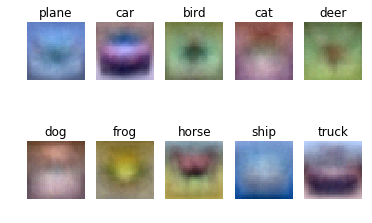

In [32]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])